# Imports

In [1]:
import numpy as np
import scipy 
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import torch 
from sklearn.metrics import precision_score
from sklearn.metrics import fbeta_score
from torch.utils.data import DataLoader

print(f'Package versions: \n')

print(f'numpy {np.__version__}')
print(f'pandas {pd.__version__}')
print(f'scikit-learn {sklearn.__version__}')
print(f'torch {torch.__version__}')
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from torch.utils.data import TensorDataset
import optuna
from torch import nn

Package versions: 

numpy 1.23.5
pandas 1.5.3
scikit-learn 1.2.1
torch 2.0.0+cu117


C:\Users\ericx\anaconda3\envs\QBUS2820\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Reading in Data

In [2]:
bank = pd.read_csv('clean_bank.csv')
predictors = list(bank.columns[:-1])
bank = bank[predictors]

index_train_v, index_test = train_test_split(bank.index, train_size=0.7, random_state=7)


train_v = bank.loc[index_train_v, :].copy()
test = bank.loc[index_test, :].copy()

index_train, index_valid = train_test_split(train_v.index, train_size=0.8, random_state=7)

train = train_v.loc[index_train, :].copy()
valid = train_v.loc[index_valid, :].copy()



X_train = train.loc[:, train.columns!='y']
X_valid = valid.loc[:, test.columns!='y']
X_test = test.loc[:, test.columns!='y']

# predictors = list(X_train.columns)

y_train = train['y']
y_valid = valid['y']
y_test = test['y']

# Encoding the data

In [3]:
from category_encoders.target_encoder import TargetEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder
from category_encoders.james_stein import JamesSteinEncoder
from category_encoders.glmm import GLMMEncoder
from category_encoders.cat_boost import CatBoostEncoder

In [4]:

nominal = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

for x in nominal:
    # Target encoder
    encoder = TargetEncoder().fit(train[x], y_train) # we must use the training set for this
    train[x+'TE'] = encoder.transform(train[x])
    valid[x+'TE'] = encoder.transform(valid[x])
    test[x+'TE'] = encoder.transform(test[x])


    # Leave one out encoder
    encoder = LeaveOneOutEncoder().fit(train[x], y_train) 
    train[x+'LeaveOneOut'] = encoder.transform(train[x])
    valid[x+'LeaveOneOut'] = encoder.transform(valid[x])
    test[x+'LeaveOneOut'] = encoder.transform(test[x])

    # GLMM encoder
    encoder =  GLMMEncoder().fit(train[x], y_train)
    train[x+'GLMM'] = encoder.transform(train[x])
    valid[x+'GLMM'] = encoder.transform(valid[x])
    test[x+'GLMM'] = encoder.transform(test[x])

    # CatBoostEncoder
    encoder = CatBoostEncoder().fit(train[x], y_train) 
    train[x+'CatBoost'] = encoder.transform(train[x])
    valid[x+'CatBoost'] = encoder.transform(valid[x])
    test[x+'CatBoost'] = encoder.transform(test[x])
    
    # One-hot encoder
    dummies = pd.get_dummies(bank[x],  prefix = x)
    train = train.join(dummies.loc[index_train, :])
    valid = valid.join(dummies.loc[index_valid, :])
    test = test.join(dummies.loc[index_test, :])
    globals()['%s_OneHot' % x] = list(dummies.columns)

In [5]:
keys = {
        'unknown' : 0,
        'basic4y' : 1, 
        'basic6y' : 2,
        'basic9y' : 3, 
        'highSchool' : 4, 
        'professional' : 5, 
        'university' : 6
}



variable = 'education'

train['educationOrdinal'] = train[variable].replace(keys).astype(int)
valid['educationOrdinal'] = valid[variable].replace(keys).astype(int)
test['educationOrdinal'] = test[variable].replace(keys).astype(int)

In [6]:
test = test.drop(['job','marital','education','default',
                     'housing','loan','contact','month',
                     'day_of_week','poutcome'], axis=1).copy()


train = train.drop(['job','marital','education','default',
                     'housing','loan','contact','month',
                     'day_of_week','poutcome'], axis=1).copy()

valid = valid.drop(['job','marital','education','default',
                     'housing','loan','contact','month',
                     'day_of_week','poutcome'], axis=1).copy()

In [7]:
X_train = train
X_test = test
X_valid = valid

# Neural network helper functions

In [8]:
def predict(net, X):
    
    # Use GPU if available
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Move data to device
    X_g = X.to(device)
    
    # Put model on evaluation mode (it makes no difference but needed in some cases)
    net.eval()
    
    # Disable gradient computation
    with torch.no_grad():
        
        # Predicted probabilities 
        # the .cpu().detach() part transfers the result to the cpu
        output  = net(X_g).cpu().detach()
    
    return output # the output is a tensor

In [9]:
import time

def train_net(model, input_size, trainloader, validset, trial=None, num_epochs = 5 , lr = 1e-3):
    
    # Get device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    if trial == None:
        # Instantiate model and move to device
        net = model(input_size).to(device)
    else:
        net = model(input_size, trial).to(device)
    
    # Loss function
    loss_fn = nn.BCELoss() # binary cross-entropy loss, assumes that the output of the network is a probability
    
    # Instantiate optimiser
    # Adam is a variant of SGD that often works well for training neural networks
    # https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
    optimiser = torch.optim.Adam(net.parameters(), lr = lr) 
    
    # Addding a learning rate scheduler to improve training
    # Adam + OneCycleLR is a good default for many problems
    # Learn more: https://sgugger.github.io/the-1cycle-policy.html
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimiser, max_lr = lr, 
                                                   steps_per_epoch=len(trainloader), epochs = num_epochs,
                                                   three_phase=True)
    # Number of training samples
    num_samples = len(trainloader.dataset)
    
    # Initialise table to track training
    table =  init_training_table(num_epochs)
    
    # Training loop
    print('Running first epoch')
    for epoch in range(num_epochs):
        
        # Make sure that the model is on training mode
        net.train()
        
        # Initialise timer
        epoch_start = time.time()
        
        # Initialise metric
        train_loss = 0.0
        
        # Iterate over minibatches
        for X, y in trainloader:

            # Move minibatch to device
            X_g = X.to(device)
            y_g = y.to(device)

            # Reset the gradient
            optimiser.zero_grad()

            # Compute predictions
            output = net(X_g)

            # Evaluate cost function
            loss = loss_fn(output, y_g)

            # Compute gradient 
            loss.backward()

            # Update parameters
            optimiser.step()
            
            # Update scheduler
            scheduler.step()
            
            # Keep track of the training loss
            l = loss.cpu().detach().numpy()
            train_loss +=  l*(len(y)/num_samples)
  
        # Epoch length
        duration = time.time() - epoch_start 
        
        # Display metrics
        if trial == None:
            table.iloc[epoch, 1] = np.round(10*train_loss, 3)
            table =  update_training_table(table, net, validset, epoch, duration)
    
    return net

In [10]:
# auxiliary code

from torch.nn import functional as F
from sklearn.metrics import recall_score, average_precision_score

def evaluate(net, validset):
    
    # Use GPU if available
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Set model to evaluation mode (not necessary here but required in general)
    net.eval()
    
    # Get input and target
    X, y = validset[:]
        
    # Predicted probabilities 
    output = predict(net, X)
        
    # Validation loss
    loss = F.binary_cross_entropy(output, y).item()
    
    # Convert output to numpy
    y_prob = output.numpy()
     
    # Classification using the decision threshold
    tau = 1/20
    y_pred = (y_prob > tau).astype(int)
    
    # Validation metrics
    recall = recall_score(y_valid, y_pred)
    average_precision = average_precision_score(y_valid, y_prob)
    
    return loss, recall, average_precision 


from IPython.display import clear_output
from IPython.display import display, HTML

def init_training_table(num_epochs):
    table = pd.DataFrame(np.arange(1, num_epochs+1), columns = ['epoch'])
    table['train loss'] = 0.0
    table['valid loss'] = 0.0
    table['valid recall'] = 0.0
    table['valid average precision'] = 0.0
    table['time'] = ''
    return table

def update_training_table(table, net, validset, epoch, duration):
    
    # Run evaluation function to get validation metrics
    valid_loss, valid_recall, valid_ave_precision = evaluate(net, validset)
        
    # Update table
    table.iloc[epoch, 2] = np.round(10*valid_loss, 3)
    table.iloc[epoch, 3] = np.round(valid_recall, 3)
    table.iloc[epoch, 4] = np.round(valid_ave_precision, 3)
     
    # Epoch length   
    if duration > 3600:
        table.iloc[epoch, 5] = time.strftime('%H:%M:%S', time.gmtime(duration))
    else:
        table.iloc[epoch, 5] = time.strftime('%M:%S', time.gmtime(duration))
        
    clear_output(wait=True)
    display(HTML(table.iloc[:epoch+1, :].to_html(index=False)))
    
    return table

# Testing the different encodings on a simple neural network

In [11]:
from sklearn.metrics import f1_score

In [11]:
from sklearn.metrics import f1_score

def test_encodings(algo, variables):

    results_df_dic = {}
    for x in nominal:

        rows = ['One-Hot encoding', 'Target encoder', 'Leave-one-out encoder', 
        'GLMM encoder', 'CatBoost encoder', 'ordinal encoder']

        columns=['Cross-entropy', 'Error Rate', 'AUC', 'Sensitivity', 'Specificity', 'Precision', 'F1-score']

        results = pd.DataFrame(0.0, columns=columns, index=rows)


        y_prob = np.zeros((len(y_valid), len(rows)))
        for i in range(len(rows)):
            if i == 5 and x != 'education':
                continue
            feature = []
            if i==0:
                feature = variables + globals()['%s_OneHot' % x]
            elif i==1: 
                feature = variables + [x+'TE'] 
            elif i==2:
                feature = variables + [x+'LeaveOneOut']
            elif i==3: 
                feature = variables + [x+'GLMM']
            elif i==4: 
                feature = variables + [x+'CatBoost']  
            if x == 'education':
                if i==5:
                    feature = variables + ['educationOrdinal']

            X_train = train[feature].copy()
            X_valid = valid[feature].copy()
            
            trainset  = TensorDataset(torch.from_numpy(X_train.to_numpy()).float(), torch.from_numpy(y_train).float())
            validset  = TensorDataset(torch.from_numpy(X_valid.to_numpy()).float(), torch.from_numpy(y_valid).float())
            testset = TensorDataset(torch.from_numpy(X_test.to_numpy()).float(), torch.from_numpy(y_valid).float())
            
            trainloader = DataLoader(trainset, batch_size = 1024, shuffle=True)
            
            model = algo
            
            model.train(X_train, y_train)

            # validation set predictions

            y_prob[:, i] = model.predict(X_valid)

            lfp = 1
            lfn = 19
            tau = lfp/(lfp+lfn)

            y_prob[:, i][y_prob[:,i] < 1e-5] = 1e-5 # Log-loss returns NaN if too close to zero or one
            y_prob[:, i][y_prob[:,i] > 1- 1e-5] =  1- 1e-5

            y_pred = (y_prob[:,i] > tau).astype(int)
            # y_pred = model.predict(X_valid)

            tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel() 

            results.iloc[i,0] =  log_loss(y_valid, y_prob[:,i])   # Cross entropy
            results.iloc[i,1] =   1 - accuracy_score(y_valid, y_pred)   # Error rate
            results.iloc[i,2] =  roc_auc_score(y_valid, y_prob[:,i])   # AUC
            results.iloc[i,3] =  tp/(tp+fn)   # Sensitivity 
            results.iloc[i,4] =  tn/(tn+fp)   # Specificity	
            results.iloc[i,5] =  precision_score(y_valid, y_pred)   # Precision
            results.iloc[i, 6] = f1_score(y_valid, y_pred)




        if x not in results_df_dic:
            results_df_dic[x] = results
    return results_df_dic

In [19]:
class NeuralNetwork(nn.Module):
    
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        
        self.feedforward = nn.Sequential(            
            nn.Linear(input_size, 40),            
            nn.ReLU(),                       
            nn.Linear(40, 40),
            nn.ReLU(),  
            nn.Linear(40, 40),
            nn.ReLU(),
            nn.Linear(40, 1),
            nn.Sigmoid()
        )                        


    def forward(self, X):        
        return self.feedforward(X).flatten() # returns a flat array as desired

# Converting data to Dataset and Dataloader for pytorch

In [12]:

trainset  = TensorDataset(torch.from_numpy(X_train.copy().to_numpy()).float(), torch.from_numpy(y_train.to_numpy()).float())
validset  = TensorDataset(torch.from_numpy(X_valid.copy().to_numpy()).float(), torch.from_numpy(y_valid.to_numpy()).float())
testset = TensorDataset(torch.from_numpy(X_test.copy().to_numpy()).float(), torch.from_numpy(y_test.to_numpy()).float())


# Testing different encodings

In [13]:
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, log_loss
from torch.nn import functional as F
from sklearn.metrics import recall_score, average_precision_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

In [15]:
def test_encodings(variables):

    results_df_dic = {}
    for x in nominal:

        rows = ['One-Hot encoding', 'Target encoder', 'Leave-one-out encoder', 
                'GLMM encoder', 'CatBoost encoder', 'ordinal encoder']

        columns=['Cross-entropy', 'Error Rate', 'AUC', 'Sensitivity', 'Specificity', 'Precision', 'F1-score']

        results = pd.DataFrame(0.0, columns=columns, index=rows)


        y_prob = np.zeros((len(y_valid), len(rows)))
        for i in range(len(rows)):
            if i == 5 and x != 'education':
                continue
            feature = []
            if i==0:
                feature = variables + globals()['%s_OneHot' % x]
            elif i==1: 
                feature = variables + [x+'TE'] 
            elif i==2:
                feature = variables + [x+'LeaveOneOut']
            elif i==3: 
                feature = variables + [x+'GLMM']
            elif i==4: 
                feature = variables + [x+'CatBoost']  
            if x == 'education':
                if i==5:
                    feature = variables + ['educationOrdinal']

            X_train = train[feature]
            X_valid = valid[feature]

            trainset  = TensorDataset(torch.from_numpy(X_train.copy().to_numpy()).float(), torch.from_numpy(y_train.to_numpy()).float())
            validset  = TensorDataset(torch.from_numpy(X_valid.copy().to_numpy()).float(), torch.from_numpy(y_valid.to_numpy()).float())
            trainloader = DataLoader(trainset, batch_size = 1024, shuffle=True)

            mlp = train_net(NeuralNetwork, len(X_train.columns), trainloader, validset, num_epochs = 10, lr = 3e-3)

            X = validset[:][0]
            y_prob[:, i] = predict(mlp, X).numpy()


            lfp = 1
            lfn = 19
            tau = lfp/(lfp+lfn)

            y_prob[:, i][y_prob[:,i] < 1e-5] = 1e-5 # Log-loss returns NaN if too close to zero or one
            y_prob[:, i][y_prob[:,i] > 1- 1e-5] =  1- 1e-5

            y_pred = (y_prob[:,i] > tau).astype(int)
            # y_pred = model.predict(X_valid)

            tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel() 

            results.iloc[i,0] =  log_loss(y_valid, y_prob[:,i])   # Cross entropy
            results.iloc[i,1] =   1 - accuracy_score(y_valid, y_pred)   # Error rate
            results.iloc[i,2] =  roc_auc_score(y_valid, y_prob[:,i])   # AUC
            results.iloc[i,3] =  tp/(tp+fn)   # Sensitivity 
            results.iloc[i,4] =  tn/(tn+fp)   # Specificity	
            results.iloc[i,5] =  precision_score(y_valid, y_pred)   # Precision
            results.iloc[i, 6] = f1_score(y_valid, y_pred)



        if x not in results_df_dic:
            results_df_dic[x] = results
    return results_df_dic

In [16]:
features = ['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
results_df_dic = test_encodings(features)

epoch,train loss,valid loss,valid recall,valid average precision,time
1,4.873,4.406,1.0,0.297,00:00
2,16.874,36.754,0.0,0.417,00:00
3,70.242,119.239,0.0,0.252,00:00
4,119.484,121.883,0.0,0.220,00:00
5,120.587,121.982,0.0,0.218,00:00
6,120.651,121.984,0.0,0.218,00:00
7,120.651,121.985,0.0,0.218,00:00
8,120.652,121.985,0.0,0.218,00:00
9,120.652,121.985,0.0,0.218,00:00
10,120.652,121.985,0.0,0.218,00:00


C:\Users\ericx\anaconda3\envs\QBUS2820\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
for key in results_df_dic:
    print(key)
    display(results_df_dic[key].sort_values(by=['F1-score'], ascending = [0]).round(5))

job


,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,F1-score
One-Hot encoding,0.33896,0.87582,0.72241,1.0,0.0,0.12418,0.22093
Leave-one-out encoder,10.08323,0.87582,0.50000,1.0,0.0,0.12418,0.22093
Target encoder,1.42970,0.12418,0.50000,0.0,1.0,0.00000,0.00000
GLMM encoder,1.42970,0.12418,0.50000,0.0,1.0,0.00000,0.00000
CatBoost encoder,1.42970,0.12418,0.50000,0.0,1.0,0.00000,0.00000
ordinal encoder,0.00000,0.00000,0.00000,0.0,0.0,0.00000,0.00000


marital


,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,F1-score
CatBoost encoder,0.39038,0.87582,0.49801,1.0,0.0,0.12418,0.22093
One-Hot encoding,1.42970,0.12418,0.50000,0.0,1.0,0.00000,0.00000
Target encoder,1.42970,0.12418,0.50000,0.0,1.0,0.00000,0.00000
Leave-one-out encoder,1.42970,0.12418,0.50000,0.0,1.0,0.00000,0.00000
GLMM encoder,1.42970,0.12418,0.50000,0.0,1.0,0.00000,0.00000
ordinal encoder,0.00000,0.00000,0.00000,0.0,0.0,0.00000,0.00000


education


,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,F1-score
ordinal encoder,1.20859,0.11147,0.59417,0.2031,0.98571,0.66837,0.31153
One-Hot encoding,1.42970,0.12418,0.50000,0.0000,1.00000,0.00000,0.00000
Target encoder,1.42970,0.12418,0.50000,0.0000,1.00000,0.00000,0.00000
Leave-one-out encoder,1.42970,0.12418,0.50000,0.0000,1.00000,0.00000,0.00000
GLMM encoder,1.42970,0.12418,0.50000,0.0000,1.00000,0.00000,0.00000
CatBoost encoder,1.42970,0.12418,0.50000,0.0000,1.00000,0.00000,0.00000


default


,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,F1-score
One-Hot encoding,10.08323,0.87582,0.5,1.0,0.0,0.12418,0.22093
Target encoder,1.42970,0.12418,0.5,0.0,1.0,0.00000,0.00000
Leave-one-out encoder,1.42970,0.12418,0.5,0.0,1.0,0.00000,0.00000
GLMM encoder,1.42970,0.12418,0.5,0.0,1.0,0.00000,0.00000
CatBoost encoder,1.42970,0.12418,0.5,0.0,1.0,0.00000,0.00000
ordinal encoder,0.00000,0.00000,0.0,0.0,0.0,0.00000,0.00000


housing


,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,F1-score
GLMM encoder,1.16345,0.11147,0.59447,0.2031,0.98571,0.66837,0.31153
Target encoder,10.08323,0.87582,0.50000,1.0000,0.00000,0.12418,0.22093
CatBoost encoder,10.08323,0.87582,0.50000,1.0000,0.00000,0.12418,0.22093
One-Hot encoding,1.42970,0.12418,0.50000,0.0000,1.00000,0.00000,0.00000
Leave-one-out encoder,1.42970,0.12418,0.50000,0.0000,1.00000,0.00000,0.00000
ordinal encoder,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000


loan


,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,F1-score
One-Hot encoding,0.34379,0.87582,0.59835,1.0,0.0,0.12418,0.22093
Target encoder,0.39588,0.87582,0.52490,1.0,0.0,0.12418,0.22093
GLMM encoder,10.08323,0.87582,0.50000,1.0,0.0,0.12418,0.22093
Leave-one-out encoder,1.42970,0.12418,0.50000,0.0,1.0,0.00000,0.00000
CatBoost encoder,1.42970,0.12418,0.50000,0.0,1.0,0.00000,0.00000
ordinal encoder,0.00000,0.00000,0.00000,0.0,0.0,0.00000,0.00000


contact


,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,F1-score
One-Hot encoding,10.08323,0.87582,0.5,1.0,0.0,0.12418,0.22093
Target encoder,10.08323,0.87582,0.5,1.0,0.0,0.12418,0.22093
GLMM encoder,10.08323,0.87582,0.5,1.0,0.0,0.12418,0.22093
Leave-one-out encoder,1.42970,0.12418,0.5,0.0,1.0,0.00000,0.00000
CatBoost encoder,1.42970,0.12418,0.5,0.0,1.0,0.00000,0.00000
ordinal encoder,0.00000,0.00000,0.0,0.0,0.0,0.00000,0.00000


month


,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,F1-score
One-Hot encoding,0.34099,0.87582,0.69111,1.0,0.0,0.12418,0.22093
Target encoder,10.08323,0.87582,0.50000,1.0,0.0,0.12418,0.22093
GLMM encoder,10.08323,0.87582,0.50000,1.0,0.0,0.12418,0.22093
CatBoost encoder,10.08323,0.87582,0.50000,1.0,0.0,0.12418,0.22093
Leave-one-out encoder,1.42970,0.12418,0.50000,0.0,1.0,0.00000,0.00000
ordinal encoder,0.00000,0.00000,0.00000,0.0,0.0,0.00000,0.00000


day_of_week


,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,F1-score
One-Hot encoding,10.08323,0.87582,0.50000,1.0,0.0,0.12418,0.22093
Target encoder,0.34156,0.87582,0.71712,1.0,0.0,0.12418,0.22093
Leave-one-out encoder,10.08323,0.87582,0.50000,1.0,0.0,0.12418,0.22093
CatBoost encoder,10.08323,0.87582,0.50000,1.0,0.0,0.12418,0.22093
GLMM encoder,1.42970,0.12418,0.50000,0.0,1.0,0.00000,0.00000
ordinal encoder,0.00000,0.00000,0.00000,0.0,0.0,0.00000,0.00000


poutcome


,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,F1-score
One-Hot encoding,10.08323,0.87582,0.50000,1.0,0.0,0.12418,0.22093
Target encoder,0.40237,0.87582,0.57168,1.0,0.0,0.12418,0.22093
Leave-one-out encoder,10.08323,0.87582,0.50000,1.0,0.0,0.12418,0.22093
GLMM encoder,0.34270,0.87582,0.59041,1.0,0.0,0.12418,0.22093
CatBoost encoder,1.42970,0.12418,0.50000,0.0,1.0,0.00000,0.00000
ordinal encoder,0.00000,0.00000,0.00000,0.0,0.0,0.00000,0.00000


## Summary on which encodings to use


- **job**: One-Hot encoding	
- **martial**: One-Hot encoding	
- **education**: One-Hot encoding
- **default**: One-Hot encoding
- **housing**: One-Hot encoding	
- **loan**: One-Hot encoding	
- **contact**: GLMM encoder
- **month**: One-Hot encoding	
- **day_of_week**: GLMM encoder
- **poutcome**: One-Hot encoding

In [14]:
best_encodings_for_nn = {'OneHot': ['job', 'marital', 'education', 'default', 'housing', 'loan', 'month', 'poutcome'], 'GLMM': ['contact', 'day_of_week']}

In [15]:

def get_feature_encodings(encoding_dic):
    best_features = []
    for i in encoding_dic:
        for j in encoding_dic[i]:
            if i == 'OneHot':
                best_features = best_features + globals()['%s_OneHot' % j]
            else:
                best_features = best_features + [j + i]
    return best_features


In [16]:
from torch.utils.data import DataLoader

In [17]:
best_features = get_feature_encodings(best_encodings_for_nn)

In [20]:
features = ['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
feature_for_nn = best_features + features

def get_model_performance(feature_list, algo_name):

    X_train = train[feature_list]
    X_valid = valid[feature_list]
    y_prob = np.zeros(len(y_valid))
    
    trainset  = TensorDataset(torch.from_numpy(X_train.copy().to_numpy()).float(), torch.from_numpy(y_train.to_numpy()).float())
    validset  = TensorDataset(torch.from_numpy(X_valid.copy().to_numpy()).float(), torch.from_numpy(y_valid.to_numpy()).float())
    trainloader = DataLoader(trainset, batch_size = 1024, shuffle=True)

    mlp = train_net(NeuralNetwork, len(feature_for_nn), trainloader, validset, num_epochs = 100, lr = 3e-3)

    X = validset[:][0]
    y_prob = predict(mlp, X).numpy()

    lfp = 1
    lfn = 19
    tau = lfp/(lfp+lfn)

    y_prob[y_prob < 1e-5] = 1e-5 # Log-loss returns NaN if too close to zero or one
    y_prob[y_prob > 1- 1e-5] =  1- 1e-5

    y_pred = (y_prob > tau).astype(int)
    # y_pred = model.predict(X_valid)

    tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel() 

    columns=['Cross-entropy', 'Error Rate', 'AUC', 'Sensitivity', 'Specificity', 'Precision']

    results = pd.DataFrame(0.0, columns=columns, index=[algo_name])

    results.iloc[:,0] =  log_loss(y_valid, y_prob)   # Cross entropy
    results.iloc[:,1] =   1 - accuracy_score(y_valid, y_pred)   # Error rate
    results.iloc[:,2] =  roc_auc_score(y_valid, y_prob)   # AUC
    results.iloc[:,3] =  tp/(tp+fn)   # Sensitivity 
    results.iloc[:,4] =  tn/(tn+fp)   # Specificity	
    results.iloc[:,5] =  precision_score(y_valid, y_pred)   # Precision
    return results, mlp


results, fitted_model = get_model_performance(feature_for_nn, "Neural network")

display(results.sort_values(by=['AUC'], ascending = [0]).round(5))

epoch,train loss,valid loss,valid recall,valid average precision,time
1,26.901,5.830,0.203,0.431,00:03
2,8.316,9.460,0.000,0.427,00:00
3,7.620,4.483,0.203,0.427,00:00
4,4.069,3.542,1.000,0.424,00:00
5,3.669,3.524,1.000,0.358,00:00
6,3.473,3.434,1.000,0.370,00:00
7,3.404,3.448,1.000,0.375,00:00
8,3.401,3.423,1.000,0.378,00:00
9,3.380,3.399,1.000,0.379,00:00
10,3.380,3.400,1.000,0.385,00:00


,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision
Neural network,0.31292,0.70524,0.76552,0.93488,0.204,0.14276


# Confusion matrix

In [23]:
import seaborn as sns

In [24]:
def plot_cm(labels, predictions):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('(True Negatives): ', cm[0][0])
    print('(False Positives): ', cm[0][1])
    print('(False Negatives): ', cm[1][0])
    print('(True Positives): ', cm[1][1])
    print('Total subscribed Transactions: ', np.sum(cm[1]))
    
    print('total loss from loss matrix:', cm[1][0] * 19 + cm[0][1])

(True Negatives):  928
(False Positives):  3621
(False Negatives):  42
(True Positives):  603
Total subscribed Transactions:  645
total loss from loss matrix: 4419


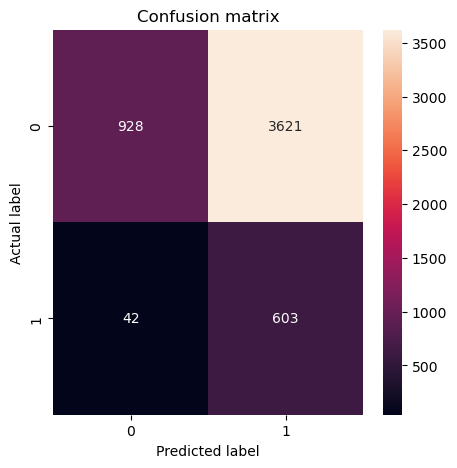

In [25]:
def display_confusion_mat(feature_list):
    X_valid = valid[feature_list]
    validset  = TensorDataset(torch.from_numpy(X_valid.copy().to_numpy()).float(), torch.from_numpy(y_valid.to_numpy()).float())

    lfp = 1
    lfn = 19
    tau = lfp/(lfp+lfn)

    # y_pred = decision_tree.predict(X_valid[feature_for_dt])

    y_prob = predict(fitted_model, validset[:][0]).numpy()

    y_prob[y_prob < 1e-5] = 1e-5 # Log-loss returns NaN if too close to zero or one
    y_prob[y_prob > 1- 1e-5] =  1- 1e-5

    y_pred = (y_prob > tau).astype(int)
    # y_pred = decision_tree.predict(valid[feature_for_dt])

    plot_cm(y_valid, y_pred)
display_confusion_mat(feature_for_nn)

# Using optuna to optimize number of layers and neurons

In [26]:
class NeuralNetworkBuilder(nn.Module):
    
    def __init__(self, input_size, trial):
        super(NeuralNetworkBuilder, self).__init__()
        
        self.modules = []
        self.neurons = []
        
        hidden_layers = trial.suggest_int('num_layers', 1, 5)
        
        for i in range(hidden_layers):
            activation_func = trial.suggest_categorical(f'activation_func_{i}', ['relu', 'leakyrelu', 'tanh', 'sigmoid'])
            
            if activation_func == "relu":
                self.activation_func = nn.ReLU()
            elif activation_func == "leakyrelu":
                self.activation_func = nn.LeakyReLU()
            elif activation_func == "tanh":
                self.activation_func = nn.Tanh()
            elif activation_func == "sigmoid":
                self.activation_func = nn.Sigmoid()
                
            neurons = trial.suggest_int(f'num_neurons_{i}', 1, 40)
            self.neurons.append(neurons)
            
            if i == 0:
                self.modules.append(nn.Linear(input_size, neurons))
                
            else:
                self.modules.append(nn.Linear(self.neurons[i - 1], neurons))
            self.modules.append(self.activation_func)
        
        self.modules.append(nn.Linear(self.neurons[-1], 1))
        self.modules.append(nn.Sigmoid())
        
        self.feedforward = nn.Sequential(*self.modules)                        


    def forward(self, X):        
        return self.feedforward(X).flatten() # returns a flat array as desired

In [27]:
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score

X_train = train[feature_for_nn]
X_valid = valid[feature_for_nn]

trainset  = TensorDataset(torch.from_numpy(X_train.copy().to_numpy()).float(), torch.from_numpy(y_train.to_numpy()).float())
validset  = TensorDataset(torch.from_numpy(X_valid.copy().to_numpy()).float(), torch.from_numpy(y_valid.to_numpy()).float())
trainloader = DataLoader(trainset, batch_size = 1024, shuffle=True)

def objective(trial):
       
    model = train_net(NeuralNetworkBuilder, len(feature_for_nn), trainloader, validset, trial=trial, num_epochs = 20, lr = 5e-3)
  
    lfp = 1
    lfn = 19
    tau = lfp/(lfp+lfn)

    # y_pred = decision_tree.predict(X_valid[feature_for_dt])

    y_prob = predict(model, validset[:][0]).numpy()
    y_prob[y_prob < 1e-5] = 1e-5
    y_prob[y_prob > 1- 1e-5] =  1- 1e-5
    y_pred = (y_prob > tau).astype(int)
    f1 = f1_score(y_valid, y_pred)
    
    return f1

sampler = TPESampler(seed=42) 
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials = 1000, timeout = 2000) 

[I 2023-05-23 15:43:55,881] A new study created in memory with name: no-name-75c66edb-9f72-4fc8-b534-e9fadfade73f


Running first epoch


[I 2023-05-23 15:43:59,922] Trial 0 finished with value: 0.0 and parameters: {'num_layers': 2, 'activation_func_0': 'relu', 'num_neurons_0': 7, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 1}. Best is trial 0 with value: 0.0.


Running first epoch


[I 2023-05-23 15:44:04,319] Trial 1 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'relu', 'num_neurons_0': 13, 'activation_func_1': 'sigmoid', 'num_neurons_1': 6, 'activation_func_2': 'sigmoid', 'num_neurons_2': 8, 'activation_func_3': 'sigmoid', 'num_neurons_3': 7, 'activation_func_4': 'tanh', 'num_neurons_4': 13}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:44:08,264] Trial 2 finished with value: 0.0 and parameters: {'num_layers': 1, 'activation_func_0': 'relu', 'num_neurons_0': 2}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:44:12,575] Trial 3 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 22, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 36, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 2, 'activation_func_3': 'sigmoid', 'num_neurons_3': 15, 'activation_func_4': 'sigmoid', 'num_neurons_4': 3}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:44:17,021] Trial 4 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 29, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 5, 'activation_func_2': 'relu', 'num_neurons_2': 13, 'activation_func_3': 'sigmoid', 'num_neurons_3': 19, 'activation_func_4': 'tanh', 'num_neurons_4': 31}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:44:21,153] Trial 5 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'relu', 'num_neurons_0': 2, 'activation_func_1': 'sigmoid', 'num_neurons_1': 10, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 12}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:44:24,957] Trial 6 finished with value: 0.0 and parameters: {'num_layers': 1, 'activation_func_0': 'relu', 'num_neurons_0': 33}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:44:28,830] Trial 7 finished with value: 0.22092824113718101 and parameters: {'num_layers': 1, 'activation_func_0': 'sigmoid', 'num_neurons_0': 13}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:44:32,799] Trial 8 finished with value: 0.22092824113718101 and parameters: {'num_layers': 1, 'activation_func_0': 'sigmoid', 'num_neurons_0': 1}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:44:36,985] Trial 9 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'relu', 'num_neurons_0': 38, 'activation_func_1': 'tanh', 'num_neurons_1': 39, 'activation_func_2': 'relu', 'num_neurons_2': 12}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:44:41,396] Trial 10 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'tanh', 'num_neurons_0': 16, 'activation_func_1': 'relu', 'num_neurons_1': 21, 'activation_func_2': 'sigmoid', 'num_neurons_2': 39, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 2}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:44:45,997] Trial 11 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 23, 'activation_func_1': 'sigmoid', 'num_neurons_1': 37, 'activation_func_2': 'tanh', 'num_neurons_2': 1, 'activation_func_3': 'sigmoid', 'num_neurons_3': 10, 'activation_func_4': 'sigmoid', 'num_neurons_4': 2}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:44:50,462] Trial 12 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 20, 'activation_func_1': 'sigmoid', 'num_neurons_1': 26, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 1, 'activation_func_3': 'relu', 'num_neurons_3': 39}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:44:54,708] Trial 13 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 12, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 14, 'activation_func_2': 'sigmoid', 'num_neurons_2': 26, 'activation_func_3': 'tanh', 'num_neurons_3': 13, 'activation_func_4': 'sigmoid', 'num_neurons_4': 6}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:44:58,850] Trial 14 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'tanh', 'num_neurons_0': 25, 'activation_func_1': 'tanh', 'num_neurons_1': 29, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 6, 'activation_func_3': 'sigmoid', 'num_neurons_3': 27}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:45:03,188] Trial 15 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 19, 'activation_func_1': 'relu', 'num_neurons_1': 16, 'activation_func_2': 'sigmoid', 'num_neurons_2': 25, 'activation_func_3': 'sigmoid', 'num_neurons_3': 1, 'activation_func_4': 'leakyrelu', 'num_neurons_4': 14}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:45:07,756] Trial 16 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 9, 'activation_func_1': 'sigmoid', 'num_neurons_1': 32, 'activation_func_2': 'tanh', 'num_neurons_2': 8, 'activation_func_3': 'sigmoid', 'num_neurons_3': 13}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:45:12,214] Trial 17 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'tanh', 'num_neurons_0': 27, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 20, 'activation_func_2': 'sigmoid', 'num_neurons_2': 19, 'activation_func_3': 'relu', 'num_neurons_3': 24, 'activation_func_4': 'relu', 'num_neurons_4': 15}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:45:16,420] Trial 18 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'relu', 'num_neurons_0': 16, 'activation_func_1': 'sigmoid', 'num_neurons_1': 8, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 6}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:45:20,770] Trial 19 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 31, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 24, 'activation_func_2': 'sigmoid', 'num_neurons_2': 17, 'activation_func_3': 'tanh', 'num_neurons_3': 8}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:45:25,623] Trial 20 finished with value: 0.0 and parameters: {'num_layers': 2, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 7, 'activation_func_1': 'relu', 'num_neurons_1': 14}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:45:30,665] Trial 21 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 29, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 1, 'activation_func_2': 'relu', 'num_neurons_2': 12, 'activation_func_3': 'sigmoid', 'num_neurons_3': 19, 'activation_func_4': 'tanh', 'num_neurons_4': 35}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:45:35,160] Trial 22 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 36, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 6, 'activation_func_2': 'relu', 'num_neurons_2': 7, 'activation_func_3': 'sigmoid', 'num_neurons_3': 19, 'activation_func_4': 'tanh', 'num_neurons_4': 30}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:45:39,914] Trial 23 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 26, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 5, 'activation_func_2': 'relu', 'num_neurons_2': 15, 'activation_func_3': 'sigmoid', 'num_neurons_3': 17, 'activation_func_4': 'tanh', 'num_neurons_4': 25}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:45:44,347] Trial 24 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'sigmoid', 'num_neurons_0': 23, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 34, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 1, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 30}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:45:48,711] Trial 25 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 17, 'activation_func_1': 'tanh', 'num_neurons_1': 10, 'activation_func_2': 'relu', 'num_neurons_2': 23, 'activation_func_3': 'sigmoid', 'num_neurons_3': 6, 'activation_func_4': 'tanh', 'num_neurons_4': 11}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:45:53,177] Trial 26 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 34, 'activation_func_1': 'sigmoid', 'num_neurons_1': 4, 'activation_func_2': 'tanh', 'num_neurons_2': 31, 'activation_func_3': 'sigmoid', 'num_neurons_3': 15}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:45:57,556] Trial 27 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'tanh', 'num_neurons_0': 22, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 16, 'activation_func_2': 'sigmoid', 'num_neurons_2': 10, 'activation_func_3': 'sigmoid', 'num_neurons_3': 23, 'activation_func_4': 'sigmoid', 'num_neurons_4': 22}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:46:01,991] Trial 28 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 29, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 11, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 4, 'activation_func_3': 'tanh', 'num_neurons_3': 6, 'activation_func_4': 'tanh', 'num_neurons_4': 37}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:46:06,095] Trial 29 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'relu', 'num_neurons_0': 12, 'activation_func_1': 'sigmoid', 'num_neurons_1': 20, 'activation_func_2': 'relu', 'num_neurons_2': 15}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:46:10,182] Trial 30 finished with value: 0.22092824113718101 and parameters: {'num_layers': 2, 'activation_func_0': 'sigmoid', 'num_neurons_0': 40, 'activation_func_1': 'relu', 'num_neurons_1': 29}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:46:14,196] Trial 31 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'relu', 'num_neurons_0': 3, 'activation_func_1': 'sigmoid', 'num_neurons_1': 9, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 12}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:46:18,285] Trial 32 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'relu', 'num_neurons_0': 5, 'activation_func_1': 'sigmoid', 'num_neurons_1': 4, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 9}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:46:22,358] Trial 33 finished with value: 0.22092824113718101 and parameters: {'num_layers': 2, 'activation_func_0': 'relu', 'num_neurons_0': 10, 'activation_func_1': 'sigmoid', 'num_neurons_1': 12}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:46:26,927] Trial 34 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 5, 'activation_func_1': 'sigmoid', 'num_neurons_1': 2, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 4, 'activation_func_3': 'relu', 'num_neurons_3': 10}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:46:31,294] Trial 35 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'relu', 'num_neurons_0': 18, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 7, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 15}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:46:35,821] Trial 36 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 31, 'activation_func_1': 'tanh', 'num_neurons_1': 40, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 4, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 33}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:46:40,129] Trial 37 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'relu', 'num_neurons_0': 14, 'activation_func_1': 'sigmoid', 'num_neurons_1': 3, 'activation_func_2': 'relu', 'num_neurons_2': 11, 'activation_func_3': 'sigmoid', 'num_neurons_3': 15, 'activation_func_4': 'relu', 'num_neurons_4': 7}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:46:44,261] Trial 38 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'sigmoid', 'num_neurons_0': 9, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 17, 'activation_func_2': 'sigmoid', 'num_neurons_2': 20}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:46:48,250] Trial 39 finished with value: 0.22092824113718101 and parameters: {'num_layers': 2, 'activation_func_0': 'relu', 'num_neurons_0': 2, 'activation_func_1': 'tanh', 'num_neurons_1': 36}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:46:52,359] Trial 40 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'tanh', 'num_neurons_0': 22, 'activation_func_1': 'sigmoid', 'num_neurons_1': 7, 'activation_func_2': 'relu', 'num_neurons_2': 13, 'activation_func_3': 'sigmoid', 'num_neurons_3': 20}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:46:56,359] Trial 41 finished with value: 0.22092824113718101 and parameters: {'num_layers': 1, 'activation_func_0': 'sigmoid', 'num_neurons_0': 13}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:47:00,412] Trial 42 finished with value: 0.22092824113718101 and parameters: {'num_layers': 1, 'activation_func_0': 'sigmoid', 'num_neurons_0': 14}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:47:04,325] Trial 43 finished with value: 0.22092824113718101 and parameters: {'num_layers': 1, 'activation_func_0': 'sigmoid', 'num_neurons_0': 20}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:47:08,608] Trial 44 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 24, 'activation_func_1': 'relu', 'num_neurons_1': 23, 'activation_func_2': 'tanh', 'num_neurons_2': 9, 'activation_func_3': 'sigmoid', 'num_neurons_3': 23, 'activation_func_4': 'leakyrelu', 'num_neurons_4': 1}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:47:12,476] Trial 45 finished with value: 0.22092824113718101 and parameters: {'num_layers': 1, 'activation_func_0': 'sigmoid', 'num_neurons_0': 7}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:47:16,489] Trial 46 finished with value: 0.0 and parameters: {'num_layers': 2, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 15, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 13}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:47:20,861] Trial 47 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'tanh', 'num_neurons_0': 11, 'activation_func_1': 'sigmoid', 'num_neurons_1': 1, 'activation_func_2': 'sigmoid', 'num_neurons_2': 37, 'activation_func_3': 'sigmoid', 'num_neurons_3': 4, 'activation_func_4': 'sigmoid', 'num_neurons_4': 18}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:47:25,201] Trial 48 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 27, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 29, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 3, 'activation_func_3': 'relu', 'num_neurons_3': 11}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:47:29,726] Trial 49 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 1, 'activation_func_1': 'tanh', 'num_neurons_1': 9, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 17, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 17, 'activation_func_4': 'tanh', 'num_neurons_4': 27}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:47:33,864] Trial 50 finished with value: 0.22092824113718101 and parameters: {'num_layers': 2, 'activation_func_0': 'relu', 'num_neurons_0': 20, 'activation_func_1': 'sigmoid', 'num_neurons_1': 18}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:47:38,149] Trial 51 finished with value: 0.22092824113718101 and parameters: {'num_layers': 1, 'activation_func_0': 'sigmoid', 'num_neurons_0': 4}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:47:42,212] Trial 52 finished with value: 0.22092824113718101 and parameters: {'num_layers': 1, 'activation_func_0': 'sigmoid', 'num_neurons_0': 1}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:47:46,132] Trial 53 finished with value: 0.22092824113718101 and parameters: {'num_layers': 1, 'activation_func_0': 'sigmoid', 'num_neurons_0': 8}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:47:50,081] Trial 54 finished with value: 0.22092824113718101 and parameters: {'num_layers': 1, 'activation_func_0': 'sigmoid', 'num_neurons_0': 3}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:47:54,388] Trial 55 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 6, 'activation_func_1': 'relu', 'num_neurons_1': 32, 'activation_func_2': 'sigmoid', 'num_neurons_2': 6, 'activation_func_3': 'tanh', 'num_neurons_3': 14, 'activation_func_4': 'tanh', 'num_neurons_4': 9}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:47:58,506] Trial 56 finished with value: 0.22092824113718101 and parameters: {'num_layers': 2, 'activation_func_0': 'sigmoid', 'num_neurons_0': 18, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 26}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:48:03,352] Trial 57 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 34, 'activation_func_1': 'sigmoid', 'num_neurons_1': 15, 'activation_func_2': 'tanh', 'num_neurons_2': 1, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 7, 'activation_func_4': 'sigmoid', 'num_neurons_4': 33}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:48:07,502] Trial 58 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'tanh', 'num_neurons_0': 25, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 6, 'activation_func_2': 'relu', 'num_neurons_2': 14, 'activation_func_3': 'sigmoid', 'num_neurons_3': 3}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:48:11,826] Trial 59 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'relu', 'num_neurons_0': 16, 'activation_func_1': 'sigmoid', 'num_neurons_1': 11, 'activation_func_2': 'sigmoid', 'num_neurons_2': 22, 'activation_func_3': 'sigmoid', 'num_neurons_3': 26, 'activation_func_4': 'tanh', 'num_neurons_4': 20}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:48:15,722] Trial 60 finished with value: 0.22092824113718101 and parameters: {'num_layers': 1, 'activation_func_0': 'sigmoid', 'num_neurons_0': 28}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:48:20,016] Trial 61 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'relu', 'num_neurons_0': 38, 'activation_func_1': 'tanh', 'num_neurons_1': 38, 'activation_func_2': 'relu', 'num_neurons_2': 18}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:48:24,153] Trial 62 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'relu', 'num_neurons_0': 31, 'activation_func_1': 'tanh', 'num_neurons_1': 40, 'activation_func_2': 'relu', 'num_neurons_2': 8}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:48:28,309] Trial 63 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'relu', 'num_neurons_0': 40, 'activation_func_1': 'tanh', 'num_neurons_1': 37, 'activation_func_2': 'relu', 'num_neurons_2': 11}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:48:32,573] Trial 64 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 36, 'activation_func_1': 'tanh', 'num_neurons_1': 34, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 6, 'activation_func_3': 'relu', 'num_neurons_3': 17}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:48:36,780] Trial 65 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'relu', 'num_neurons_0': 32, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 35, 'activation_func_2': 'sigmoid', 'num_neurons_2': 29}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:48:41,176] Trial 66 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 21, 'activation_func_1': 'relu', 'num_neurons_1': 38, 'activation_func_2': 'relu', 'num_neurons_2': 13, 'activation_func_3': 'sigmoid', 'num_neurons_3': 40, 'activation_func_4': 'relu', 'num_neurons_4': 5}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:48:45,687] Trial 67 finished with value: 0.22092824113718101 and parameters: {'num_layers': 2, 'activation_func_0': 'sigmoid', 'num_neurons_0': 11, 'activation_func_1': 'tanh', 'num_neurons_1': 31}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:48:49,978] Trial 68 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'relu', 'num_neurons_0': 3, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 22, 'activation_func_2': 'tanh', 'num_neurons_2': 10, 'activation_func_3': 'tanh', 'num_neurons_3': 12, 'activation_func_4': 'leakyrelu', 'num_neurons_4': 39}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:48:53,998] Trial 69 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'sigmoid', 'num_neurons_0': 37, 'activation_func_1': 'sigmoid', 'num_neurons_1': 5, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 7}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:48:58,060] Trial 70 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 6, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 26, 'activation_func_2': 'relu', 'num_neurons_2': 17, 'activation_func_3': 'sigmoid', 'num_neurons_3': 35}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:49:02,617] Trial 71 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'tanh', 'num_neurons_0': 17, 'activation_func_1': 'relu', 'num_neurons_1': 8, 'activation_func_2': 'sigmoid', 'num_neurons_2': 40, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 3, 'activation_func_4': 'sigmoid', 'num_neurons_4': 13}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:49:07,005] Trial 72 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'tanh', 'num_neurons_0': 13, 'activation_func_1': 'relu', 'num_neurons_1': 3, 'activation_func_2': 'sigmoid', 'num_neurons_2': 33, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 1}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:49:11,265] Trial 73 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'tanh', 'num_neurons_0': 9, 'activation_func_1': 'relu', 'num_neurons_1': 18, 'activation_func_2': 'sigmoid', 'num_neurons_2': 25, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 5, 'activation_func_4': 'tanh', 'num_neurons_4': 17}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:49:15,572] Trial 74 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'tanh', 'num_neurons_0': 15, 'activation_func_1': 'relu', 'num_neurons_1': 28, 'activation_func_2': 'sigmoid', 'num_neurons_2': 28, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 10}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:49:20,110] Trial 75 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'tanh', 'num_neurons_0': 23, 'activation_func_1': 'sigmoid', 'num_neurons_1': 10, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 22}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:49:24,785] Trial 76 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 18, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 39, 'activation_func_2': 'sigmoid', 'num_neurons_2': 3, 'activation_func_3': 'sigmoid', 'num_neurons_3': 8, 'activation_func_4': 'tanh', 'num_neurons_4': 23}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:49:29,221] Trial 77 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 30, 'activation_func_1': 'relu', 'num_neurons_1': 21, 'activation_func_2': 'relu', 'num_neurons_2': 15, 'activation_func_3': 'relu', 'num_neurons_3': 9, 'activation_func_4': 'sigmoid', 'num_neurons_4': 30}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:49:33,411] Trial 78 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 12, 'activation_func_1': 'sigmoid', 'num_neurons_1': 31, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 8, 'activation_func_3': 'sigmoid', 'num_neurons_3': 21}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:49:37,413] Trial 79 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'sigmoid', 'num_neurons_0': 34, 'activation_func_1': 'tanh', 'num_neurons_1': 14, 'activation_func_2': 'relu', 'num_neurons_2': 34}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:49:41,400] Trial 80 finished with value: 0.22092824113718101 and parameters: {'num_layers': 2, 'activation_func_0': 'relu', 'num_neurons_0': 19, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 6}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:49:45,650] Trial 81 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 26, 'activation_func_1': 'sigmoid', 'num_neurons_1': 34, 'activation_func_2': 'tanh', 'num_neurons_2': 1, 'activation_func_3': 'sigmoid', 'num_neurons_3': 1, 'activation_func_4': 'sigmoid', 'num_neurons_4': 2}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:49:49,924] Trial 82 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 22, 'activation_func_1': 'sigmoid', 'num_neurons_1': 37, 'activation_func_2': 'tanh', 'num_neurons_2': 2, 'activation_func_3': 'sigmoid', 'num_neurons_3': 13, 'activation_func_4': 'sigmoid', 'num_neurons_4': 4}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:49:54,425] Trial 83 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 24, 'activation_func_1': 'sigmoid', 'num_neurons_1': 35, 'activation_func_2': 'tanh', 'num_neurons_2': 4, 'activation_func_3': 'sigmoid', 'num_neurons_3': 16, 'activation_func_4': 'sigmoid', 'num_neurons_4': 10}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:49:58,798] Trial 84 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 16, 'activation_func_1': 'sigmoid', 'num_neurons_1': 33, 'activation_func_2': 'tanh', 'num_neurons_2': 5, 'activation_func_3': 'sigmoid', 'num_neurons_3': 12, 'activation_func_4': 'sigmoid', 'num_neurons_4': 1}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:50:02,681] Trial 85 finished with value: 0.22092824113718101 and parameters: {'num_layers': 1, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 21}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:50:07,132] Trial 86 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 19, 'activation_func_1': 'sigmoid', 'num_neurons_1': 40, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 12, 'activation_func_3': 'tanh', 'num_neurons_3': 8, 'activation_func_4': 'sigmoid', 'num_neurons_4': 7}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:50:11,591] Trial 87 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'tanh', 'num_neurons_0': 2, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 4, 'activation_func_2': 'sigmoid', 'num_neurons_2': 9, 'activation_func_3': 'sigmoid', 'num_neurons_3': 18, 'activation_func_4': 'relu', 'num_neurons_4': 4}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:50:15,828] Trial 88 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 10, 'activation_func_1': 'sigmoid', 'num_neurons_1': 1, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 16, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 6}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:50:19,998] Trial 89 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'sigmoid', 'num_neurons_0': 28, 'activation_func_1': 'relu', 'num_neurons_1': 8, 'activation_func_2': 'tanh', 'num_neurons_2': 19, 'activation_func_3': 'sigmoid', 'num_neurons_3': 3}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:50:24,096] Trial 90 finished with value: 0.22092824113718101 and parameters: {'num_layers': 1, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 4}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:50:28,354] Trial 91 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 23, 'activation_func_1': 'sigmoid', 'num_neurons_1': 20, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 2}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:50:32,620] Trial 92 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 14, 'activation_func_1': 'sigmoid', 'num_neurons_1': 26, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 5, 'activation_func_3': 'relu', 'num_neurons_3': 28}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:50:37,101] Trial 93 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 17, 'activation_func_1': 'sigmoid', 'num_neurons_1': 24, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 2, 'activation_func_3': 'relu', 'num_neurons_3': 22, 'activation_func_4': 'leakyrelu', 'num_neurons_4': 8}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:50:41,859] Trial 94 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 20, 'activation_func_1': 'sigmoid', 'num_neurons_1': 36, 'activation_func_2': 'relu', 'num_neurons_2': 7, 'activation_func_3': 'relu', 'num_neurons_3': 20, 'activation_func_4': 'tanh', 'num_neurons_4': 12}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:50:46,077] Trial 95 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'relu', 'num_neurons_0': 26, 'activation_func_1': 'tanh', 'num_neurons_1': 19, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 11}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:50:50,334] Trial 96 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 25, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 38, 'activation_func_2': 'sigmoid', 'num_neurons_2': 13, 'activation_func_3': 'relu', 'num_neurons_3': 14, 'activation_func_4': 'sigmoid', 'num_neurons_4': 16}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:50:54,316] Trial 97 finished with value: 0.22092824113718101 and parameters: {'num_layers': 2, 'activation_func_0': 'relu', 'num_neurons_0': 19, 'activation_func_1': 'sigmoid', 'num_neurons_1': 28}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:50:58,345] Trial 98 finished with value: 0.22092824113718101 and parameters: {'num_layers': 1, 'activation_func_0': 'sigmoid', 'num_neurons_0': 15}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:51:02,576] Trial 99 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 22, 'activation_func_1': 'sigmoid', 'num_neurons_1': 24, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 5, 'activation_func_3': 'sigmoid', 'num_neurons_3': 25}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:51:06,890] Trial 100 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'tanh', 'num_neurons_0': 39, 'activation_func_1': 'tanh', 'num_neurons_1': 15, 'activation_func_2': 'relu', 'num_neurons_2': 3, 'activation_func_3': 'sigmoid', 'num_neurons_3': 40, 'activation_func_4': 'leakyrelu', 'num_neurons_4': 4}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:51:11,495] Trial 101 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 12, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 11, 'activation_func_2': 'sigmoid', 'num_neurons_2': 40, 'activation_func_3': 'tanh', 'num_neurons_3': 9, 'activation_func_4': 'sigmoid', 'num_neurons_4': 6}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:51:16,160] Trial 102 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 13, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 9, 'activation_func_2': 'sigmoid', 'num_neurons_2': 38, 'activation_func_3': 'tanh', 'num_neurons_3': 15, 'activation_func_4': 'sigmoid', 'num_neurons_4': 14}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:51:20,551] Trial 103 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 11, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 13, 'activation_func_2': 'sigmoid', 'num_neurons_2': 1, 'activation_func_3': 'tanh', 'num_neurons_3': 11, 'activation_func_4': 'tanh', 'num_neurons_4': 2}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:51:24,881] Trial 104 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'relu', 'num_neurons_0': 1, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 7, 'activation_func_2': 'sigmoid', 'num_neurons_2': 10, 'activation_func_3': 'tanh', 'num_neurons_3': 19, 'activation_func_4': 'sigmoid', 'num_neurons_4': 10}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:51:29,141] Trial 105 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 8, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 5, 'activation_func_2': 'relu', 'num_neurons_2': 14}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:51:33,570] Trial 106 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 17, 'activation_func_1': 'relu', 'num_neurons_1': 16, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 33, 'activation_func_3': 'sigmoid', 'num_neurons_3': 13, 'activation_func_4': 'tanh', 'num_neurons_4': 5}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:51:37,818] Trial 107 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 14, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 12, 'activation_func_2': 'sigmoid', 'num_neurons_2': 25, 'activation_func_3': 'relu', 'num_neurons_3': 33}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:51:42,073] Trial 108 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 15, 'activation_func_1': 'sigmoid', 'num_neurons_1': 36, 'activation_func_2': 'tanh', 'num_neurons_2': 30, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 5, 'activation_func_4': 'relu', 'num_neurons_4': 3}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:51:46,145] Trial 109 finished with value: 0.22092824113718101 and parameters: {'num_layers': 2, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 16, 'activation_func_1': 'tanh', 'num_neurons_1': 10}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:51:50,055] Trial 110 finished with value: 0.22092824113718101 and parameters: {'num_layers': 1, 'activation_func_0': 'tanh', 'num_neurons_0': 10}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:51:54,226] Trial 111 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'tanh', 'num_neurons_0': 24, 'activation_func_1': 'tanh', 'num_neurons_1': 39, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 7, 'activation_func_3': 'sigmoid', 'num_neurons_3': 38}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:51:58,363] Trial 112 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'tanh', 'num_neurons_0': 21, 'activation_func_1': 'tanh', 'num_neurons_1': 29, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 8, 'activation_func_3': 'sigmoid', 'num_neurons_3': 18}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:52:02,467] Trial 113 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'tanh', 'num_neurons_0': 25, 'activation_func_1': 'tanh', 'num_neurons_1': 25, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 10}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:52:06,615] Trial 114 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'tanh', 'num_neurons_0': 27, 'activation_func_1': 'tanh', 'num_neurons_1': 27, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 27, 'activation_func_3': 'sigmoid', 'num_neurons_3': 30}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:52:11,044] Trial 115 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 23, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 23, 'activation_func_2': 'relu', 'num_neurons_2': 6, 'activation_func_3': 'sigmoid', 'num_neurons_3': 16}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:52:15,365] Trial 116 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 30, 'activation_func_1': 'sigmoid', 'num_neurons_1': 31, 'activation_func_2': 'sigmoid', 'num_neurons_2': 3, 'activation_func_3': 'tanh', 'num_neurons_3': 11, 'activation_func_4': 'tanh', 'num_neurons_4': 8}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:52:19,462] Trial 117 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 35, 'activation_func_1': 'relu', 'num_neurons_1': 37, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 4}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:52:23,702] Trial 118 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'relu', 'num_neurons_0': 20, 'activation_func_1': 'sigmoid', 'num_neurons_1': 32, 'activation_func_2': 'relu', 'num_neurons_2': 1, 'activation_func_3': 'sigmoid', 'num_neurons_3': 36, 'activation_func_4': 'sigmoid', 'num_neurons_4': 27}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:52:27,863] Trial 119 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'sigmoid', 'num_neurons_0': 12, 'activation_func_1': 'tanh', 'num_neurons_1': 2, 'activation_func_2': 'sigmoid', 'num_neurons_2': 14, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 7}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:52:32,143] Trial 120 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'tanh', 'num_neurons_0': 4, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 21, 'activation_func_2': 'tanh', 'num_neurons_2': 12}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:52:36,578] Trial 121 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 2, 'activation_func_1': 'relu', 'num_neurons_1': 13, 'activation_func_2': 'sigmoid', 'num_neurons_2': 26, 'activation_func_3': 'sigmoid', 'num_neurons_3': 5, 'activation_func_4': 'leakyrelu', 'num_neurons_4': 19}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:52:40,787] Trial 122 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 19, 'activation_func_1': 'relu', 'num_neurons_1': 18, 'activation_func_2': 'sigmoid', 'num_neurons_2': 21, 'activation_func_3': 'sigmoid', 'num_neurons_3': 1, 'activation_func_4': 'leakyrelu', 'num_neurons_4': 15}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:52:45,227] Trial 123 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 18, 'activation_func_1': 'relu', 'num_neurons_1': 17, 'activation_func_2': 'sigmoid', 'num_neurons_2': 24, 'activation_func_3': 'sigmoid', 'num_neurons_3': 3, 'activation_func_4': 'leakyrelu', 'num_neurons_4': 12}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:52:49,657] Trial 124 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 22, 'activation_func_1': 'relu', 'num_neurons_1': 39, 'activation_func_2': 'sigmoid', 'num_neurons_2': 36, 'activation_func_3': 'sigmoid', 'num_neurons_3': 2, 'activation_func_4': 'tanh', 'num_neurons_4': 23}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:52:53,924] Trial 125 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 21, 'activation_func_1': 'sigmoid', 'num_neurons_1': 19, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 18, 'activation_func_3': 'sigmoid', 'num_neurons_3': 10, 'activation_func_4': 'leakyrelu', 'num_neurons_4': 6}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:52:57,754] Trial 126 finished with value: 0.0 and parameters: {'num_layers': 1, 'activation_func_0': 'relu', 'num_neurons_0': 32}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:53:01,973] Trial 127 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 23, 'activation_func_1': 'relu', 'num_neurons_1': 35, 'activation_func_2': 'relu', 'num_neurons_2': 2, 'activation_func_3': 'sigmoid', 'num_neurons_3': 4, 'activation_func_4': 'tanh', 'num_neurons_4': 1}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:53:06,306] Trial 128 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 17, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 15, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 4, 'activation_func_3': 'relu', 'num_neurons_3': 14, 'activation_func_4': 'sigmoid', 'num_neurons_4': 34}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:53:10,727] Trial 129 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 13, 'activation_func_1': 'sigmoid', 'num_neurons_1': 30, 'activation_func_2': 'sigmoid', 'num_neurons_2': 8, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 7}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:53:15,171] Trial 130 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'tanh', 'num_neurons_0': 28, 'activation_func_1': 'tanh', 'num_neurons_1': 22, 'activation_func_2': 'tanh', 'num_neurons_2': 23, 'activation_func_3': 'sigmoid', 'num_neurons_3': 31, 'activation_func_4': 'relu', 'num_neurons_4': 21}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:53:19,561] Trial 131 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 8, 'activation_func_1': 'sigmoid', 'num_neurons_1': 6, 'activation_func_2': 'tanh', 'num_neurons_2': 12, 'activation_func_3': 'sigmoid', 'num_neurons_3': 12}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:53:23,856] Trial 132 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 9, 'activation_func_1': 'sigmoid', 'num_neurons_1': 33, 'activation_func_2': 'tanh', 'num_neurons_2': 31, 'activation_func_3': 'sigmoid', 'num_neurons_3': 16}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:53:28,149] Trial 133 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 5, 'activation_func_1': 'sigmoid', 'num_neurons_1': 30, 'activation_func_2': 'tanh', 'num_neurons_2': 9, 'activation_func_3': 'sigmoid', 'num_neurons_3': 13}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:53:32,341] Trial 134 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 14, 'activation_func_1': 'sigmoid', 'num_neurons_1': 33, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 16, 'activation_func_3': 'sigmoid', 'num_neurons_3': 24}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:53:36,382] Trial 135 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'sigmoid', 'num_neurons_0': 11, 'activation_func_1': 'sigmoid', 'num_neurons_1': 36, 'activation_func_2': 'relu', 'num_neurons_2': 7}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:53:40,804] Trial 136 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 20, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 28, 'activation_func_2': 'tanh', 'num_neurons_2': 6, 'activation_func_3': 'tanh', 'num_neurons_3': 27, 'activation_func_4': 'tanh', 'num_neurons_4': 36}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:53:45,125] Trial 137 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 1, 'activation_func_1': 'relu', 'num_neurons_1': 7, 'activation_func_2': 'sigmoid', 'num_neurons_2': 11, 'activation_func_3': 'sigmoid', 'num_neurons_3': 15}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:53:49,448] Trial 138 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'relu', 'num_neurons_0': 3, 'activation_func_1': 'sigmoid', 'num_neurons_1': 12, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 5, 'activation_func_3': 'relu', 'num_neurons_3': 22, 'activation_func_4': 'sigmoid', 'num_neurons_4': 31}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:53:53,421] Trial 139 finished with value: 0.22092824113718101 and parameters: {'num_layers': 1, 'activation_func_0': 'sigmoid', 'num_neurons_0': 6}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:53:57,658] Trial 140 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 16, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 4, 'activation_func_2': 'sigmoid', 'num_neurons_2': 20}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:54:01,960] Trial 141 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'tanh', 'num_neurons_0': 22, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 8, 'activation_func_2': 'sigmoid', 'num_neurons_2': 13, 'activation_func_3': 'relu', 'num_neurons_3': 9, 'activation_func_4': 'relu', 'num_neurons_4': 17}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:54:06,339] Trial 142 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'tanh', 'num_neurons_0': 24, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 14, 'activation_func_2': 'sigmoid', 'num_neurons_2': 9, 'activation_func_3': 'relu', 'num_neurons_3': 24, 'activation_func_4': 'relu', 'num_neurons_4': 14}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:54:10,796] Trial 143 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'tanh', 'num_neurons_0': 26, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 20, 'activation_func_2': 'sigmoid', 'num_neurons_2': 3, 'activation_func_3': 'relu', 'num_neurons_3': 18, 'activation_func_4': 'relu', 'num_neurons_4': 11}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:54:14,999] Trial 144 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'tanh', 'num_neurons_0': 27, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 38, 'activation_func_2': 'relu', 'num_neurons_2': 15, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 22, 'activation_func_4': 'tanh', 'num_neurons_4': 40}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:54:19,166] Trial 145 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'tanh', 'num_neurons_0': 13, 'activation_func_1': 'tanh', 'num_neurons_1': 17, 'activation_func_2': 'sigmoid', 'num_neurons_2': 2, 'activation_func_3': 'sigmoid', 'num_neurons_3': 2, 'activation_func_4': 'sigmoid', 'num_neurons_4': 18}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:54:23,306] Trial 146 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 25, 'activation_func_1': 'sigmoid', 'num_neurons_1': 16, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 11, 'activation_func_3': 'relu', 'num_neurons_3': 27}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:54:27,535] Trial 147 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 27, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 5, 'activation_func_2': 'tanh', 'num_neurons_2': 18, 'activation_func_3': 'tanh', 'num_neurons_3': 21, 'activation_func_4': 'relu', 'num_neurons_4': 9}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:54:31,563] Trial 148 finished with value: 0.0 and parameters: {'num_layers': 1, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 24}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:54:35,679] Trial 149 finished with value: 0.22092824113718101 and parameters: {'num_layers': 2, 'activation_func_0': 'tanh', 'num_neurons_0': 29, 'activation_func_1': 'sigmoid', 'num_neurons_1': 3}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:54:40,146] Trial 150 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'relu', 'num_neurons_0': 10, 'activation_func_1': 'relu', 'num_neurons_1': 27, 'activation_func_2': 'sigmoid', 'num_neurons_2': 1, 'activation_func_3': 'sigmoid', 'num_neurons_3': 10, 'activation_func_4': 'leakyrelu', 'num_neurons_4': 13}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:54:44,244] Trial 151 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'relu', 'num_neurons_0': 15, 'activation_func_1': 'sigmoid', 'num_neurons_1': 9, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 10}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:54:48,342] Trial 152 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'relu', 'num_neurons_0': 18, 'activation_func_1': 'sigmoid', 'num_neurons_1': 6, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 6}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:54:52,413] Trial 153 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'relu', 'num_neurons_0': 19, 'activation_func_1': 'sigmoid', 'num_neurons_1': 7, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 3}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:54:56,496] Trial 154 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'relu', 'num_neurons_0': 12, 'activation_func_1': 'sigmoid', 'num_neurons_1': 8, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 7}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:55:00,717] Trial 155 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'sigmoid', 'num_neurons_0': 14, 'activation_func_1': 'tanh', 'num_neurons_1': 10, 'activation_func_2': 'relu', 'num_neurons_2': 28}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:55:04,716] Trial 156 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 15, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 40, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 5}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:55:08,800] Trial 157 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 21, 'activation_func_1': 'sigmoid', 'num_neurons_1': 25, 'activation_func_2': 'sigmoid', 'num_neurons_2': 21, 'activation_func_3': 'sigmoid', 'num_neurons_3': 19}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:55:13,031] Trial 158 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 17, 'activation_func_1': 'relu', 'num_neurons_1': 37, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 9, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 11, 'activation_func_4': 'sigmoid', 'num_neurons_4': 3}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:55:17,387] Trial 159 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 16, 'activation_func_1': 'sigmoid', 'num_neurons_1': 22, 'activation_func_2': 'tanh', 'num_neurons_2': 8, 'activation_func_3': 'relu', 'num_neurons_3': 29, 'activation_func_4': 'tanh', 'num_neurons_4': 26}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:55:21,500] Trial 160 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'tanh', 'num_neurons_0': 23, 'activation_func_1': 'tanh', 'num_neurons_1': 34, 'activation_func_2': 'relu', 'num_neurons_2': 14, 'activation_func_3': 'sigmoid', 'num_neurons_3': 17}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:55:25,679] Trial 161 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 30, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 24, 'activation_func_2': 'sigmoid', 'num_neurons_2': 19, 'activation_func_3': 'tanh', 'num_neurons_3': 6}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:55:29,838] Trial 162 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 29, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 23, 'activation_func_2': 'sigmoid', 'num_neurons_2': 16, 'activation_func_3': 'tanh', 'num_neurons_3': 12}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:55:33,977] Trial 163 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 28, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 20, 'activation_func_2': 'sigmoid', 'num_neurons_2': 22, 'activation_func_3': 'tanh', 'num_neurons_3': 9}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:55:38,002] Trial 164 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 26, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 27, 'activation_func_2': 'sigmoid', 'num_neurons_2': 19}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:55:42,254] Trial 165 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 38, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 25, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 20, 'activation_func_3': 'tanh', 'num_neurons_3': 8}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:55:46,562] Trial 166 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'relu', 'num_neurons_0': 33, 'activation_func_1': 'sigmoid', 'num_neurons_1': 39, 'activation_func_2': 'sigmoid', 'num_neurons_2': 13, 'activation_func_3': 'sigmoid', 'num_neurons_3': 4, 'activation_func_4': 'sigmoid', 'num_neurons_4': 7}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:55:50,719] Trial 167 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 31, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 19, 'activation_func_2': 'sigmoid', 'num_neurons_2': 17, 'activation_func_3': 'tanh', 'num_neurons_3': 13}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:55:55,039] Trial 168 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 11, 'activation_func_1': 'relu', 'num_neurons_1': 30, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 2, 'activation_func_3': 'sigmoid', 'num_neurons_3': 14, 'activation_func_4': 'leakyrelu', 'num_neurons_4': 15}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:55:59,269] Trial 169 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'tanh', 'num_neurons_0': 22, 'activation_func_1': 'sigmoid', 'num_neurons_1': 5, 'activation_func_2': 'tanh', 'num_neurons_2': 4, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 8, 'activation_func_4': 'relu', 'num_neurons_4': 29}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:56:03,083] Trial 170 finished with value: 0.22092824113718101 and parameters: {'num_layers': 1, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 1}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:56:07,117] Trial 171 finished with value: 0.22092824113718101 and parameters: {'num_layers': 2, 'activation_func_0': 'sigmoid', 'num_neurons_0': 29, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 1}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:56:11,444] Trial 172 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 30, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 11, 'activation_func_2': 'relu', 'num_neurons_2': 12, 'activation_func_3': 'sigmoid', 'num_neurons_3': 19, 'activation_func_4': 'tanh', 'num_neurons_4': 36}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:56:15,751] Trial 173 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 29, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 2, 'activation_func_2': 'relu', 'num_neurons_2': 15, 'activation_func_3': 'sigmoid', 'num_neurons_3': 20, 'activation_func_4': 'tanh', 'num_neurons_4': 33}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:56:20,103] Trial 174 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 35, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 9, 'activation_func_2': 'relu', 'num_neurons_2': 10, 'activation_func_3': 'sigmoid', 'num_neurons_3': 35, 'activation_func_4': 'tanh', 'num_neurons_4': 37}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:56:24,361] Trial 175 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'relu', 'num_neurons_0': 32, 'activation_func_1': 'tanh', 'num_neurons_1': 14, 'activation_func_2': 'relu', 'num_neurons_2': 12, 'activation_func_3': 'sigmoid', 'num_neurons_3': 16, 'activation_func_4': 'tanh', 'num_neurons_4': 2}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:56:28,539] Trial 176 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'sigmoid', 'num_neurons_0': 28, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 3, 'activation_func_2': 'relu', 'num_neurons_2': 31, 'activation_func_3': 'sigmoid', 'num_neurons_3': 2}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:56:32,909] Trial 177 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 13, 'activation_func_1': 'sigmoid', 'num_neurons_1': 21, 'activation_func_2': 'sigmoid', 'num_neurons_2': 11, 'activation_func_3': 'relu', 'num_neurons_3': 38, 'activation_func_4': 'sigmoid', 'num_neurons_4': 5}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:56:37,072] Trial 178 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'tanh', 'num_neurons_0': 25, 'activation_func_1': 'relu', 'num_neurons_1': 6, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 36}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:56:41,291] Trial 179 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'relu', 'num_neurons_0': 20, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 4, 'activation_func_2': 'sigmoid', 'num_neurons_2': 18, 'activation_func_3': 'sigmoid', 'num_neurons_3': 23, 'activation_func_4': 'tanh', 'num_neurons_4': 38}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:56:45,449] Trial 180 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 27, 'activation_func_1': 'sigmoid', 'num_neurons_1': 26, 'activation_func_2': 'tanh', 'num_neurons_2': 1, 'activation_func_3': 'sigmoid', 'num_neurons_3': 17}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:56:49,746] Trial 181 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 37, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 6, 'activation_func_2': 'relu', 'num_neurons_2': 7, 'activation_func_3': 'sigmoid', 'num_neurons_3': 7, 'activation_func_4': 'tanh', 'num_neurons_4': 29}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:56:54,260] Trial 182 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 39, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 37, 'activation_func_2': 'relu', 'num_neurons_2': 8, 'activation_func_3': 'sigmoid', 'num_neurons_3': 20, 'activation_func_4': 'tanh', 'num_neurons_4': 32}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:56:58,554] Trial 183 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 2, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 23, 'activation_func_2': 'relu', 'num_neurons_2': 23, 'activation_func_3': 'sigmoid', 'num_neurons_3': 18, 'activation_func_4': 'tanh', 'num_neurons_4': 35}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:57:02,771] Trial 184 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 40, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 5, 'activation_func_2': 'relu', 'num_neurons_2': 6, 'activation_func_3': 'sigmoid', 'num_neurons_3': 4, 'activation_func_4': 'sigmoid', 'num_neurons_4': 20}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:57:07,048] Trial 185 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 37, 'activation_func_1': 'tanh', 'num_neurons_1': 8, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 4, 'activation_func_3': 'tanh', 'num_neurons_3': 21, 'activation_func_4': 'tanh', 'num_neurons_4': 25}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:57:11,294] Trial 186 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 38, 'activation_func_1': 'sigmoid', 'num_neurons_1': 32, 'activation_func_2': 'relu', 'num_neurons_2': 13, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 25, 'activation_func_4': 'sigmoid', 'num_neurons_4': 3}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:57:15,329] Trial 187 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'relu', 'num_neurons_0': 33, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 7, 'activation_func_2': 'sigmoid', 'num_neurons_2': 5}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:57:19,573] Trial 188 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'tanh', 'num_neurons_0': 22, 'activation_func_1': 'sigmoid', 'num_neurons_1': 16, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 39, 'activation_func_3': 'relu', 'num_neurons_3': 10, 'activation_func_4': 'leakyrelu', 'num_neurons_4': 30}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:57:23,767] Trial 189 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'sigmoid', 'num_neurons_0': 3, 'activation_func_1': 'relu', 'num_neurons_1': 18, 'activation_func_2': 'sigmoid', 'num_neurons_2': 9, 'activation_func_3': 'sigmoid', 'num_neurons_3': 15}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:57:27,965] Trial 190 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 31, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 2, 'activation_func_2': 'tanh', 'num_neurons_2': 8, 'activation_func_3': 'sigmoid', 'num_neurons_3': 33, 'activation_func_4': 'tanh', 'num_neurons_4': 10}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:57:32,211] Trial 191 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 26, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 5, 'activation_func_2': 'relu', 'num_neurons_2': 16, 'activation_func_3': 'sigmoid', 'num_neurons_3': 17, 'activation_func_4': 'tanh', 'num_neurons_4': 28}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:57:36,412] Trial 192 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 7, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 29, 'activation_func_2': 'relu', 'num_neurons_2': 17, 'activation_func_3': 'sigmoid', 'num_neurons_3': 19, 'activation_func_4': 'tanh', 'num_neurons_4': 23}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:57:40,693] Trial 193 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 12, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 7, 'activation_func_2': 'relu', 'num_neurons_2': 15, 'activation_func_3': 'sigmoid', 'num_neurons_3': 14, 'activation_func_4': 'tanh', 'num_neurons_4': 24}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:57:44,900] Trial 194 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 25, 'activation_func_1': 'tanh', 'num_neurons_1': 4, 'activation_func_2': 'relu', 'num_neurons_2': 17, 'activation_func_3': 'sigmoid', 'num_neurons_3': 16, 'activation_func_4': 'sigmoid', 'num_neurons_4': 33}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:57:48,998] Trial 195 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'relu', 'num_neurons_0': 24, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 10, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 12}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:57:52,844] Trial 196 finished with value: 0.22092824113718101 and parameters: {'num_layers': 1, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 9}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:57:57,102] Trial 197 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'tanh', 'num_neurons_0': 18, 'activation_func_1': 'sigmoid', 'num_neurons_1': 38, 'activation_func_2': 'sigmoid', 'num_neurons_2': 14, 'activation_func_3': 'relu', 'num_neurons_3': 18}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:58:01,356] Trial 198 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 36, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 35, 'activation_func_2': 'relu', 'num_neurons_2': 10, 'activation_func_3': 'sigmoid', 'num_neurons_3': 1, 'activation_func_4': 'tanh', 'num_neurons_4': 16}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:58:05,703] Trial 199 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 28, 'activation_func_1': 'sigmoid', 'num_neurons_1': 3, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 1, 'activation_func_3': 'tanh', 'num_neurons_3': 12, 'activation_func_4': 'relu', 'num_neurons_4': 31}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:58:09,974] Trial 200 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 27, 'activation_func_1': 'relu', 'num_neurons_1': 8, 'activation_func_2': 'sigmoid', 'num_neurons_2': 13, 'activation_func_3': 'sigmoid', 'num_neurons_3': 15}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:58:14,115] Trial 201 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'sigmoid', 'num_neurons_0': 23, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 35, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 2, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 26}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:58:18,213] Trial 202 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'sigmoid', 'num_neurons_0': 21, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 36, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 33, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 30}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:58:22,436] Trial 203 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'sigmoid', 'num_neurons_0': 23, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 34, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 1, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 28}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:58:26,641] Trial 204 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'sigmoid', 'num_neurons_0': 19, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 32, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 3, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 6}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:58:30,861] Trial 205 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 25, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 22, 'activation_func_2': 'tanh', 'num_neurons_2': 7, 'activation_func_3': 'sigmoid', 'num_neurons_3': 32, 'activation_func_4': 'sigmoid', 'num_neurons_4': 21}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:58:34,913] Trial 206 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 14, 'activation_func_1': 'tanh', 'num_neurons_1': 33, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 2}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:58:39,026] Trial 207 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'tanh', 'num_neurons_0': 24, 'activation_func_1': 'sigmoid', 'num_neurons_1': 24, 'activation_func_2': 'sigmoid', 'num_neurons_2': 14, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 19}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:58:43,308] Trial 208 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'relu', 'num_neurons_0': 26, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 12, 'activation_func_2': 'relu', 'num_neurons_2': 11, 'activation_func_3': 'relu', 'num_neurons_3': 13, 'activation_func_4': 'leakyrelu', 'num_neurons_4': 12}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:58:47,544] Trial 209 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 13, 'activation_func_1': 'sigmoid', 'num_neurons_1': 38, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 6, 'activation_func_3': 'tanh', 'num_neurons_3': 24, 'activation_func_4': 'tanh', 'num_neurons_4': 1}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:58:51,438] Trial 210 finished with value: 0.0 and parameters: {'num_layers': 1, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 20}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:58:55,547] Trial 211 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 17, 'activation_func_1': 'tanh', 'num_neurons_1': 11, 'activation_func_2': 'relu', 'num_neurons_2': 25, 'activation_func_3': 'sigmoid', 'num_neurons_3': 7, 'activation_func_4': 'tanh', 'num_neurons_4': 15}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:58:59,806] Trial 212 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 2, 'activation_func_1': 'tanh', 'num_neurons_1': 9, 'activation_func_2': 'relu', 'num_neurons_2': 26, 'activation_func_3': 'sigmoid', 'num_neurons_3': 5, 'activation_func_4': 'tanh', 'num_neurons_4': 13}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:59:04,002] Trial 213 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 16, 'activation_func_1': 'tanh', 'num_neurons_1': 6, 'activation_func_2': 'relu', 'num_neurons_2': 24, 'activation_func_3': 'sigmoid', 'num_neurons_3': 3, 'activation_func_4': 'tanh', 'num_neurons_4': 5}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:59:08,242] Trial 214 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 15, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 13, 'activation_func_2': 'relu', 'num_neurons_2': 19, 'activation_func_3': 'sigmoid', 'num_neurons_3': 9, 'activation_func_4': 'sigmoid', 'num_neurons_4': 7}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:59:12,457] Trial 215 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 16, 'activation_func_1': 'tanh', 'num_neurons_1': 7, 'activation_func_2': 'sigmoid', 'num_neurons_2': 24, 'activation_func_3': 'sigmoid', 'num_neurons_3': 37, 'activation_func_4': 'tanh', 'num_neurons_4': 9}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:59:16,532] Trial 216 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'tanh', 'num_neurons_0': 18, 'activation_func_1': 'relu', 'num_neurons_1': 10, 'activation_func_2': 'tanh', 'num_neurons_2': 27}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:59:20,742] Trial 217 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 21, 'activation_func_1': 'tanh', 'num_neurons_1': 36, 'activation_func_2': 'relu', 'num_neurons_2': 15, 'activation_func_3': 'sigmoid', 'num_neurons_3': 11, 'activation_func_4': 'relu', 'num_neurons_4': 26}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:59:24,902] Trial 218 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 17, 'activation_func_1': 'sigmoid', 'num_neurons_1': 28, 'activation_func_2': 'sigmoid', 'num_neurons_2': 21, 'activation_func_3': 'sigmoid', 'num_neurons_3': 20}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:59:29,073] Trial 219 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 22, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 15, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 1, 'activation_func_3': 'relu', 'num_neurons_3': 8, 'activation_func_4': 'leakyrelu', 'num_neurons_4': 14}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:59:33,321] Trial 220 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'sigmoid', 'num_neurons_0': 30, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 40, 'activation_func_2': 'relu', 'num_neurons_2': 22, 'activation_func_3': 'tanh', 'num_neurons_3': 1}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:59:37,472] Trial 221 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 36, 'activation_func_1': 'sigmoid', 'num_neurons_1': 4, 'activation_func_2': 'tanh', 'num_neurons_2': 26, 'activation_func_3': 'sigmoid', 'num_neurons_3': 17}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:59:41,638] Trial 222 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 34, 'activation_func_1': 'sigmoid', 'num_neurons_1': 5, 'activation_func_2': 'tanh', 'num_neurons_2': 36, 'activation_func_3': 'sigmoid', 'num_neurons_3': 15}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:59:45,870] Trial 223 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 35, 'activation_func_1': 'sigmoid', 'num_neurons_1': 26, 'activation_func_2': 'tanh', 'num_neurons_2': 23, 'activation_func_3': 'sigmoid', 'num_neurons_3': 13}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:59:49,891] Trial 224 finished with value: 0.22092824113718101 and parameters: {'num_layers': 2, 'activation_func_0': 'relu', 'num_neurons_0': 36, 'activation_func_1': 'sigmoid', 'num_neurons_1': 19}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:59:54,068] Trial 225 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 19, 'activation_func_1': 'sigmoid', 'num_neurons_1': 4, 'activation_func_2': 'tanh', 'num_neurons_2': 3, 'activation_func_3': 'sigmoid', 'num_neurons_3': 40}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 15:59:58,383] Trial 226 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'tanh', 'num_neurons_0': 1, 'activation_func_1': 'relu', 'num_neurons_1': 5, 'activation_func_2': 'sigmoid', 'num_neurons_2': 35, 'activation_func_3': 'sigmoid', 'num_neurons_3': 16, 'activation_func_4': 'sigmoid', 'num_neurons_4': 11}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:00:02,596] Trial 227 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 38, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 3, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 2, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 6}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:00:06,729] Trial 228 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 15, 'activation_func_1': 'sigmoid', 'num_neurons_1': 34, 'activation_func_2': 'sigmoid', 'num_neurons_2': 31, 'activation_func_3': 'sigmoid', 'num_neurons_3': 22, 'activation_func_4': 'tanh', 'num_neurons_4': 18}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:00:11,045] Trial 229 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'relu', 'num_neurons_0': 34, 'activation_func_1': 'tanh', 'num_neurons_1': 17, 'activation_func_2': 'tanh', 'num_neurons_2': 29, 'activation_func_3': 'sigmoid', 'num_neurons_3': 21, 'activation_func_4': 'tanh', 'num_neurons_4': 4}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:00:15,211] Trial 230 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 32, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 7, 'activation_func_2': 'relu', 'num_neurons_2': 12, 'activation_func_3': 'relu', 'num_neurons_3': 18}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:00:19,606] Trial 231 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'tanh', 'num_neurons_0': 23, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 1, 'activation_func_2': 'sigmoid', 'num_neurons_2': 11, 'activation_func_3': 'sigmoid', 'num_neurons_3': 2, 'activation_func_4': 'sigmoid', 'num_neurons_4': 17}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:00:23,825] Trial 232 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'tanh', 'num_neurons_0': 22, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 31, 'activation_func_2': 'sigmoid', 'num_neurons_2': 10, 'activation_func_3': 'sigmoid', 'num_neurons_3': 14, 'activation_func_4': 'sigmoid', 'num_neurons_4': 22}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:00:28,085] Trial 233 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'tanh', 'num_neurons_0': 39, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 16, 'activation_func_2': 'sigmoid', 'num_neurons_2': 9, 'activation_func_3': 'sigmoid', 'num_neurons_3': 25, 'activation_func_4': 'sigmoid', 'num_neurons_4': 19}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:00:32,107] Trial 234 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'tanh', 'num_neurons_0': 29, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 6, 'activation_func_2': 'sigmoid', 'num_neurons_2': 8}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:00:36,440] Trial 235 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 20, 'activation_func_1': 'sigmoid', 'num_neurons_1': 37, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 7, 'activation_func_3': 'sigmoid', 'num_neurons_3': 23, 'activation_func_4': 'sigmoid', 'num_neurons_4': 27}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:00:40,758] Trial 236 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'tanh', 'num_neurons_0': 27, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 21, 'activation_func_2': 'sigmoid', 'num_neurons_2': 12, 'activation_func_3': 'tanh', 'num_neurons_3': 27, 'activation_func_4': 'relu', 'num_neurons_4': 6}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:00:45,107] Trial 237 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 23, 'activation_func_1': 'sigmoid', 'num_neurons_1': 14, 'activation_func_2': 'relu', 'num_neurons_2': 14, 'activation_func_3': 'sigmoid', 'num_neurons_3': 26, 'activation_func_4': 'sigmoid', 'num_neurons_4': 2}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:00:49,152] Trial 238 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'sigmoid', 'num_neurons_0': 24, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 17, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 13}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:00:53,473] Trial 239 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'relu', 'num_neurons_0': 5, 'activation_func_1': 'relu', 'num_neurons_1': 9, 'activation_func_2': 'sigmoid', 'num_neurons_2': 38, 'activation_func_3': 'sigmoid', 'num_neurons_3': 12, 'activation_func_4': 'tanh', 'num_neurons_4': 11}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:00:57,438] Trial 240 finished with value: 0.22092824113718101 and parameters: {'num_layers': 1, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 21}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:01:02,017] Trial 241 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 31, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 12, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 5, 'activation_func_3': 'tanh', 'num_neurons_3': 6, 'activation_func_4': 'tanh', 'num_neurons_4': 38}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:01:06,406] Trial 242 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 29, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 11, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 6, 'activation_func_3': 'tanh', 'num_neurons_3': 7, 'activation_func_4': 'tanh', 'num_neurons_4': 35}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:01:10,628] Trial 243 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 28, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 6, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 4, 'activation_func_3': 'tanh', 'num_neurons_3': 19, 'activation_func_4': 'tanh', 'num_neurons_4': 40}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:01:14,962] Trial 244 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 14, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 11, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 1, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 5}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:01:19,291] Trial 245 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 27, 'activation_func_1': 'tanh', 'num_neurons_1': 10, 'activation_func_2': 'relu', 'num_neurons_2': 8, 'activation_func_3': 'tanh', 'num_neurons_3': 8, 'activation_func_4': 'leakyrelu', 'num_neurons_4': 34}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:01:23,713] Trial 246 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'tanh', 'num_neurons_0': 37, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 18, 'activation_func_2': 'tanh', 'num_neurons_2': 2, 'activation_func_3': 'sigmoid', 'num_neurons_3': 17, 'activation_func_4': 'tanh', 'num_neurons_4': 16}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:01:28,371] Trial 247 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 30, 'activation_func_1': 'sigmoid', 'num_neurons_1': 39, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 3, 'activation_func_3': 'relu', 'num_neurons_3': 16, 'activation_func_4': 'sigmoid', 'num_neurons_4': 3}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:01:32,620] Trial 248 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 11, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 25, 'activation_func_2': 'sigmoid', 'num_neurons_2': 25, 'activation_func_3': 'sigmoid', 'num_neurons_3': 4}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:01:36,944] Trial 249 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 12, 'activation_func_1': 'sigmoid', 'num_neurons_1': 8, 'activation_func_2': 'relu', 'num_neurons_2': 16, 'activation_func_3': 'sigmoid', 'num_neurons_3': 20, 'activation_func_4': 'tanh', 'num_neurons_4': 37}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:01:41,485] Trial 250 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 10, 'activation_func_1': 'tanh', 'num_neurons_1': 23, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 7, 'activation_func_3': 'tanh', 'num_neurons_3': 34, 'activation_func_4': 'relu', 'num_neurons_4': 13}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:01:45,737] Trial 251 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'sigmoid', 'num_neurons_0': 14, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 15, 'activation_func_2': 'sigmoid', 'num_neurons_2': 32, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 29}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:01:49,965] Trial 252 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'tanh', 'num_neurons_0': 26, 'activation_func_1': 'relu', 'num_neurons_1': 13, 'activation_func_2': 'tanh', 'num_neurons_2': 27}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:01:54,114] Trial 253 finished with value: 0.0 and parameters: {'num_layers': 1, 'activation_func_0': 'relu', 'num_neurons_0': 22}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:01:58,061] Trial 254 finished with value: 0.22092824113718101 and parameters: {'num_layers': 2, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 21, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 9}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:02:02,397] Trial 255 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 18, 'activation_func_1': 'sigmoid', 'num_neurons_1': 2, 'activation_func_2': 'relu', 'num_neurons_2': 1, 'activation_func_3': 'sigmoid', 'num_neurons_3': 9, 'activation_func_4': 'tanh', 'num_neurons_4': 24}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:02:06,634] Trial 256 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 19, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 36, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 10, 'activation_func_3': 'sigmoid', 'num_neurons_3': 23, 'activation_func_4': 'sigmoid', 'num_neurons_4': 8}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:02:10,868] Trial 257 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 35, 'activation_func_1': 'tanh', 'num_neurons_1': 5, 'activation_func_2': 'sigmoid', 'num_neurons_2': 18, 'activation_func_3': 'relu', 'num_neurons_3': 15}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:02:15,005] Trial 258 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 7, 'activation_func_1': 'sigmoid', 'num_neurons_1': 30, 'activation_func_2': 'relu', 'num_neurons_2': 4, 'activation_func_3': 'sigmoid', 'num_neurons_3': 5, 'activation_func_4': 'tanh', 'num_neurons_4': 31}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:02:19,280] Trial 259 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'tanh', 'num_neurons_0': 28, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 6, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 6, 'activation_func_3': 'sigmoid', 'num_neurons_3': 7, 'activation_func_4': 'leakyrelu', 'num_neurons_4': 32}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:02:23,297] Trial 260 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 17, 'activation_func_1': 'sigmoid', 'num_neurons_1': 4, 'activation_func_2': 'sigmoid', 'num_neurons_2': 11}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:02:27,608] Trial 261 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 31, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 10, 'activation_func_2': 'tanh', 'num_neurons_2': 20, 'activation_func_3': 'tanh', 'num_neurons_3': 14, 'activation_func_4': 'tanh', 'num_neurons_4': 2}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:02:31,956] Trial 262 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 16, 'activation_func_1': 'relu', 'num_neurons_1': 20, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 13, 'activation_func_3': 'sigmoid', 'num_neurons_3': 18}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:02:36,383] Trial 263 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'sigmoid', 'num_neurons_0': 25, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 28, 'activation_func_2': 'relu', 'num_neurons_2': 24, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 11}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:02:41,122] Trial 264 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 24, 'activation_func_1': 'tanh', 'num_neurons_1': 29, 'activation_func_2': 'sigmoid', 'num_neurons_2': 2, 'activation_func_3': 'sigmoid', 'num_neurons_3': 10, 'activation_func_4': 'sigmoid', 'num_neurons_4': 29}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:02:45,830] Trial 265 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'tanh', 'num_neurons_0': 29, 'activation_func_1': 'sigmoid', 'num_neurons_1': 33, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 10, 'activation_func_3': 'sigmoid', 'num_neurons_3': 39, 'activation_func_4': 'tanh', 'num_neurons_4': 19}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:02:50,040] Trial 266 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'relu', 'num_neurons_0': 22, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 13, 'activation_func_2': 'relu', 'num_neurons_2': 15}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:02:54,484] Trial 267 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 33, 'activation_func_1': 'sigmoid', 'num_neurons_1': 7, 'activation_func_2': 'tanh', 'num_neurons_2': 29, 'activation_func_3': 'relu', 'num_neurons_3': 1, 'activation_func_4': 'relu', 'num_neurons_4': 22}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:02:58,988] Trial 268 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 20, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 35, 'activation_func_2': 'sigmoid', 'num_neurons_2': 9, 'activation_func_3': 'tanh', 'num_neurons_3': 21}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:03:03,479] Trial 269 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'tanh', 'num_neurons_0': 32, 'activation_func_1': 'relu', 'num_neurons_1': 37, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 5, 'activation_func_3': 'sigmoid', 'num_neurons_3': 8, 'activation_func_4': 'sigmoid', 'num_neurons_4': 39}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:03:07,347] Trial 270 finished with value: 0.22092824113718101 and parameters: {'num_layers': 1, 'activation_func_0': 'sigmoid', 'num_neurons_0': 26}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:03:11,742] Trial 271 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 2, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 8, 'activation_func_2': 'relu', 'num_neurons_2': 8, 'activation_func_3': 'sigmoid', 'num_neurons_3': 3, 'activation_func_4': 'tanh', 'num_neurons_4': 36}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:03:16,178] Trial 272 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 23, 'activation_func_1': 'tanh', 'num_neurons_1': 22, 'activation_func_2': 'sigmoid', 'num_neurons_2': 34, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 19}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:03:20,512] Trial 273 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 13, 'activation_func_1': 'sigmoid', 'num_neurons_1': 27, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 3, 'activation_func_3': 'sigmoid', 'num_neurons_3': 24, 'activation_func_4': 'leakyrelu', 'num_neurons_4': 28}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:03:24,682] Trial 274 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 28, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 16, 'activation_func_2': 'relu', 'num_neurons_2': 12, 'activation_func_3': 'sigmoid', 'num_neurons_3': 26}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:03:28,897] Trial 275 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'tanh', 'num_neurons_0': 8, 'activation_func_1': 'sigmoid', 'num_neurons_1': 14, 'activation_func_2': 'tanh', 'num_neurons_2': 40, 'activation_func_3': 'relu', 'num_neurons_3': 2, 'activation_func_4': 'tanh', 'num_neurons_4': 14}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:03:33,048] Trial 276 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'relu', 'num_neurons_0': 15, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 34, 'activation_func_2': 'sigmoid', 'num_neurons_2': 6}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:03:37,335] Trial 277 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 30, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 19, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 23, 'activation_func_3': 'tanh', 'num_neurons_3': 10, 'activation_func_4': 'sigmoid', 'num_neurons_4': 4}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:03:41,718] Trial 278 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 27, 'activation_func_1': 'tanh', 'num_neurons_1': 24, 'activation_func_2': 'sigmoid', 'num_neurons_2': 1, 'activation_func_3': 'sigmoid', 'num_neurons_3': 13}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:03:45,996] Trial 279 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 1, 'activation_func_1': 'sigmoid', 'num_neurons_1': 5, 'activation_func_2': 'relu', 'num_neurons_2': 28, 'activation_func_3': 'sigmoid', 'num_neurons_3': 6, 'activation_func_4': 'tanh', 'num_neurons_4': 11}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:03:50,026] Trial 280 finished with value: 0.22092824113718101 and parameters: {'num_layers': 2, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 25, 'activation_func_1': 'relu', 'num_neurons_1': 3}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:03:54,376] Trial 281 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'relu', 'num_neurons_0': 4, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 12, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 2, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 16, 'activation_func_4': 'relu', 'num_neurons_4': 1}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:03:58,764] Trial 282 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'tanh', 'num_neurons_0': 37, 'activation_func_1': 'sigmoid', 'num_neurons_1': 7, 'activation_func_2': 'tanh', 'num_neurons_2': 7, 'activation_func_3': 'sigmoid', 'num_neurons_3': 20, 'activation_func_4': 'sigmoid', 'num_neurons_4': 25}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:04:03,095] Trial 283 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'sigmoid', 'num_neurons_0': 18, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 31, 'activation_func_2': 'sigmoid', 'num_neurons_2': 17, 'activation_func_3': 'sigmoid', 'num_neurons_3': 18}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:04:07,335] Trial 284 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 16, 'activation_func_1': 'tanh', 'num_neurons_1': 9, 'activation_func_2': 'relu', 'num_neurons_2': 13}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:04:11,673] Trial 285 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'relu', 'num_neurons_0': 13, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 11, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 11, 'activation_func_3': 'tanh', 'num_neurons_3': 22, 'activation_func_4': 'tanh', 'num_neurons_4': 12}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:04:15,696] Trial 286 finished with value: 0.22092824113718101 and parameters: {'num_layers': 1, 'activation_func_0': 'sigmoid', 'num_neurons_0': 21}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:04:20,189] Trial 287 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 11, 'activation_func_1': 'sigmoid', 'num_neurons_1': 4, 'activation_func_2': 'sigmoid', 'num_neurons_2': 26, 'activation_func_3': 'sigmoid', 'num_neurons_3': 25, 'activation_func_4': 'tanh', 'num_neurons_4': 10}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:04:24,474] Trial 288 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'tanh', 'num_neurons_0': 34, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 10, 'activation_func_2': 'relu', 'num_neurons_2': 19, 'activation_func_3': 'relu', 'num_neurons_3': 28}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:04:28,870] Trial 289 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 29, 'activation_func_1': 'relu', 'num_neurons_1': 6, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 9, 'activation_func_3': 'sigmoid', 'num_neurons_3': 17, 'activation_func_4': 'leakyrelu', 'num_neurons_4': 35}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:04:33,060] Trial 290 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 22, 'activation_func_1': 'sigmoid', 'num_neurons_1': 32, 'activation_func_2': 'tanh', 'num_neurons_2': 8}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:04:37,448] Trial 291 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'relu', 'num_neurons_0': 20, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 38, 'activation_func_2': 'sigmoid', 'num_neurons_2': 21, 'activation_func_3': 'sigmoid', 'num_neurons_3': 12, 'activation_func_4': 'sigmoid', 'num_neurons_4': 6}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:04:41,770] Trial 292 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'tanh', 'num_neurons_0': 24, 'activation_func_1': 'tanh', 'num_neurons_1': 15, 'activation_func_2': 'relu', 'num_neurons_2': 14, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 31}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:04:46,241] Trial 293 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 23, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 39, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 4, 'activation_func_3': 'tanh', 'num_neurons_3': 15, 'activation_func_4': 'tanh', 'num_neurons_4': 20}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:04:50,689] Trial 294 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 30, 'activation_func_1': 'sigmoid', 'num_neurons_1': 8, 'activation_func_2': 'sigmoid', 'num_neurons_2': 25, 'activation_func_3': 'sigmoid', 'num_neurons_3': 19, 'activation_func_4': 'sigmoid', 'num_neurons_4': 15}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:04:54,940] Trial 295 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 15, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 36, 'activation_func_2': 'relu', 'num_neurons_2': 3, 'activation_func_3': 'sigmoid', 'num_neurons_3': 4}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:04:59,014] Trial 296 finished with value: 0.22092824113718101 and parameters: {'num_layers': 2, 'activation_func_0': 'sigmoid', 'num_neurons_0': 17, 'activation_func_1': 'sigmoid', 'num_neurons_1': 21}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:05:03,503] Trial 297 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 19, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 5, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 6, 'activation_func_3': 'relu', 'num_neurons_3': 14, 'activation_func_4': 'tanh', 'num_neurons_4': 13}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:05:07,838] Trial 298 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'tanh', 'num_neurons_0': 14, 'activation_func_1': 'relu', 'num_neurons_1': 2, 'activation_func_2': 'tanh', 'num_neurons_2': 1, 'activation_func_3': 'sigmoid', 'num_neurons_3': 8}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:05:11,898] Trial 299 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'sigmoid', 'num_neurons_0': 36, 'activation_func_1': 'tanh', 'num_neurons_1': 16, 'activation_func_2': 'sigmoid', 'num_neurons_2': 20}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:05:15,811] Trial 300 finished with value: 0.22092824113718101 and parameters: {'num_layers': 1, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 39}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:05:20,070] Trial 301 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'relu', 'num_neurons_0': 26, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 1, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 16, 'activation_func_3': 'tanh', 'num_neurons_3': 23, 'activation_func_4': 'relu', 'num_neurons_4': 34}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:05:24,483] Trial 302 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 12, 'activation_func_1': 'sigmoid', 'num_neurons_1': 26, 'activation_func_2': 'relu', 'num_neurons_2': 37, 'activation_func_3': 'sigmoid', 'num_neurons_3': 2, 'activation_func_4': 'tanh', 'num_neurons_4': 33}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:05:28,613] Trial 303 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 21, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 18, 'activation_func_2': 'sigmoid', 'num_neurons_2': 18}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:05:32,809] Trial 304 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'tanh', 'num_neurons_0': 31, 'activation_func_1': 'sigmoid', 'num_neurons_1': 35, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 5, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 6, 'activation_func_4': 'sigmoid', 'num_neurons_4': 9}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:05:36,980] Trial 305 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 28, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 38, 'activation_func_2': 'tanh', 'num_neurons_2': 12, 'activation_func_3': 'sigmoid', 'num_neurons_3': 18}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:05:41,416] Trial 306 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 9, 'activation_func_1': 'tanh', 'num_neurons_1': 8, 'activation_func_2': 'relu', 'num_neurons_2': 30, 'activation_func_3': 'sigmoid', 'num_neurons_3': 9, 'activation_func_4': 'tanh', 'num_neurons_4': 30}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:05:45,687] Trial 307 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 27, 'activation_func_1': 'relu', 'num_neurons_1': 40, 'activation_func_2': 'sigmoid', 'num_neurons_2': 11, 'activation_func_3': 'relu', 'num_neurons_3': 7, 'activation_func_4': 'leakyrelu', 'num_neurons_4': 17}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:05:49,946] Trial 308 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'sigmoid', 'num_neurons_0': 38, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 17, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 9, 'activation_func_3': 'sigmoid', 'num_neurons_3': 21}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:05:54,500] Trial 309 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 24, 'activation_func_1': 'sigmoid', 'num_neurons_1': 3, 'activation_func_2': 'relu', 'num_neurons_2': 7, 'activation_func_3': 'tanh', 'num_neurons_3': 16, 'activation_func_4': 'tanh', 'num_neurons_4': 3}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:05:58,699] Trial 310 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'tanh', 'num_neurons_0': 18, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 23, 'activation_func_2': 'sigmoid', 'num_neurons_2': 2, 'activation_func_3': 'sigmoid', 'num_neurons_3': 20}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:06:03,225] Trial 311 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'relu', 'num_neurons_0': 35, 'activation_func_1': 'sigmoid', 'num_neurons_1': 6, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 14, 'activation_func_3': 'sigmoid', 'num_neurons_3': 14, 'activation_func_4': 'sigmoid', 'num_neurons_4': 22}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:06:07,677] Trial 312 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 1, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 4, 'activation_func_2': 'tanh', 'num_neurons_2': 5, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 36, 'activation_func_4': 'tanh', 'num_neurons_4': 5}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:06:11,752] Trial 313 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 22, 'activation_func_1': 'tanh', 'num_neurons_1': 34, 'activation_func_2': 'sigmoid', 'num_neurons_2': 22}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:06:16,204] Trial 314 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 28, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 29, 'activation_func_2': 'relu', 'num_neurons_2': 1, 'activation_func_3': 'sigmoid', 'num_neurons_3': 11}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:06:20,510] Trial 315 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'tanh', 'num_neurons_0': 6, 'activation_func_1': 'sigmoid', 'num_neurons_1': 10, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 2, 'activation_func_3': 'tanh', 'num_neurons_3': 17, 'activation_func_4': 'relu', 'num_neurons_4': 38}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:06:25,080] Trial 316 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'sigmoid', 'num_neurons_0': 25, 'activation_func_1': 'relu', 'num_neurons_1': 27, 'activation_func_2': 'sigmoid', 'num_neurons_2': 13, 'activation_func_3': 'sigmoid', 'num_neurons_3': 28}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:06:29,363] Trial 317 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 23, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 25, 'activation_func_2': 'relu', 'num_neurons_2': 15, 'activation_func_3': 'relu', 'num_neurons_3': 5, 'activation_func_4': 'sigmoid', 'num_neurons_4': 4}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:06:33,290] Trial 318 finished with value: 0.22092824113718101 and parameters: {'num_layers': 1, 'activation_func_0': 'sigmoid', 'num_neurons_0': 3}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:06:37,711] Trial 319 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 16, 'activation_func_1': 'sigmoid', 'num_neurons_1': 5, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 7, 'activation_func_3': 'sigmoid', 'num_neurons_3': 29, 'activation_func_4': 'tanh', 'num_neurons_4': 32}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:06:42,043] Trial 320 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'relu', 'num_neurons_0': 10, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 12, 'activation_func_2': 'tanh', 'num_neurons_2': 12, 'activation_func_3': 'sigmoid', 'num_neurons_3': 8, 'activation_func_4': 'leakyrelu', 'num_neurons_4': 16}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:06:46,183] Trial 321 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'tanh', 'num_neurons_0': 20, 'activation_func_1': 'tanh', 'num_neurons_1': 9, 'activation_func_2': 'sigmoid', 'num_neurons_2': 10}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:06:50,562] Trial 322 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'sigmoid', 'num_neurons_0': 29, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 14, 'activation_func_2': 'relu', 'num_neurons_2': 5, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 13}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:06:55,172] Trial 323 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 40, 'activation_func_1': 'sigmoid', 'num_neurons_1': 20, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 39, 'activation_func_3': 'tanh', 'num_neurons_3': 3, 'activation_func_4': 'tanh', 'num_neurons_4': 37}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:06:59,757] Trial 324 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'relu', 'num_neurons_0': 13, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 33, 'activation_func_2': 'sigmoid', 'num_neurons_2': 3, 'activation_func_3': 'sigmoid', 'num_neurons_3': 22, 'activation_func_4': 'sigmoid', 'num_neurons_4': 8}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:07:04,019] Trial 325 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'sigmoid', 'num_neurons_0': 15, 'activation_func_1': 'relu', 'num_neurons_1': 7, 'activation_func_2': 'relu', 'num_neurons_2': 1, 'activation_func_3': 'sigmoid', 'num_neurons_3': 1}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:07:08,086] Trial 326 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 30, 'activation_func_1': 'sigmoid', 'num_neurons_1': 35, 'activation_func_2': 'tanh', 'num_neurons_2': 24}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:07:12,404] Trial 327 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'tanh', 'num_neurons_0': 11, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 32, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 8, 'activation_func_3': 'relu', 'num_neurons_3': 19, 'activation_func_4': 'tanh', 'num_neurons_4': 12}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:07:16,981] Trial 328 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 21, 'activation_func_1': 'tanh', 'num_neurons_1': 37, 'activation_func_2': 'sigmoid', 'num_neurons_2': 23, 'activation_func_3': 'sigmoid', 'num_neurons_3': 15, 'activation_func_4': 'sigmoid', 'num_neurons_4': 1}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:07:21,434] Trial 329 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 19, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 11, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 19, 'activation_func_3': 'sigmoid', 'num_neurons_3': 27}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:07:25,899] Trial 330 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'relu', 'num_neurons_0': 26, 'activation_func_1': 'sigmoid', 'num_neurons_1': 13, 'activation_func_2': 'relu', 'num_neurons_2': 4, 'activation_func_3': 'tanh', 'num_neurons_3': 9, 'activation_func_4': 'relu', 'num_neurons_4': 18}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:07:30,416] Trial 331 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 33, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 15, 'activation_func_2': 'sigmoid', 'num_neurons_2': 32, 'activation_func_3': 'sigmoid', 'num_neurons_3': 31, 'activation_func_4': 'tanh', 'num_neurons_4': 28}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:07:34,722] Trial 332 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 14, 'activation_func_1': 'sigmoid', 'num_neurons_1': 6, 'activation_func_2': 'tanh', 'num_neurons_2': 6, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 18, 'activation_func_4': 'tanh', 'num_neurons_4': 26}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:07:38,944] Trial 333 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'tanh', 'num_neurons_0': 17, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 30, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 17, 'activation_func_3': 'sigmoid', 'num_neurons_3': 7}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:07:43,195] Trial 334 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 23, 'activation_func_1': 'tanh', 'num_neurons_1': 4, 'activation_func_2': 'relu', 'num_neurons_2': 11, 'activation_func_3': 'sigmoid', 'num_neurons_3': 3}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:07:47,272] Trial 335 finished with value: 0.22092824113718101 and parameters: {'num_layers': 2, 'activation_func_0': 'sigmoid', 'num_neurons_0': 12, 'activation_func_1': 'relu', 'num_neurons_1': 7}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:07:51,258] Trial 336 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 36, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 9, 'activation_func_2': 'sigmoid', 'num_neurons_2': 9}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:07:55,573] Trial 337 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 25, 'activation_func_1': 'sigmoid', 'num_neurons_1': 22, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 34, 'activation_func_3': 'relu', 'num_neurons_3': 25, 'activation_func_4': 'sigmoid', 'num_neurons_4': 23}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:07:59,422] Trial 338 finished with value: 0.22092824113718101 and parameters: {'num_layers': 1, 'activation_func_0': 'tanh', 'num_neurons_0': 22}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:08:03,884] Trial 339 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 2, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 19, 'activation_func_2': 'relu', 'num_neurons_2': 13, 'activation_func_3': 'tanh', 'num_neurons_3': 16, 'activation_func_4': 'leakyrelu', 'num_neurons_4': 39}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:08:08,407] Trial 340 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'relu', 'num_neurons_0': 29, 'activation_func_1': 'sigmoid', 'num_neurons_1': 24, 'activation_func_2': 'sigmoid', 'num_neurons_2': 27, 'activation_func_3': 'sigmoid', 'num_neurons_3': 6, 'activation_func_4': 'tanh', 'num_neurons_4': 30}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:08:12,634] Trial 341 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'sigmoid', 'num_neurons_0': 31, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 36, 'activation_func_2': 'tanh', 'num_neurons_2': 14, 'activation_func_3': 'sigmoid', 'num_neurons_3': 24}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:08:16,777] Trial 342 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 37, 'activation_func_1': 'tanh', 'num_neurons_1': 8, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 3}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:08:21,130] Trial 343 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'relu', 'num_neurons_0': 27, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 5, 'activation_func_2': 'sigmoid', 'num_neurons_2': 12, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 12, 'activation_func_4': 'sigmoid', 'num_neurons_4': 14}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:08:25,543] Trial 344 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'tanh', 'num_neurons_0': 8, 'activation_func_1': 'sigmoid', 'num_neurons_1': 26, 'activation_func_2': 'relu', 'num_neurons_2': 2, 'activation_func_3': 'sigmoid', 'num_neurons_3': 33, 'activation_func_4': 'tanh', 'num_neurons_4': 21}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:08:29,827] Trial 345 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 22, 'activation_func_1': 'relu', 'num_neurons_1': 16, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 7, 'activation_func_3': 'tanh', 'num_neurons_3': 17, 'activation_func_4': 'relu', 'num_neurons_4': 24}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:08:34,276] Trial 346 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 26, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 6, 'activation_func_2': 'sigmoid', 'num_neurons_2': 1, 'activation_func_3': 'sigmoid', 'num_neurons_3': 10}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:08:38,639] Trial 347 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 34, 'activation_func_1': 'sigmoid', 'num_neurons_1': 2, 'activation_func_2': 'relu', 'num_neurons_2': 10, 'activation_func_3': 'sigmoid', 'num_neurons_3': 15, 'activation_func_4': 'tanh', 'num_neurons_4': 7}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:08:42,918] Trial 348 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'relu', 'num_neurons_0': 24, 'activation_func_1': 'tanh', 'num_neurons_1': 28, 'activation_func_2': 'tanh', 'num_neurons_2': 18, 'activation_func_3': 'relu', 'num_neurons_3': 39, 'activation_func_4': 'sigmoid', 'num_neurons_4': 15}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:08:47,189] Trial 349 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 19, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 39, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 15, 'activation_func_3': 'sigmoid', 'num_neurons_3': 20}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:08:51,184] Trial 350 finished with value: 0.22092824113718101 and parameters: {'num_layers': 1, 'activation_func_0': 'tanh', 'num_neurons_0': 16}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:08:55,486] Trial 351 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'sigmoid', 'num_neurons_0': 28, 'activation_func_1': 'sigmoid', 'num_neurons_1': 17, 'activation_func_2': 'sigmoid', 'num_neurons_2': 22}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:08:59,801] Trial 352 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 20, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 4, 'activation_func_2': 'relu', 'num_neurons_2': 26, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 13, 'activation_func_4': 'tanh', 'num_neurons_4': 36}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:09:04,047] Trial 353 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'relu', 'num_neurons_0': 18, 'activation_func_1': 'relu', 'num_neurons_1': 11, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 8, 'activation_func_3': 'sigmoid', 'num_neurons_3': 14, 'activation_func_4': 'leakyrelu', 'num_neurons_4': 2}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:09:08,254] Trial 354 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'sigmoid', 'num_neurons_0': 30, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 37, 'activation_func_2': 'sigmoid', 'num_neurons_2': 28, 'activation_func_3': 'tanh', 'num_neurons_3': 5}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:09:12,551] Trial 355 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 4, 'activation_func_1': 'sigmoid', 'num_neurons_1': 21, 'activation_func_2': 'tanh', 'num_neurons_2': 25, 'activation_func_3': 'sigmoid', 'num_neurons_3': 21}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:09:16,904] Trial 356 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'tanh', 'num_neurons_0': 32, 'activation_func_1': 'tanh', 'num_neurons_1': 3, 'activation_func_2': 'relu', 'num_neurons_2': 16, 'activation_func_3': 'relu', 'num_neurons_3': 4, 'activation_func_4': 'tanh', 'num_neurons_4': 34}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:09:21,346] Trial 357 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 5, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 18, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 4, 'activation_func_3': 'sigmoid', 'num_neurons_3': 23, 'activation_func_4': 'sigmoid', 'num_neurons_4': 25}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:09:25,504] Trial 358 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'relu', 'num_neurons_0': 15, 'activation_func_1': 'sigmoid', 'num_neurons_1': 31, 'activation_func_2': 'sigmoid', 'num_neurons_2': 2}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:09:29,823] Trial 359 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 21, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 33, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 17, 'activation_func_3': 'sigmoid', 'num_neurons_3': 30, 'activation_func_4': 'tanh', 'num_neurons_4': 12}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:09:34,159] Trial 360 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'sigmoid', 'num_neurons_0': 13, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 38, 'activation_func_2': 'relu', 'num_neurons_2': 10, 'activation_func_3': 'tanh', 'num_neurons_3': 19}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:09:38,665] Trial 361 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'tanh', 'num_neurons_0': 14, 'activation_func_1': 'sigmoid', 'num_neurons_1': 10, 'activation_func_2': 'sigmoid', 'num_neurons_2': 6, 'activation_func_3': 'sigmoid', 'num_neurons_3': 35, 'activation_func_4': 'relu', 'num_neurons_4': 27}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:09:42,860] Trial 362 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 1, 'activation_func_1': 'relu', 'num_neurons_1': 12, 'activation_func_2': 'tanh', 'num_neurons_2': 35, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 8}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:09:47,172] Trial 363 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'relu', 'num_neurons_0': 38, 'activation_func_1': 'tanh', 'num_neurons_1': 34, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 21, 'activation_func_3': 'sigmoid', 'num_neurons_3': 17, 'activation_func_4': 'sigmoid', 'num_neurons_4': 10}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:09:51,448] Trial 364 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 17, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 5, 'activation_func_2': 'relu', 'num_neurons_2': 7, 'activation_func_3': 'sigmoid', 'num_neurons_3': 6, 'activation_func_4': 'tanh', 'num_neurons_4': 19}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:09:55,823] Trial 365 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 9, 'activation_func_1': 'sigmoid', 'num_neurons_1': 8, 'activation_func_2': 'sigmoid', 'num_neurons_2': 12}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:09:59,859] Trial 366 finished with value: 0.22092824113718101 and parameters: {'num_layers': 1, 'activation_func_0': 'tanh', 'num_neurons_0': 23}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:10:04,282] Trial 367 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 27, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 7, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 8, 'activation_func_3': 'relu', 'num_neurons_3': 7, 'activation_func_4': 'leakyrelu', 'num_neurons_4': 5}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:10:08,460] Trial 368 finished with value: 0.22092824113718101 and parameters: {'num_layers': 2, 'activation_func_0': 'relu', 'num_neurons_0': 33, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 23}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:10:12,915] Trial 369 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 12, 'activation_func_1': 'sigmoid', 'num_neurons_1': 27, 'activation_func_2': 'relu', 'num_neurons_2': 13, 'activation_func_3': 'sigmoid', 'num_neurons_3': 2}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:10:17,326] Trial 370 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 29, 'activation_func_1': 'tanh', 'num_neurons_1': 9, 'activation_func_2': 'sigmoid', 'num_neurons_2': 11, 'activation_func_3': 'tanh', 'num_neurons_3': 1, 'activation_func_4': 'tanh', 'num_neurons_4': 3}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:10:21,638] Trial 371 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 24, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 5, 'activation_func_2': 'tanh', 'num_neurons_2': 1, 'activation_func_3': 'sigmoid', 'num_neurons_3': 26, 'activation_func_4': 'sigmoid', 'num_neurons_4': 29}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:10:25,902] Trial 372 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 21, 'activation_func_1': 'relu', 'num_neurons_1': 25, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 6, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 11}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:10:30,433] Trial 373 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'tanh', 'num_neurons_0': 16, 'activation_func_1': 'sigmoid', 'num_neurons_1': 36, 'activation_func_2': 'sigmoid', 'num_neurons_2': 5, 'activation_func_3': 'sigmoid', 'num_neurons_3': 22, 'activation_func_4': 'tanh', 'num_neurons_4': 13}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:10:34,863] Trial 374 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'sigmoid', 'num_neurons_0': 28, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 15, 'activation_func_2': 'relu', 'num_neurons_2': 9}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:10:39,115] Trial 375 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 35, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 14, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 3, 'activation_func_3': 'sigmoid', 'num_neurons_3': 10}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:10:43,693] Trial 376 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'relu', 'num_neurons_0': 22, 'activation_func_1': 'sigmoid', 'num_neurons_1': 1, 'activation_func_2': 'sigmoid', 'num_neurons_2': 15, 'activation_func_3': 'tanh', 'num_neurons_3': 19, 'activation_func_4': 'sigmoid', 'num_neurons_4': 32}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:10:48,384] Trial 377 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 25, 'activation_func_1': 'tanh', 'num_neurons_1': 29, 'activation_func_2': 'tanh', 'num_neurons_2': 19, 'activation_func_3': 'relu', 'num_neurons_3': 18, 'activation_func_4': 'tanh', 'num_neurons_4': 14}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:10:53,233] Trial 378 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 15, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 10, 'activation_func_2': 'relu', 'num_neurons_2': 24, 'activation_func_3': 'sigmoid', 'num_neurons_3': 16, 'activation_func_4': 'relu', 'num_neurons_4': 17}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:10:57,714] Trial 379 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'tanh', 'num_neurons_0': 26, 'activation_func_1': 'sigmoid', 'num_neurons_1': 17, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 30, 'activation_func_3': 'sigmoid', 'num_neurons_3': 20}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:11:02,143] Trial 380 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 3, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 6, 'activation_func_2': 'sigmoid', 'num_neurons_2': 1, 'activation_func_3': 'sigmoid', 'num_neurons_3': 37, 'activation_func_4': 'tanh', 'num_neurons_4': 35}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:11:06,147] Trial 381 finished with value: 0.22092824113718101 and parameters: {'num_layers': 1, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 37}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:11:10,677] Trial 382 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'relu', 'num_neurons_0': 20, 'activation_func_1': 'relu', 'num_neurons_1': 20, 'activation_func_2': 'relu', 'num_neurons_2': 20, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 15, 'activation_func_4': 'sigmoid', 'num_neurons_4': 6}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:11:15,038] Trial 383 finished with value: 0.22092824113718101 and parameters: {'num_layers': 2, 'activation_func_0': 'sigmoid', 'num_neurons_0': 23, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 22}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:11:19,231] Trial 384 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 30, 'activation_func_1': 'sigmoid', 'num_neurons_1': 13, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 13}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:11:23,603] Trial 385 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'tanh', 'num_neurons_0': 27, 'activation_func_1': 'tanh', 'num_neurons_1': 4, 'activation_func_2': 'sigmoid', 'num_neurons_2': 14, 'activation_func_3': 'tanh', 'num_neurons_3': 27}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:11:27,826] Trial 386 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'relu', 'num_neurons_0': 11, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 35, 'activation_func_2': 'tanh', 'num_neurons_2': 11, 'activation_func_3': 'sigmoid', 'num_neurons_3': 12, 'activation_func_4': 'leakyrelu', 'num_neurons_4': 11}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:11:32,179] Trial 387 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 7, 'activation_func_1': 'sigmoid', 'num_neurons_1': 3, 'activation_func_2': 'relu', 'num_neurons_2': 2, 'activation_func_3': 'sigmoid', 'num_neurons_3': 9, 'activation_func_4': 'tanh', 'num_neurons_4': 16}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:11:36,678] Trial 388 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 18, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 40, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 9, 'activation_func_3': 'relu', 'num_neurons_3': 32}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:11:40,858] Trial 389 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'tanh', 'num_neurons_0': 2, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 37, 'activation_func_2': 'sigmoid', 'num_neurons_2': 4}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:11:45,393] Trial 390 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 24, 'activation_func_1': 'relu', 'num_neurons_1': 8, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 7, 'activation_func_3': 'sigmoid', 'num_neurons_3': 13, 'activation_func_4': 'tanh', 'num_neurons_4': 8}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:11:49,855] Trial 391 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 13, 'activation_func_1': 'sigmoid', 'num_neurons_1': 24, 'activation_func_2': 'relu', 'num_neurons_2': 16, 'activation_func_3': 'sigmoid', 'num_neurons_3': 18, 'activation_func_4': 'sigmoid', 'num_neurons_4': 37}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:11:54,470] Trial 392 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'relu', 'num_neurons_0': 14, 'activation_func_1': 'tanh', 'num_neurons_1': 7, 'activation_func_2': 'sigmoid', 'num_neurons_2': 2, 'activation_func_3': 'tanh', 'num_neurons_3': 17, 'activation_func_4': 'relu', 'num_neurons_4': 31}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:11:58,801] Trial 393 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'sigmoid', 'num_neurons_0': 17, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 18, 'activation_func_2': 'tanh', 'num_neurons_2': 25, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 24}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:12:03,098] Trial 394 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 29, 'activation_func_1': 'sigmoid', 'num_neurons_1': 39, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 37}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:12:07,438] Trial 395 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'tanh', 'num_neurons_0': 32, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 6, 'activation_func_2': 'relu', 'num_neurons_2': 23, 'activation_func_3': 'sigmoid', 'num_neurons_3': 7, 'activation_func_4': 'tanh', 'num_neurons_4': 2}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:12:11,652] Trial 396 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 39, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 11, 'activation_func_2': 'sigmoid', 'num_neurons_2': 12, 'activation_func_3': 'sigmoid', 'num_neurons_3': 11}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:12:15,837] Trial 397 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 19, 'activation_func_1': 'tanh', 'num_neurons_1': 25, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 29, 'activation_func_3': 'relu', 'num_neurons_3': 14, 'activation_func_4': 'sigmoid', 'num_neurons_4': 21}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:12:20,087] Trial 398 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 21, 'activation_func_1': 'sigmoid', 'num_neurons_1': 31, 'activation_func_2': 'relu', 'num_neurons_2': 8, 'activation_func_3': 'sigmoid', 'num_neurons_3': 4}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:12:24,406] Trial 399 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 16, 'activation_func_1': 'relu', 'num_neurons_1': 16, 'activation_func_2': 'sigmoid', 'num_neurons_2': 18, 'activation_func_3': 'tanh', 'num_neurons_3': 2, 'activation_func_4': 'tanh', 'num_neurons_4': 4}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:12:28,269] Trial 400 finished with value: 0.22092824113718101 and parameters: {'num_layers': 1, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 26}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:12:32,727] Trial 401 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'relu', 'num_neurons_0': 31, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 26, 'activation_func_2': 'tanh', 'num_neurons_2': 10, 'activation_func_3': 'sigmoid', 'num_neurons_3': 21, 'activation_func_4': 'leakyrelu', 'num_neurons_4': 9}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:12:37,082] Trial 402 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'tanh', 'num_neurons_0': 25, 'activation_func_1': 'sigmoid', 'num_neurons_1': 19, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 27, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 5, 'activation_func_4': 'tanh', 'num_neurons_4': 39}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:12:41,262] Trial 403 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'sigmoid', 'num_neurons_0': 23, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 12, 'activation_func_2': 'sigmoid', 'num_neurons_2': 11, 'activation_func_3': 'sigmoid', 'num_neurons_3': 29}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:12:45,469] Trial 404 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 10, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 9, 'activation_func_2': 'relu', 'num_neurons_2': 3}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:12:50,096] Trial 405 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'relu', 'num_neurons_0': 28, 'activation_func_1': 'tanh', 'num_neurons_1': 38, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 1, 'activation_func_3': 'sigmoid', 'num_neurons_3': 6, 'activation_func_4': 'sigmoid', 'num_neurons_4': 20}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:12:54,335] Trial 406 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 22, 'activation_func_1': 'sigmoid', 'num_neurons_1': 5, 'activation_func_2': 'tanh', 'num_neurons_2': 6, 'activation_func_3': 'tanh', 'num_neurons_3': 26, 'activation_func_4': 'tanh', 'num_neurons_4': 33}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:12:58,436] Trial 407 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 36, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 2, 'activation_func_2': 'sigmoid', 'num_neurons_2': 12, 'activation_func_3': 'relu', 'num_neurons_3': 34}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:13:02,736] Trial 408 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'tanh', 'num_neurons_0': 17, 'activation_func_1': 'relu', 'num_neurons_1': 32, 'activation_func_2': 'relu', 'num_neurons_2': 4, 'activation_func_3': 'sigmoid', 'num_neurons_3': 9, 'activation_func_4': 'relu', 'num_neurons_4': 3}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:13:07,553] Trial 409 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'sigmoid', 'num_neurons_0': 12, 'activation_func_1': 'sigmoid', 'num_neurons_1': 33, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 13, 'activation_func_3': 'sigmoid', 'num_neurons_3': 8}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:13:12,213] Trial 410 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 1, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 34, 'activation_func_2': 'sigmoid', 'num_neurons_2': 39, 'activation_func_3': 'sigmoid', 'num_neurons_3': 18, 'activation_func_4': 'sigmoid', 'num_neurons_4': 15}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:13:16,665] Trial 411 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'relu', 'num_neurons_0': 20, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 6, 'activation_func_2': 'relu', 'num_neurons_2': 5}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:13:20,942] Trial 412 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'tanh', 'num_neurons_0': 29, 'activation_func_1': 'tanh', 'num_neurons_1': 9, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 26, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 19}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:13:25,170] Trial 413 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 27, 'activation_func_1': 'sigmoid', 'num_neurons_1': 36, 'activation_func_2': 'tanh', 'num_neurons_2': 20, 'activation_func_3': 'sigmoid', 'num_neurons_3': 16, 'activation_func_4': 'tanh', 'num_neurons_4': 24}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:13:29,589] Trial 414 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 2, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 28, 'activation_func_2': 'sigmoid', 'num_neurons_2': 33, 'activation_func_3': 'tanh', 'num_neurons_3': 12, 'activation_func_4': 'tanh', 'num_neurons_4': 28}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:13:33,976] Trial 415 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'relu', 'num_neurons_0': 19, 'activation_func_1': 'sigmoid', 'num_neurons_1': 7, 'activation_func_2': 'relu', 'num_neurons_2': 7, 'activation_func_3': 'sigmoid', 'num_neurons_3': 14, 'activation_func_4': 'leakyrelu', 'num_neurons_4': 10}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:13:38,208] Trial 416 finished with value: 0.22092824113718101 and parameters: {'num_layers': 2, 'activation_func_0': 'sigmoid', 'num_neurons_0': 14, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 30}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:13:42,244] Trial 417 finished with value: 0.22092824113718101 and parameters: {'num_layers': 1, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 40}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:13:46,553] Trial 418 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'tanh', 'num_neurons_0': 34, 'activation_func_1': 'relu', 'num_neurons_1': 21, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 1, 'activation_func_3': 'relu', 'num_neurons_3': 15, 'activation_func_4': 'sigmoid', 'num_neurons_4': 18}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:13:50,761] Trial 419 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'sigmoid', 'num_neurons_0': 24, 'activation_func_1': 'tanh', 'num_neurons_1': 4, 'activation_func_2': 'sigmoid', 'num_neurons_2': 14, 'activation_func_3': 'sigmoid', 'num_neurons_3': 1}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:13:55,098] Trial 420 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 21, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 11, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 2, 'activation_func_3': 'sigmoid', 'num_neurons_3': 22}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:13:59,678] Trial 421 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'relu', 'num_neurons_0': 30, 'activation_func_1': 'sigmoid', 'num_neurons_1': 10, 'activation_func_2': 'relu', 'num_neurons_2': 8, 'activation_func_3': 'tanh', 'num_neurons_3': 7, 'activation_func_4': 'tanh', 'num_neurons_4': 1}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:14:03,863] Trial 422 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'sigmoid', 'num_neurons_0': 22, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 15, 'activation_func_2': 'tanh', 'num_neurons_2': 32}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:14:08,246] Trial 423 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 15, 'activation_func_1': 'sigmoid', 'num_neurons_1': 13, 'activation_func_2': 'sigmoid', 'num_neurons_2': 22, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 25, 'activation_func_4': 'sigmoid', 'num_neurons_4': 22}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:14:12,563] Trial 424 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'tanh', 'num_neurons_0': 25, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 23, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 3, 'activation_func_3': 'sigmoid', 'num_neurons_3': 3, 'activation_func_4': 'tanh', 'num_neurons_4': 12}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:14:16,793] Trial 425 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 18, 'activation_func_1': 'tanh', 'num_neurons_1': 3, 'activation_func_2': 'relu', 'num_neurons_2': 10, 'activation_func_3': 'sigmoid', 'num_neurons_3': 20}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:14:21,171] Trial 426 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 11, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 35, 'activation_func_2': 'sigmoid', 'num_neurons_2': 13, 'activation_func_3': 'relu', 'num_neurons_3': 23, 'activation_func_4': 'relu', 'num_neurons_4': 23}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:14:25,776] Trial 427 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 35, 'activation_func_1': 'relu', 'num_neurons_1': 5, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 6, 'activation_func_3': 'sigmoid', 'num_neurons_3': 16, 'activation_func_4': 'tanh', 'num_neurons_4': 5}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:14:30,182] Trial 428 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'sigmoid', 'num_neurons_0': 33, 'activation_func_1': 'sigmoid', 'num_neurons_1': 7, 'activation_func_2': 'tanh', 'num_neurons_2': 17}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:14:34,658] Trial 429 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 13, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 1, 'activation_func_2': 'relu', 'num_neurons_2': 7, 'activation_func_3': 'sigmoid', 'num_neurons_3': 10, 'activation_func_4': 'sigmoid', 'num_neurons_4': 26}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:14:38,815] Trial 430 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'tanh', 'num_neurons_0': 31, 'activation_func_1': 'sigmoid', 'num_neurons_1': 14, 'activation_func_2': 'sigmoid', 'num_neurons_2': 4, 'activation_func_3': 'tanh', 'num_neurons_3': 5}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:14:42,846] Trial 431 finished with value: 0.0 and parameters: {'num_layers': 3, 'activation_func_0': 'relu', 'num_neurons_0': 38, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 36, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 24}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:14:47,180] Trial 432 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'sigmoid', 'num_neurons_0': 28, 'activation_func_1': 'tanh', 'num_neurons_1': 22, 'activation_func_2': 'relu', 'num_neurons_2': 1, 'activation_func_3': 'sigmoid', 'num_neurons_3': 28}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:14:51,820] Trial 433 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 16, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 37, 'activation_func_2': 'sigmoid', 'num_neurons_2': 11, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 17, 'activation_func_4': 'leakyrelu', 'num_neurons_4': 36}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:14:56,162] Trial 434 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'relu', 'num_neurons_0': 23, 'activation_func_1': 'sigmoid', 'num_neurons_1': 6, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 9, 'activation_func_3': 'sigmoid', 'num_neurons_3': 6, 'activation_func_4': 'tanh', 'num_neurons_4': 13}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:15:00,177] Trial 435 finished with value: 0.22092824113718101 and parameters: {'num_layers': 1, 'activation_func_0': 'sigmoid', 'num_neurons_0': 19}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:15:04,499] Trial 436 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'tanh', 'num_neurons_0': 21, 'activation_func_1': 'relu', 'num_neurons_1': 8, 'activation_func_2': 'tanh', 'num_neurons_2': 12, 'activation_func_3': 'sigmoid', 'num_neurons_3': 30}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:15:08,937] Trial 437 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 22, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 27, 'activation_func_2': 'sigmoid', 'num_neurons_2': 21, 'activation_func_3': 'relu', 'num_neurons_3': 4, 'activation_func_4': 'tanh', 'num_neurons_4': 38}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:15:13,420] Trial 438 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 29, 'activation_func_1': 'sigmoid', 'num_neurons_1': 4, 'activation_func_2': 'relu', 'num_neurons_2': 35, 'activation_func_3': 'tanh', 'num_neurons_3': 21, 'activation_func_4': 'sigmoid', 'num_neurons_4': 7}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:15:17,702] Trial 439 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 13, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 12, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 15, 'activation_func_3': 'sigmoid', 'num_neurons_3': 9, 'activation_func_4': 'relu', 'num_neurons_4': 34}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:15:22,075] Trial 440 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'relu', 'num_neurons_0': 36, 'activation_func_1': 'tanh', 'num_neurons_1': 18, 'activation_func_2': 'sigmoid', 'num_neurons_2': 2, 'activation_func_3': 'sigmoid', 'num_neurons_3': 20, 'activation_func_4': 'tanh', 'num_neurons_4': 40}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:15:26,401] Trial 441 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'tanh', 'num_neurons_0': 26, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 5, 'activation_func_2': 'relu', 'num_neurons_2': 3, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 13}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:15:30,813] Trial 442 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'sigmoid', 'num_neurons_0': 39, 'activation_func_1': 'sigmoid', 'num_neurons_1': 17, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 5}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:15:35,155] Trial 443 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 9, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 40, 'activation_func_2': 'tanh', 'num_neurons_2': 16, 'activation_func_3': 'sigmoid', 'num_neurons_3': 14}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:15:39,128] Trial 444 finished with value: 0.22092824113718101 and parameters: {'num_layers': 1, 'activation_func_0': 'relu', 'num_neurons_0': 20}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:15:43,536] Trial 445 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 27, 'activation_func_1': 'sigmoid', 'num_neurons_1': 19, 'activation_func_2': 'sigmoid', 'num_neurons_2': 8, 'activation_func_3': 'tanh', 'num_neurons_3': 18, 'activation_func_4': 'sigmoid', 'num_neurons_4': 27}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:15:47,811] Trial 446 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 6, 'activation_func_1': 'relu', 'num_neurons_1': 38, 'activation_func_2': 'relu', 'num_neurons_2': 19, 'activation_func_3': 'sigmoid', 'num_neurons_3': 19}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:15:52,138] Trial 447 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'tanh', 'num_neurons_0': 17, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 10, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 38, 'activation_func_3': 'relu', 'num_neurons_3': 8, 'activation_func_4': 'tanh', 'num_neurons_4': 3}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:15:56,513] Trial 448 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 3, 'activation_func_1': 'tanh', 'num_neurons_1': 8, 'activation_func_2': 'sigmoid', 'num_neurons_2': 28, 'activation_func_3': 'sigmoid', 'num_neurons_3': 39, 'activation_func_4': 'leakyrelu', 'num_neurons_4': 35}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:16:00,914] Trial 449 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 12, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 39, 'activation_func_2': 'relu', 'num_neurons_2': 6, 'activation_func_3': 'sigmoid', 'num_neurons_3': 15, 'activation_func_4': 'tanh', 'num_neurons_4': 30}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:16:05,300] Trial 450 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'relu', 'num_neurons_0': 1, 'activation_func_1': 'sigmoid', 'num_neurons_1': 20, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 14}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:16:09,723] Trial 451 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 24, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 24, 'activation_func_2': 'tanh', 'num_neurons_2': 26, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 12, 'activation_func_4': 'sigmoid', 'num_neurons_4': 11}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:16:13,730] Trial 452 finished with value: 0.22092824113718101 and parameters: {'num_layers': 2, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 15, 'activation_func_1': 'sigmoid', 'num_neurons_1': 3}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:16:18,214] Trial 453 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'relu', 'num_neurons_0': 26, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 14, 'activation_func_2': 'sigmoid', 'num_neurons_2': 2, 'activation_func_3': 'sigmoid', 'num_neurons_3': 24, 'activation_func_4': 'tanh', 'num_neurons_4': 31}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:16:22,468] Trial 454 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'tanh', 'num_neurons_0': 23, 'activation_func_1': 'tanh', 'num_neurons_1': 16, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 18, 'activation_func_3': 'tanh', 'num_neurons_3': 7}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:16:26,868] Trial 455 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 25, 'activation_func_1': 'relu', 'num_neurons_1': 34, 'activation_func_2': 'relu', 'num_neurons_2': 9, 'activation_func_3': 'sigmoid', 'num_neurons_3': 32, 'activation_func_4': 'relu', 'num_neurons_4': 33}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:16:31,150] Trial 456 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 31, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 28, 'activation_func_2': 'sigmoid', 'num_neurons_2': 10, 'activation_func_3': 'sigmoid', 'num_neurons_3': 17}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:16:35,555] Trial 457 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 18, 'activation_func_1': 'sigmoid', 'num_neurons_1': 25, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 22, 'activation_func_3': 'relu', 'num_neurons_3': 36, 'activation_func_4': 'sigmoid', 'num_neurons_4': 6}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:16:39,835] Trial 458 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'tanh', 'num_neurons_0': 28, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 31, 'activation_func_2': 'tanh', 'num_neurons_2': 1, 'activation_func_3': 'sigmoid', 'num_neurons_3': 13, 'activation_func_4': 'tanh', 'num_neurons_4': 15}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:16:44,115] Trial 459 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 30, 'activation_func_1': 'sigmoid', 'num_neurons_1': 30, 'activation_func_2': 'relu', 'num_neurons_2': 11, 'activation_func_3': 'tanh', 'num_neurons_3': 1}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:16:48,367] Trial 460 finished with value: 0.22092824113718101 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 37, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 29, 'activation_func_2': 'sigmoid', 'num_neurons_2': 7, 'activation_func_3': 'sigmoid', 'num_neurons_3': 3}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:16:52,407] Trial 461 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'sigmoid', 'num_neurons_0': 20, 'activation_func_1': 'tanh', 'num_neurons_1': 6, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 5}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:16:56,663] Trial 462 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 14, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 11, 'activation_func_2': 'relu', 'num_neurons_2': 31, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 16, 'activation_func_4': 'tanh', 'num_neurons_4': 4}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:17:00,926] Trial 463 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'relu', 'num_neurons_0': 22, 'activation_func_1': 'sigmoid', 'num_neurons_1': 4, 'activation_func_2': 'sigmoid', 'num_neurons_2': 23, 'activation_func_3': 'sigmoid', 'num_neurons_3': 19, 'activation_func_4': 'leakyrelu', 'num_neurons_4': 14}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:17:05,151] Trial 464 finished with value: 0.22092824113718101 and parameters: {'num_layers': 3, 'activation_func_0': 'tanh', 'num_neurons_0': 5, 'activation_func_1': 'relu', 'num_neurons_1': 7, 'activation_func_2': 'tanh', 'num_neurons_2': 8}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:17:09,311] Trial 465 finished with value: 0.22092824113718101 and parameters: {'num_layers': 1, 'activation_func_0': 'sigmoid', 'num_neurons_0': 23}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:17:13,917] Trial 466 finished with value: 0.22092824113718101 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 32, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 37, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 16, 'activation_func_3': 'sigmoid', 'num_neurons_3': 27, 'activation_func_4': 'sigmoid', 'num_neurons_4': 2}. Best is trial 1 with value: 0.22092824113718101.


Running first epoch


[I 2023-05-23 16:17:17,910] Trial 467 finished with value: 0.22092824113718101 and parameters: {'num_layers': 2, 'activation_func_0': 'sigmoid', 'num_neurons_0': 27, 'activation_func_1': 'sigmoid', 'num_neurons_1': 9}. Best is trial 1 with value: 0.22092824113718101.


In [28]:
params = study.best_params
params

{'num_layers': 5,
 'activation_func_0': 'relu',
 'num_neurons_0': 13,
 'activation_func_1': 'sigmoid',
 'num_neurons_1': 6,
 'activation_func_2': 'sigmoid',
 'num_neurons_2': 8,
 'activation_func_3': 'sigmoid',
 'num_neurons_3': 7,
 'activation_func_4': 'tanh',
 'num_neurons_4': 13}

In [29]:
best_nn_modules = [*params]

In [26]:
class NeuralNetwork_No_Class_Balancing(nn.Module):
    
    def __init__(self, input_size):
        super(NeuralNetwork_No_Class_Balancing, self).__init__()
        
        self.feedforward = nn.Sequential(            
            nn.Linear(input_size, 27),            
            nn.LeakyReLU(),                       
            nn.Linear(27, 9),
            nn.LeakyReLU(),      
            nn.Linear(9, 22),
            nn.LeakyReLU(),      
            nn.Linear(22, 1),
            nn.Sigmoid()
        )                        


    def forward(self, X):        
        return self.feedforward(X).flatten() # returns a flat array as desired

In [41]:
 
X_train = train[feature_for_nn]
X_valid = valid[feature_for_nn]

trainset  = TensorDataset(torch.from_numpy(X_train.copy().to_numpy()).float(), torch.from_numpy(y_train.to_numpy()).float())
validset  = TensorDataset(torch.from_numpy(X_valid.copy().to_numpy()).float(), torch.from_numpy(y_valid.to_numpy()).float())
trainloader = DataLoader(trainset, batch_size = 1024, shuffle=True)

mlp_no_class_balancing = train_net(NeuralNetwork_No_Class_Balancing, len(feature_for_nn), trainloader, validset, num_epochs = 1000, lr = 3e-3)

epoch,train loss,valid loss,valid recall,valid average precision,time
1,50.635,35.918,1.000,0.230,00:00
2,29.245,21.818,1.000,0.235,00:00
3,16.575,11.034,1.000,0.248,00:00
4,9.350,7.052,1.000,0.380,00:00
5,5.062,3.619,1.000,0.398,00:00
6,3.431,3.424,1.000,0.405,00:00
7,3.412,3.449,1.000,0.405,00:00
8,3.404,3.413,1.000,0.404,00:00
9,3.379,3.395,1.000,0.400,00:00
10,3.376,3.394,1.000,0.397,00:00


AUC score:  0.79466530334015
(True Negatives):  3674
(False Positives):  6106
(False Negatives):  139
(True Positives):  1211
Total subscribed Transactions:  1350
total loss from loss matrix: 8747


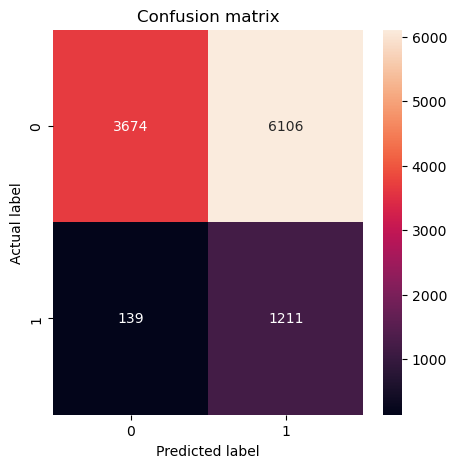

In [42]:
lfp = 1
lfn = 19
tau = lfp/(lfp+lfn)

# y_pred = decision_tree.predict(X_valid[feature_for_dt])
X_test = test[feature_for_nn]

testset  = TensorDataset(torch.from_numpy(X_test.copy().to_numpy()).float(), torch.from_numpy(y_test.to_numpy()).float())

y_prob = predict(mlp_no_class_balancing, testset[:][0]).numpy()

y_prob[y_prob < 1e-5] = 1e-5 # Log-loss returns NaN if too close to zero or one
y_prob[y_prob > 1- 1e-5] =  1- 1e-5

print('AUC score: ', roc_auc_score(y_test, y_prob))

y_pred = (y_prob > tau).astype(int)

plot_cm(y_test, y_pred)

In [43]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel() 

columns=['Cross-entropy', 'Error Rate', 'AUC', 'Sensitivity', 'Specificity', 'Precision', 'f1-score']

results = pd.DataFrame(0.0, columns=columns, index=['mlp'])

results.iloc[:,0] =  log_loss(y_test, y_prob)   # Cross entropy
results.iloc[:,1] =   1 - accuracy_score(y_test, y_pred)   # Error rate
results.iloc[:,2] =  roc_auc_score(y_test, y_prob)   # AUC
results.iloc[:,3] =  tp/(tp+fn)   # Sensitivity 
results.iloc[:,4] =  tn/(tn+fp)   # Specificity	
results.iloc[:,5] =  precision_score(y_test, y_pred)   # Precision
results.iloc[:,6] =  f1_score(y_test, y_pred)

In [44]:
display(results.sort_values(by=['AUC'], ascending = [0]).round(5))

,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,f1-score
mlp,0.29399,0.5611,0.79467,0.89704,0.37566,0.1655,0.27945


# class weight approach

In [45]:
from torch.utils.data import WeightedRandomSampler

In [46]:
column = train['y']
total = train['y'].count()
zero_count = column[column==0].count()
one_count = total - zero_count
one_count

2555

In [47]:
zero_weight = (1/zero_count) * (total / 2.0)
one_weight = (1/one_count) * (total / 2.0)

print(f'zero weight: {zero_weight}, one_weight: {one_weight}')

zero weight: 0.5701152579582875, one_weight: 4.0655577299412915


In [48]:
class_counts = train.y.value_counts()
class_counts

0    18220
1     2555
Name: y, dtype: int64

In [49]:
sample_weights = [1/class_counts[i] for i in train.y.values]
sample_weights[:5]

[5.48847420417124e-05,
 5.48847420417124e-05,
 0.0003913894324853229,
 0.0003913894324853229,
 5.48847420417124e-05]

In [50]:
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(y_train), replacement=True)

In [51]:
trainloader = DataLoader(trainset, batch_size = 1024, sampler=sampler)

In [52]:
for i, (data, target) in enumerate(trainloader):
    print("batch index {}, 0/1: {}/{}".format(
        i,
        len(np.where(target.numpy() == 0)[0]),
        len(np.where(target.numpy() == 1)[0])))

batch index 0, 0/1: 512/512
batch index 1, 0/1: 527/497
batch index 2, 0/1: 511/513
batch index 3, 0/1: 519/505
batch index 4, 0/1: 521/503
batch index 5, 0/1: 494/530
batch index 6, 0/1: 503/521
batch index 7, 0/1: 528/496
batch index 8, 0/1: 513/511
batch index 9, 0/1: 520/504
batch index 10, 0/1: 509/515
batch index 11, 0/1: 512/512
batch index 12, 0/1: 508/516
batch index 13, 0/1: 517/507
batch index 14, 0/1: 539/485
batch index 15, 0/1: 504/520
batch index 16, 0/1: 510/514
batch index 17, 0/1: 529/495
batch index 18, 0/1: 511/513
batch index 19, 0/1: 497/527
batch index 20, 0/1: 149/146


In [53]:
import time
trainloader = DataLoader(trainset, batch_size = 1024, shuffle=True)
def train_with_class_weight(model, input_size, trainloader, validset, trial=None, num_epochs = 5 , lr = 1e-3):
    
    # Get device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    if trial == None:
        # Instantiate model and move to device
        net = model(input_size).to(device)
    else:
        net = model(input_size, trial).to(device)
    
    # Loss function
    loss_fn = nn.BCELoss() # binary cross-entropy loss, assumes that the output of the network is a probability
    
    # Instantiate optimiser
    # Adam is a variant of SGD that often works well for training neural networks
    # https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
    optimiser = torch.optim.Adam(net.parameters(), lr = lr) 
    
    # Addding a learning rate scheduler to improve training
    # Adam + OneCycleLR is a good default for many problems
    # Learn more: https://sgugger.github.io/the-1cycle-policy.html
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimiser, max_lr = lr, 
                                                   steps_per_epoch=len(trainloader), epochs = num_epochs,
                                                   three_phase=True)
    # Number of training samples
    num_samples = len(trainloader.dataset)
    
    # Initialise table to track training
    table =  init_training_table(num_epochs)
    
    # Training loop
    print('Running first epoch')
    for epoch in range(num_epochs):
        
        # Make sure that the model is on training mode
        net.train()
        
        # Initialise timer
        epoch_start = time.time()
        
        # Initialise metric
        train_loss = 0.0
        
        # Iterate over minibatches
        for X, y in trainloader:

            # Move minibatch to device
            X_g = X.to(device)
            y_g = y.to(device)

            # Reset the gradient
            optimiser.zero_grad()

            # Compute predictions
            output = net(X_g)
            
#             print(output)
#             print(y_g)
            # Evaluate cost function
            loss = loss_fn(output, y_g)

            # Compute gradient 
            loss.backward()

            # Update parameters
            optimiser.step()
            
            # Update scheduler
            scheduler.step()
            
            # Keep track of the training loss
            l = loss.cpu().detach().numpy()
            train_loss +=  l*(len(y)/num_samples)
  
        # Epoch length
        duration = time.time() - epoch_start 
        
        # Display metrics
        if trial == None:
            table.iloc[epoch, 1] = np.round(10*train_loss, 3)
            table =  update_training_table(table, net, validset, epoch, duration)
    
    return net

In [54]:
len(X_train.columns)

55

In [55]:
 mlp_with_class_weights = train_with_class_weight(NeuralNetwork_No_Class_Balancing, len(feature_for_nn), trainloader, validset, num_epochs =200, lr = 3e-3)

epoch,train loss,valid loss,valid recall,valid average precision,time
1,161.350,88.245,1.000,0.085,00:00
2,65.127,39.750,1.000,0.086,00:00
3,25.860,12.355,1.000,0.088,00:00
4,6.747,3.819,1.000,0.208,00:00
5,3.746,3.861,1.000,0.213,00:00
6,3.870,3.887,1.000,0.364,00:00
7,3.753,3.713,1.000,0.400,00:00
8,3.700,3.714,1.000,0.402,00:00
9,3.669,3.688,1.000,0.405,00:00
10,3.650,3.664,1.000,0.404,00:00


AUC score:  0.5
(True Negatives):  0
(False Positives):  4549
(False Negatives):  0
(True Positives):  645
Total subscribed Transactions:  645
total loss from loss matrix: 4549


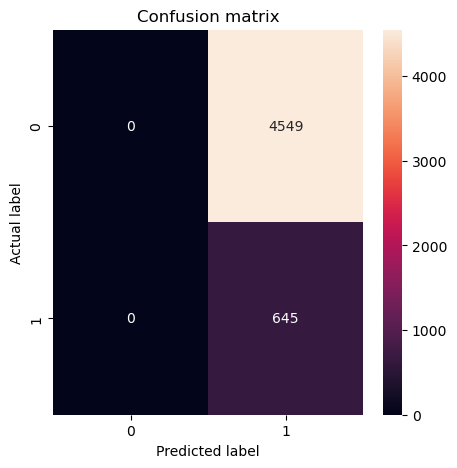

In [44]:
lfp = 1
lfn = 19
tau = lfp/(lfp+lfn)

# y_pred = decision_tree.predict(X_valid[feature_for_dt])

y_prob = predict(mlp_with_class_weights, validset[:][0]).numpy()

y_prob[y_prob < 1e-5] = 1e-5 # Log-loss returns NaN if too close to zero or one
y_prob[y_prob > 1- 1e-5] =  1- 1e-5

print('AUC score: ', roc_auc_score(y_valid, y_prob))

y_pred = (y_prob > tau).astype(int)
# y_pred = decision_tree.predict(valid[feature_for_dt])

plot_cm(y_valid, y_pred)

In [45]:
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score

def objective(trial):
       
    model = train_net(NeuralNetworkBuilder, len(feature_for_nn), trainloader, validset, trial=trial, num_epochs = 20, lr = 5e-3)
  
    lfp = 1
    lfn = 19
    tau = lfp/(lfp+lfn)

    # y_pred = decision_tree.predict(X_valid[feature_for_dt])

    y_prob = predict(model, validset[:][0]).numpy()
    roc = roc_auc_score(y_valid, y_prob)
    
    return roc

sampler = TPESampler(seed=42) 
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials = 1000, timeout = 2000) 

[I 2023-05-23 16:18:25,396] A new study created in memory with name: no-name-79c0ea8c-8d5f-4449-a717-4a7376e7ac0c


Running first epoch


[I 2023-05-23 16:18:29,404] Trial 0 finished with value: 0.7370252598322147 and parameters: {'num_layers': 2, 'activation_func_0': 'relu', 'num_neurons_0': 7, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 1}. Best is trial 0 with value: 0.7370252598322147.


Running first epoch


[I 2023-05-23 16:18:33,608] Trial 1 finished with value: 0.5 and parameters: {'num_layers': 5, 'activation_func_0': 'relu', 'num_neurons_0': 13, 'activation_func_1': 'sigmoid', 'num_neurons_1': 6, 'activation_func_2': 'sigmoid', 'num_neurons_2': 8, 'activation_func_3': 'sigmoid', 'num_neurons_3': 7, 'activation_func_4': 'tanh', 'num_neurons_4': 13}. Best is trial 0 with value: 0.7370252598322147.


Running first epoch


[I 2023-05-23 16:18:37,464] Trial 2 finished with value: 0.5 and parameters: {'num_layers': 1, 'activation_func_0': 'relu', 'num_neurons_0': 2}. Best is trial 0 with value: 0.7370252598322147.


Running first epoch


[I 2023-05-23 16:18:41,702] Trial 3 finished with value: 0.5947403041131794 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 22, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 36, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 2, 'activation_func_3': 'sigmoid', 'num_neurons_3': 15, 'activation_func_4': 'sigmoid', 'num_neurons_4': 3}. Best is trial 0 with value: 0.7370252598322147.


Running first epoch


[I 2023-05-23 16:18:45,927] Trial 4 finished with value: 0.5946639605603753 and parameters: {'num_layers': 5, 'activation_func_0': 'sigmoid', 'num_neurons_0': 29, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 5, 'activation_func_2': 'relu', 'num_neurons_2': 13, 'activation_func_3': 'sigmoid', 'num_neurons_3': 19, 'activation_func_4': 'tanh', 'num_neurons_4': 31}. Best is trial 0 with value: 0.7370252598322147.


Running first epoch


[I 2023-05-23 16:18:50,024] Trial 5 finished with value: 0.5 and parameters: {'num_layers': 3, 'activation_func_0': 'relu', 'num_neurons_0': 2, 'activation_func_1': 'sigmoid', 'num_neurons_1': 10, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 12}. Best is trial 0 with value: 0.7370252598322147.


Running first epoch


[I 2023-05-23 16:18:53,962] Trial 6 finished with value: 0.5 and parameters: {'num_layers': 1, 'activation_func_0': 'relu', 'num_neurons_0': 33}. Best is trial 0 with value: 0.7370252598322147.


Running first epoch


[I 2023-05-23 16:18:57,996] Trial 7 finished with value: 0.5 and parameters: {'num_layers': 1, 'activation_func_0': 'sigmoid', 'num_neurons_0': 13}. Best is trial 0 with value: 0.7370252598322147.


Running first epoch


[I 2023-05-23 16:19:01,827] Trial 8 finished with value: 0.4055940397497704 and parameters: {'num_layers': 1, 'activation_func_0': 'sigmoid', 'num_neurons_0': 1}. Best is trial 0 with value: 0.7370252598322147.


Running first epoch


[I 2023-05-23 16:19:06,015] Trial 9 finished with value: 0.5944059602502296 and parameters: {'num_layers': 3, 'activation_func_0': 'relu', 'num_neurons_0': 38, 'activation_func_1': 'tanh', 'num_neurons_1': 39, 'activation_func_2': 'relu', 'num_neurons_2': 12}. Best is trial 0 with value: 0.7370252598322147.


Running first epoch


[I 2023-05-23 16:19:09,973] Trial 10 finished with value: 0.5944059602502296 and parameters: {'num_layers': 2, 'activation_func_0': 'tanh', 'num_neurons_0': 13, 'activation_func_1': 'relu', 'num_neurons_1': 21}. Best is trial 0 with value: 0.7370252598322147.


Running first epoch


[I 2023-05-23 16:19:14,380] Trial 11 finished with value: 0.5944059602502296 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 22, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 37, 'activation_func_2': 'tanh', 'num_neurons_2': 35, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 38}. Best is trial 0 with value: 0.7370252598322147.


Running first epoch


[I 2023-05-23 16:19:18,700] Trial 12 finished with value: 0.7505447146574509 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 22, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 25, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 28, 'activation_func_3': 'relu', 'num_neurons_3': 3}. Best is trial 12 with value: 0.7505447146574509.


Running first epoch


[I 2023-05-23 16:19:22,994] Trial 13 finished with value: 0.7525637289735712 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 17, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 23, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 31, 'activation_func_3': 'relu', 'num_neurons_3': 1}. Best is trial 13 with value: 0.7525637289735712.


Running first epoch


[I 2023-05-23 16:19:27,112] Trial 14 finished with value: 0.7565170639769196 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 28, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 24, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 32, 'activation_func_3': 'relu', 'num_neurons_3': 2}. Best is trial 14 with value: 0.7565170639769196.


Running first epoch


[I 2023-05-23 16:19:31,297] Trial 15 finished with value: 0.5 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 28, 'activation_func_1': 'relu', 'num_neurons_1': 27, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 39, 'activation_func_3': 'relu', 'num_neurons_3': 1}. Best is trial 14 with value: 0.7565170639769196.


Running first epoch


[I 2023-05-23 16:19:35,679] Trial 16 finished with value: 0.5943691517515562 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 17, 'activation_func_1': 'tanh', 'num_neurons_1': 13, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 26, 'activation_func_3': 'relu', 'num_neurons_3': 11}. Best is trial 14 with value: 0.7565170639769196.


Running first epoch


[I 2023-05-23 16:19:39,803] Trial 17 finished with value: 0.5944059602502296 and parameters: {'num_layers': 3, 'activation_func_0': 'tanh', 'num_neurons_0': 28, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 29, 'activation_func_2': 'sigmoid', 'num_neurons_2': 29}. Best is trial 14 with value: 0.7565170639769196.


Running first epoch


[I 2023-05-23 16:19:44,287] Trial 18 finished with value: 0.5 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 40, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 18, 'activation_func_2': 'tanh', 'num_neurons_2': 20, 'activation_func_3': 'tanh', 'num_neurons_3': 27}. Best is trial 14 with value: 0.7565170639769196.


Running first epoch


[I 2023-05-23 16:19:48,492] Trial 19 finished with value: 0.5396173620235132 and parameters: {'num_layers': 2, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 34, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 32}. Best is trial 14 with value: 0.7565170639769196.


Running first epoch


[I 2023-05-23 16:19:52,896] Trial 20 finished with value: 0.5 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 18, 'activation_func_1': 'tanh', 'num_neurons_1': 18, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 33, 'activation_func_3': 'relu', 'num_neurons_3': 27, 'activation_func_4': 'relu', 'num_neurons_4': 39}. Best is trial 14 with value: 0.7565170639769196.


Running first epoch


[I 2023-05-23 16:19:57,107] Trial 21 finished with value: 0.5 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 25, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 24, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 25, 'activation_func_3': 'relu', 'num_neurons_3': 1}. Best is trial 14 with value: 0.7565170639769196.


Running first epoch


[I 2023-05-23 16:20:01,449] Trial 22 finished with value: 0.7573094691566935 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 18, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 23, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 31, 'activation_func_3': 'relu', 'num_neurons_3': 6}. Best is trial 22 with value: 0.7573094691566935.


Running first epoch


[I 2023-05-23 16:20:05,774] Trial 23 finished with value: 0.7514487382012573 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 18, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 21, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 40}. Best is trial 22 with value: 0.7573094691566935.


Running first epoch


[I 2023-05-23 16:20:10,165] Trial 24 finished with value: 0.5 and parameters: {'num_layers': 4, 'activation_func_0': 'tanh', 'num_neurons_0': 8, 'activation_func_1': 'relu', 'num_neurons_1': 15, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 34, 'activation_func_3': 'relu', 'num_neurons_3': 9}. Best is trial 22 with value: 0.7573094691566935.


Running first epoch


[I 2023-05-23 16:20:14,313] Trial 25 finished with value: 0.5913873225395819 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 25, 'activation_func_1': 'sigmoid', 'num_neurons_1': 31, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 21}. Best is trial 22 with value: 0.7573094691566935.


Running first epoch


[I 2023-05-23 16:20:18,730] Trial 26 finished with value: 0.5 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 16, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 24, 'activation_func_2': 'tanh', 'num_neurons_2': 32, 'activation_func_3': 'relu', 'num_neurons_3': 7, 'activation_func_4': 'leakyrelu', 'num_neurons_4': 19}. Best is trial 22 with value: 0.7573094691566935.


Running first epoch


[I 2023-05-23 16:20:22,961] Trial 27 finished with value: 0.5545019690842693 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 8, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 18, 'activation_func_2': 'sigmoid', 'num_neurons_2': 22, 'activation_func_3': 'tanh', 'num_neurons_3': 5}. Best is trial 22 with value: 0.7573094691566935.


Running first epoch


[I 2023-05-23 16:20:27,009] Trial 28 finished with value: 0.5 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 31, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 32, 'activation_func_2': 'relu', 'num_neurons_2': 37}. Best is trial 22 with value: 0.7573094691566935.


Running first epoch


[I 2023-05-23 16:20:31,244] Trial 29 finished with value: 0.5944059602502296 and parameters: {'num_layers': 4, 'activation_func_0': 'sigmoid', 'num_neurons_0': 25, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 28, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 30, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 13}. Best is trial 22 with value: 0.7573094691566935.


Running first epoch


[I 2023-05-23 16:20:35,613] Trial 30 finished with value: 0.5944059602502296 and parameters: {'num_layers': 5, 'activation_func_0': 'tanh', 'num_neurons_0': 11, 'activation_func_1': 'relu', 'num_neurons_1': 23, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 24, 'activation_func_3': 'relu', 'num_neurons_3': 1, 'activation_func_4': 'leakyrelu', 'num_neurons_4': 1}. Best is trial 22 with value: 0.7573094691566935.


Running first epoch


[I 2023-05-23 16:20:39,872] Trial 31 finished with value: 0.5 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 20, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 21, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 40}. Best is trial 22 with value: 0.7573094691566935.


Running first epoch


[I 2023-05-23 16:20:43,910] Trial 32 finished with value: 0.7523410034746542 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 15, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 20, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 37}. Best is trial 22 with value: 0.7573094691566935.


Running first epoch


[I 2023-05-23 16:20:47,878] Trial 33 finished with value: 0.758059271907447 and parameters: {'num_layers': 2, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 14, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 15}. Best is trial 33 with value: 0.758059271907447.


Running first epoch


[I 2023-05-23 16:20:51,884] Trial 34 finished with value: 0.7539421731669452 and parameters: {'num_layers': 2, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 10, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 15}. Best is trial 33 with value: 0.758059271907447.


Running first epoch


[I 2023-05-23 16:20:56,001] Trial 35 finished with value: 0.5 and parameters: {'num_layers': 2, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 10, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 14}. Best is trial 33 with value: 0.758059271907447.


Running first epoch


[I 2023-05-23 16:21:00,001] Trial 36 finished with value: 0.5946455563110387 and parameters: {'num_layers': 2, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 5, 'activation_func_1': 'sigmoid', 'num_neurons_1': 10}. Best is trial 33 with value: 0.758059271907447.


Running first epoch


[I 2023-05-23 16:21:04,003] Trial 37 finished with value: 0.5 and parameters: {'num_layers': 2, 'activation_func_0': 'relu', 'num_neurons_0': 5, 'activation_func_1': 'tanh', 'num_neurons_1': 11}. Best is trial 33 with value: 0.758059271907447.


Running first epoch


[I 2023-05-23 16:21:07,947] Trial 38 finished with value: 0.5 and parameters: {'num_layers': 1, 'activation_func_0': 'sigmoid', 'num_neurons_0': 14}. Best is trial 33 with value: 0.758059271907447.


Running first epoch


[I 2023-05-23 16:21:11,904] Trial 39 finished with value: 0.7496003040109336 and parameters: {'num_layers': 2, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 10, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 8}. Best is trial 33 with value: 0.758059271907447.


Running first epoch


[I 2023-05-23 16:21:15,840] Trial 40 finished with value: 0.7674936650188047 and parameters: {'num_layers': 1, 'activation_func_0': 'relu', 'num_neurons_0': 12}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:21:19,692] Trial 41 finished with value: 0.5 and parameters: {'num_layers': 1, 'activation_func_0': 'relu', 'num_neurons_0': 12}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:21:23,700] Trial 42 finished with value: 0.5512757723394357 and parameters: {'num_layers': 1, 'activation_func_0': 'relu', 'num_neurons_0': 5}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:21:27,787] Trial 43 finished with value: 0.5 and parameters: {'num_layers': 1, 'activation_func_0': 'relu', 'num_neurons_0': 20}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:21:32,041] Trial 44 finished with value: 0.5024165801837358 and parameters: {'num_layers': 2, 'activation_func_0': 'relu', 'num_neurons_0': 14, 'activation_func_1': 'sigmoid', 'num_neurons_1': 16}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:21:35,909] Trial 45 finished with value: 0.5 and parameters: {'num_layers': 1, 'activation_func_0': 'relu', 'num_neurons_0': 9}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:21:39,888] Trial 46 finished with value: 0.5944059602502296 and parameters: {'num_layers': 2, 'activation_func_0': 'sigmoid', 'num_neurons_0': 12, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 7}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:21:44,252] Trial 47 finished with value: 0.47964950129596595 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 23, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 2, 'activation_func_2': 'tanh', 'num_neurons_2': 17}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:21:48,314] Trial 48 finished with value: 0.5 and parameters: {'num_layers': 1, 'activation_func_0': 'tanh', 'num_neurons_0': 3}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:21:52,509] Trial 49 finished with value: 0.743571378665726 and parameters: {'num_layers': 2, 'activation_func_0': 'relu', 'num_neurons_0': 7, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 12}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:21:57,093] Trial 50 finished with value: 0.5 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 35, 'activation_func_1': 'tanh', 'num_neurons_1': 4, 'activation_func_2': 'relu', 'num_neurons_2': 28, 'activation_func_3': 'tanh', 'num_neurons_3': 20, 'activation_func_4': 'sigmoid', 'num_neurons_4': 29}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:22:01,494] Trial 51 finished with value: 0.5 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 18, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 26, 'activation_func_2': 'sigmoid', 'num_neurons_2': 31, 'activation_func_3': 'relu', 'num_neurons_3': 6}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:22:06,007] Trial 52 finished with value: 0.48298799804369646 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 16, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 16, 'activation_func_2': 'sigmoid', 'num_neurons_2': 36, 'activation_func_3': 'relu', 'num_neurons_3': 16}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:22:10,580] Trial 53 finished with value: 0.7536083405331439 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 19, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 23, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 17, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 11}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:22:14,746] Trial 54 finished with value: 0.7557294302691964 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 19, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 19, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 3}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:22:18,998] Trial 55 finished with value: 0.7560451994730932 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 14, 'activation_func_1': 'relu', 'num_neurons_1': 19, 'activation_func_2': 'relu', 'num_neurons_2': 7}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:22:23,206] Trial 56 finished with value: 0.5 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 23, 'activation_func_1': 'relu', 'num_neurons_1': 19, 'activation_func_2': 'relu', 'num_neurons_2': 2}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:22:27,339] Trial 57 finished with value: 0.5 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 15, 'activation_func_1': 'relu', 'num_neurons_1': 26, 'activation_func_2': 'relu', 'num_neurons_2': 5}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:22:31,519] Trial 58 finished with value: 0.5 and parameters: {'num_layers': 3, 'activation_func_0': 'sigmoid', 'num_neurons_0': 21, 'activation_func_1': 'relu', 'num_neurons_1': 22, 'activation_func_2': 'relu', 'num_neurons_2': 8}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:22:35,684] Trial 59 finished with value: 0.5 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 13, 'activation_func_1': 'relu', 'num_neurons_1': 17, 'activation_func_2': 'relu', 'num_neurons_2': 8}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:22:39,876] Trial 60 finished with value: 0.5 and parameters: {'num_layers': 3, 'activation_func_0': 'tanh', 'num_neurons_0': 30, 'activation_func_1': 'sigmoid', 'num_neurons_1': 30, 'activation_func_2': 'relu', 'num_neurons_2': 2}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:22:44,185] Trial 61 finished with value: 0.5947442235366491 and parameters: {'num_layers': 2, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 16, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 20}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:22:48,291] Trial 62 finished with value: 0.7513708609610086 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 11, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 14, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 5, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 24}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:22:52,538] Trial 63 finished with value: 0.5944059602502296 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 14, 'activation_func_1': 'relu', 'num_neurons_1': 19, 'activation_func_2': 'tanh', 'num_neurons_2': 14}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:22:56,713] Trial 64 finished with value: 0.5 and parameters: {'num_layers': 2, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 19, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 16}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:23:00,796] Trial 65 finished with value: 0.5 and parameters: {'num_layers': 2, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 15, 'activation_func_1': 'tanh', 'num_neurons_1': 13}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:23:05,095] Trial 66 finished with value: 0.7508059527522022 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 26, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 22, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 10, 'activation_func_3': 'sigmoid', 'num_neurons_3': 40}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:23:09,145] Trial 67 finished with value: 0.5 and parameters: {'num_layers': 1, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 17}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:23:13,513] Trial 68 finished with value: 0.5518817492898176 and parameters: {'num_layers': 5, 'activation_func_0': 'relu', 'num_neurons_0': 12, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 25, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 4, 'activation_func_3': 'tanh', 'num_neurons_3': 15, 'activation_func_4': 'relu', 'num_neurons_4': 12}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:23:17,776] Trial 69 finished with value: 0.5 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 9, 'activation_func_1': 'relu', 'num_neurons_1': 35, 'activation_func_2': 'relu', 'num_neurons_2': 1}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:23:21,974] Trial 70 finished with value: 0.53148183176812 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 22, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 18, 'activation_func_2': 'sigmoid', 'num_neurons_2': 10, 'activation_func_3': 'relu', 'num_neurons_3': 34}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:23:26,066] Trial 71 finished with value: 0.7600571554187733 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 19, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 24, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 16, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 10}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:23:30,518] Trial 72 finished with value: 0.7527099405099681 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 19, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 28, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 15, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 9}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:23:34,749] Trial 73 finished with value: 0.7436671489261631 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 17, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 24, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 6, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 4}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:23:39,047] Trial 74 finished with value: 0.7470811371781174 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 21, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 22, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 12, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 9, 'activation_func_4': 'leakyrelu', 'num_neurons_4': 39}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:23:43,347] Trial 75 finished with value: 0.5149900906750099 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 13, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 19, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 18, 'activation_func_3': 'sigmoid', 'num_neurons_3': 5}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:23:47,654] Trial 76 finished with value: 0.5 and parameters: {'num_layers': 3, 'activation_func_0': 'tanh', 'num_neurons_0': 11, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 17, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 23}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:23:51,792] Trial 77 finished with value: 0.5944059602502296 and parameters: {'num_layers': 2, 'activation_func_0': 'sigmoid', 'num_neurons_0': 15, 'activation_func_1': 'sigmoid', 'num_neurons_1': 21}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:23:56,082] Trial 78 finished with value: 0.7369455080850891 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 18, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 15, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 7}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:24:00,288] Trial 79 finished with value: 0.5 and parameters: {'num_layers': 1, 'activation_func_0': 'relu', 'num_neurons_0': 26}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:24:04,891] Trial 80 finished with value: 0.5944059602502296 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 24, 'activation_func_1': 'tanh', 'num_neurons_1': 25, 'activation_func_2': 'tanh', 'num_neurons_2': 3, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 17}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:24:09,299] Trial 81 finished with value: 0.7461508705380346 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 19, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 23, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 18, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 12}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:24:13,528] Trial 82 finished with value: 0.7466206901252681 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 20, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 27, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 26, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 9}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:24:17,887] Trial 83 finished with value: 0.7444016148024696 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 37, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 20, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 11, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 13}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:24:22,072] Trial 84 finished with value: 0.5944993447746417 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 17, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 22, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 16, 'activation_func_3': 'sigmoid', 'num_neurons_3': 7}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:24:26,399] Trial 85 finished with value: 0.741627344624681 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 16, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 24, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 19, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 18, 'activation_func_4': 'relu', 'num_neurons_4': 27}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:24:30,788] Trial 86 finished with value: 0.7577934327503616 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 10, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 17, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 21, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 11}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:24:35,092] Trial 87 finished with value: 0.5 and parameters: {'num_layers': 3, 'activation_func_0': 'relu', 'num_neurons_0': 9, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 14, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 33}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:24:38,926] Trial 88 finished with value: 0.7442448378636757 and parameters: {'num_layers': 1, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 6}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:24:43,149] Trial 89 finished with value: 0.5 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 10, 'activation_func_1': 'relu', 'num_neurons_1': 17, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 29, 'activation_func_3': 'sigmoid', 'num_neurons_3': 3}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:24:47,259] Trial 90 finished with value: 0.7562715035760479 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 14, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 11, 'activation_func_2': 'relu', 'num_neurons_2': 28}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:24:51,397] Trial 91 finished with value: 0.6781648918494737 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 12, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 9, 'activation_func_2': 'relu', 'num_neurons_2': 34}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:24:55,449] Trial 92 finished with value: 0.75904952276759 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 14, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 12, 'activation_func_2': 'relu', 'num_neurons_2': 26}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:24:59,563] Trial 93 finished with value: 0.7505181307417423 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 14, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 11, 'activation_func_2': 'relu', 'num_neurons_2': 28}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:25:03,660] Trial 94 finished with value: 0.7545962056572618 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 11, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 12, 'activation_func_2': 'relu', 'num_neurons_2': 26}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:25:07,996] Trial 95 finished with value: 0.5944059602502296 and parameters: {'num_layers': 3, 'activation_func_0': 'tanh', 'num_neurons_0': 32, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 10, 'activation_func_2': 'relu', 'num_neurons_2': 21}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:25:12,063] Trial 96 finished with value: 0.7581722535492084 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 14, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 6, 'activation_func_2': 'relu', 'num_neurons_2': 30}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:25:16,227] Trial 97 finished with value: 0.5 and parameters: {'num_layers': 3, 'activation_func_0': 'sigmoid', 'num_neurons_0': 13, 'activation_func_1': 'sigmoid', 'num_neurons_1': 5, 'activation_func_2': 'relu', 'num_neurons_2': 31}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:25:20,522] Trial 98 finished with value: 0.7488854352519763 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 14, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 7, 'activation_func_2': 'relu', 'num_neurons_2': 27, 'activation_func_3': 'relu', 'num_neurons_3': 3}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:25:24,600] Trial 99 finished with value: 0.7488511828990443 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 15, 'activation_func_1': 'relu', 'num_neurons_1': 4, 'activation_func_2': 'relu', 'num_neurons_2': 30}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:25:28,657] Trial 100 finished with value: 0.7488971935223858 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 8, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 9, 'activation_func_2': 'relu', 'num_neurons_2': 25}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:25:32,788] Trial 101 finished with value: 0.7581172112109142 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 12, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 2, 'activation_func_2': 'relu', 'num_neurons_2': 32}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:25:36,949] Trial 102 finished with value: 0.7508218008557975 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 12, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 2, 'activation_func_2': 'relu', 'num_neurons_2': 32}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:25:41,304] Trial 103 finished with value: 0.758283871913241 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 13, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 1, 'activation_func_2': 'relu', 'num_neurons_2': 29}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:25:45,533] Trial 104 finished with value: 0.7573542869120226 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 13, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 6, 'activation_func_2': 'relu', 'num_neurons_2': 29}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:25:49,750] Trial 105 finished with value: 0.7568297658059271 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 11, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 2, 'activation_func_2': 'relu', 'num_neurons_2': 30, 'activation_func_3': 'relu', 'num_neurons_3': 14}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:25:53,837] Trial 106 finished with value: 0.7631327099745918 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 11, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 2, 'activation_func_2': 'relu', 'num_neurons_2': 29}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:25:58,232] Trial 107 finished with value: 0.5 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 13, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 1, 'activation_func_2': 'relu', 'num_neurons_2': 23}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:26:02,442] Trial 108 finished with value: 0.7520976584000914 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 9, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 4, 'activation_func_2': 'relu', 'num_neurons_2': 29}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:26:06,635] Trial 109 finished with value: 0.5 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 10, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 3, 'activation_func_2': 'relu', 'num_neurons_2': 33}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:26:10,938] Trial 110 finished with value: 0.5 and parameters: {'num_layers': 3, 'activation_func_0': 'relu', 'num_neurons_0': 7, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 6, 'activation_func_2': 'relu', 'num_neurons_2': 35}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:26:15,300] Trial 111 finished with value: 0.7606174625652455 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 11, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 1, 'activation_func_2': 'relu', 'num_neurons_2': 30, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 15}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:26:19,473] Trial 112 finished with value: 0.7243832446350761 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 12, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 3, 'activation_func_2': 'relu', 'num_neurons_2': 27}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:26:23,786] Trial 113 finished with value: 0.755654961223269 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 16, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 1, 'activation_func_2': 'relu', 'num_neurons_2': 31, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 20}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:26:27,906] Trial 114 finished with value: 0.7396309948007995 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 13, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 1, 'activation_func_2': 'sigmoid', 'num_neurons_2': 30}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:26:31,952] Trial 115 finished with value: 0.5944059602502296 and parameters: {'num_layers': 2, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 10, 'activation_func_1': 'tanh', 'num_neurons_1': 6}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:26:36,201] Trial 116 finished with value: 0.7528276936237797 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 11, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 3, 'activation_func_2': 'relu', 'num_neurons_2': 27}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:26:40,741] Trial 117 finished with value: 0.7568163034383568 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 15, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 5, 'activation_func_2': 'relu', 'num_neurons_2': 32, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 11}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:26:45,080] Trial 118 finished with value: 0.5 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 13, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 7, 'activation_func_2': 'tanh', 'num_neurons_2': 29}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:26:49,380] Trial 119 finished with value: 0.5 and parameters: {'num_layers': 4, 'activation_func_0': 'tanh', 'num_neurons_0': 11, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 5, 'activation_func_2': 'relu', 'num_neurons_2': 24, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 22}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:26:53,460] Trial 120 finished with value: 0.5944059602502296 and parameters: {'num_layers': 3, 'activation_func_0': 'sigmoid', 'num_neurons_0': 12, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 2, 'activation_func_2': 'relu', 'num_neurons_2': 34}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:26:57,763] Trial 121 finished with value: 0.7396841626322166 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 8, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 2, 'activation_func_2': 'relu', 'num_neurons_2': 32, 'activation_func_3': 'relu', 'num_neurons_3': 15}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:27:02,056] Trial 122 finished with value: 0.7537501214169227 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 11, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 3, 'activation_func_2': 'relu', 'num_neurons_2': 30, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 14}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:27:06,205] Trial 123 finished with value: 0.7490515847251547 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 9, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 1, 'activation_func_2': 'relu', 'num_neurons_2': 28, 'activation_func_3': 'tanh', 'num_neurons_3': 18}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:27:10,411] Trial 124 finished with value: 0.7594714572246052 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 13, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 2, 'activation_func_2': 'relu', 'num_neurons_2': 31, 'activation_func_3': 'relu', 'num_neurons_3': 10}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:27:14,765] Trial 125 finished with value: 0.7380976481755084 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 17, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 4, 'activation_func_2': 'relu', 'num_neurons_2': 31, 'activation_func_3': 'relu', 'num_neurons_3': 8}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:27:19,051] Trial 126 finished with value: 0.5 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 15, 'activation_func_1': 'sigmoid', 'num_neurons_1': 1, 'activation_func_2': 'relu', 'num_neurons_2': 35, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 10}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:27:23,104] Trial 127 finished with value: 0.7079530214494709 and parameters: {'num_layers': 3, 'activation_func_0': 'relu', 'num_neurons_0': 12, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 3, 'activation_func_2': 'sigmoid', 'num_neurons_2': 33}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:27:27,351] Trial 128 finished with value: 0.5 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 10, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 8, 'activation_func_2': 'relu', 'num_neurons_2': 29, 'activation_func_3': 'relu', 'num_neurons_3': 7}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:27:31,733] Trial 129 finished with value: 0.7607413504288361 and parameters: {'num_layers': 2, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 13, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 4}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:27:35,683] Trial 130 finished with value: 0.5 and parameters: {'num_layers': 2, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 13, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 6}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:27:39,561] Trial 131 finished with value: 0.5 and parameters: {'num_layers': 1, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 14}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:27:43,551] Trial 132 finished with value: 0.5 and parameters: {'num_layers': 2, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 12, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 4}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:27:47,671] Trial 133 finished with value: 0.7361972390217801 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 16, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 2, 'activation_func_2': 'tanh', 'num_neurons_2': 25}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:27:51,864] Trial 134 finished with value: 0.5 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 14, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 5, 'activation_func_2': 'relu', 'num_neurons_2': 27, 'activation_func_3': 'tanh', 'num_neurons_3': 11}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:27:55,960] Trial 135 finished with value: 0.6145180557614673 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 18, 'activation_func_1': 'tanh', 'num_neurons_1': 4, 'activation_func_2': 'relu', 'num_neurons_2': 38}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:27:59,958] Trial 136 finished with value: 0.7479251765018634 and parameters: {'num_layers': 2, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 13, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 2}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:28:03,913] Trial 137 finished with value: 0.5 and parameters: {'num_layers': 1, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 15}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:28:08,032] Trial 138 finished with value: 0.7576398935961732 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 12, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 3, 'activation_func_2': 'relu', 'num_neurons_2': 20}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:28:12,163] Trial 139 finished with value: 0.7358973179214786 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 11, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 3, 'activation_func_2': 'relu', 'num_neurons_2': 19}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:28:16,200] Trial 140 finished with value: 0.5 and parameters: {'num_layers': 3, 'activation_func_0': 'relu', 'num_neurons_0': 10, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 1, 'activation_func_2': 'relu', 'num_neurons_2': 14}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:28:20,376] Trial 141 finished with value: 0.7291639188099949 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 12, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 6, 'activation_func_2': 'relu', 'num_neurons_2': 21}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:28:24,480] Trial 142 finished with value: 0.7405498439899049 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 13, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 3, 'activation_func_2': 'relu', 'num_neurons_2': 31}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:28:28,565] Trial 143 finished with value: 0.5947912566182874 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 14, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 5, 'activation_func_2': 'relu', 'num_neurons_2': 23}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:28:32,750] Trial 144 finished with value: 0.7431741536175427 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 9, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 13, 'activation_func_2': 'relu', 'num_neurons_2': 16, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 5}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:28:37,211] Trial 145 finished with value: 0.763190138048911 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 11, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 8, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 20}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:28:41,404] Trial 146 finished with value: 0.7204730232898959 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 11, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 8, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 22}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:28:45,555] Trial 147 finished with value: 0.7513500709756468 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 10, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 7, 'activation_func_2': 'relu', 'num_neurons_2': 20}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:28:49,620] Trial 148 finished with value: 0.6541255340214478 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 12, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 15, 'activation_func_2': 'sigmoid', 'num_neurons_2': 18}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:28:53,814] Trial 149 finished with value: 0.5 and parameters: {'num_layers': 3, 'activation_func_0': 'tanh', 'num_neurons_0': 8, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 4, 'activation_func_2': 'relu', 'num_neurons_2': 26}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:28:57,932] Trial 150 finished with value: 0.5 and parameters: {'num_layers': 3, 'activation_func_0': 'sigmoid', 'num_neurons_0': 13, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 9, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 29}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:29:01,945] Trial 151 finished with value: 0.7400650283476563 and parameters: {'num_layers': 2, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 14, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 39}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:29:06,272] Trial 152 finished with value: 0.7414191039516309 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 15, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 2, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 19, 'activation_func_3': 'relu', 'num_neurons_3': 13}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:29:10,462] Trial 153 finished with value: 0.5 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 11, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 1, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 32, 'activation_func_3': 'sigmoid', 'num_neurons_3': 22}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:29:14,641] Trial 154 finished with value: 0.5 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 13, 'activation_func_1': 'sigmoid', 'num_neurons_1': 3, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 30, 'activation_func_3': 'relu', 'num_neurons_3': 34}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:29:18,915] Trial 155 finished with value: 0.6664993243254758 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 12, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 5, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 28, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 16, 'activation_func_4': 'sigmoid', 'num_neurons_4': 9}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:29:22,956] Trial 156 finished with value: 0.5442581298215299 and parameters: {'num_layers': 1, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 16}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:29:26,878] Trial 157 finished with value: 0.5 and parameters: {'num_layers': 2, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 9, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 12}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:29:30,978] Trial 158 finished with value: 0.7535916403809679 and parameters: {'num_layers': 3, 'activation_func_0': 'relu', 'num_neurons_0': 10, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 26, 'activation_func_2': 'relu', 'num_neurons_2': 31}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:29:35,068] Trial 159 finished with value: 0.5944201042566644 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 12, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 6, 'activation_func_2': 'tanh', 'num_neurons_2': 24}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:29:39,284] Trial 160 finished with value: 0.744539987491927 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 13, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 10, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 22, 'activation_func_3': 'relu', 'num_neurons_3': 6}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:29:43,527] Trial 161 finished with value: 0.7594494743712307 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 11, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 2, 'activation_func_2': 'relu', 'num_neurons_2': 30, 'activation_func_3': 'relu', 'num_neurons_3': 14}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:29:47,765] Trial 162 finished with value: 0.7555876493854172 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 11, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 1, 'activation_func_2': 'relu', 'num_neurons_2': 29, 'activation_func_3': 'relu', 'num_neurons_3': 12}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:29:51,925] Trial 163 finished with value: 0.7586430955947383 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 14, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 2, 'activation_func_2': 'relu', 'num_neurons_2': 33, 'activation_func_3': 'relu', 'num_neurons_3': 10}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:29:56,127] Trial 164 finished with value: 0.7388593796063876 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 14, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 2, 'activation_func_2': 'relu', 'num_neurons_2': 33}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:30:00,571] Trial 165 finished with value: 0.7509056424361091 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 11, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 4, 'activation_func_2': 'relu', 'num_neurons_2': 20, 'activation_func_3': 'relu', 'num_neurons_3': 10}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:30:04,725] Trial 166 finished with value: 0.5 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 13, 'activation_func_1': 'tanh', 'num_neurons_1': 2, 'activation_func_2': 'relu', 'num_neurons_2': 17}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:30:08,931] Trial 167 finished with value: 0.7523612822308677 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 12, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 3, 'activation_func_2': 'relu', 'num_neurons_2': 30, 'activation_func_3': 'relu', 'num_neurons_3': 16}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:30:13,345] Trial 168 finished with value: 0.7563412011499248 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 14, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 1, 'activation_func_2': 'relu', 'num_neurons_2': 34}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:30:17,747] Trial 169 finished with value: 0.5825536236774076 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 15, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 7, 'activation_func_2': 'relu', 'num_neurons_2': 32, 'activation_func_3': 'tanh', 'num_neurons_3': 12}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:30:21,969] Trial 170 finished with value: 0.5 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 12, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 4, 'activation_func_2': 'relu', 'num_neurons_2': 36}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:30:26,368] Trial 171 finished with value: 0.750216164724848 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 10, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 23, 'activation_func_2': 'relu', 'num_neurons_2': 31, 'activation_func_3': 'relu', 'num_neurons_3': 8}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:30:30,856] Trial 172 finished with value: 0.7147818500019596 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 17, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 2, 'activation_func_2': 'relu', 'num_neurons_2': 28, 'activation_func_3': 'relu', 'num_neurons_3': 10}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:30:35,189] Trial 173 finished with value: 0.7332847665642505 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 21, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 3, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 33, 'activation_func_3': 'relu', 'num_neurons_3': 14}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:30:39,551] Trial 174 finished with value: 0.7565376835525653 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 13, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 5, 'activation_func_2': 'relu', 'num_neurons_2': 29, 'activation_func_3': 'relu', 'num_neurons_3': 8}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:30:43,949] Trial 175 finished with value: 0.7356086438624385 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 10, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 1, 'activation_func_2': 'relu', 'num_neurons_2': 30, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 6}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:30:48,279] Trial 176 finished with value: 0.7528375773873122 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 14, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 16, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 31, 'activation_func_3': 'relu', 'num_neurons_3': 12}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:30:52,430] Trial 177 finished with value: 0.46654942478200334 and parameters: {'num_layers': 2, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 20, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 2}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:30:56,883] Trial 178 finished with value: 0.7589765874091078 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 12, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 3, 'activation_func_2': 'relu', 'num_neurons_2': 32, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 17}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:31:01,334] Trial 179 finished with value: 0.7432545870035326 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 12, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 4, 'activation_func_2': 'relu', 'num_neurons_2': 32}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:31:05,616] Trial 180 finished with value: 0.5 and parameters: {'num_layers': 3, 'activation_func_0': 'tanh', 'num_neurons_0': 11, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 3, 'activation_func_2': 'relu', 'num_neurons_2': 34}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:31:09,992] Trial 181 finished with value: 0.7583019353431455 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 13, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 2, 'activation_func_2': 'relu', 'num_neurons_2': 27, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 18}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:31:14,317] Trial 182 finished with value: 0.5 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 13, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 2, 'activation_func_2': 'relu', 'num_neurons_2': 27, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 21}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:31:18,686] Trial 183 finished with value: 0.7541761457071237 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 12, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 1, 'activation_func_2': 'relu', 'num_neurons_2': 26, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 18}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:31:22,891] Trial 184 finished with value: 0.7540892367519226 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 11, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 3, 'activation_func_2': 'relu', 'num_neurons_2': 13, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 17}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:31:27,379] Trial 185 finished with value: 0.7560465627508218 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 14, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 4, 'activation_func_2': 'relu', 'num_neurons_2': 28, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 19}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:31:31,612] Trial 186 finished with value: 0.5 and parameters: {'num_layers': 3, 'activation_func_0': 'sigmoid', 'num_neurons_0': 12, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 2, 'activation_func_2': 'relu', 'num_neurons_2': 30}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:31:35,959] Trial 187 finished with value: 0.7589355186675324 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 13, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 14, 'activation_func_2': 'relu', 'num_neurons_2': 29, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 15}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:31:40,464] Trial 188 finished with value: 0.5944059602502296 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 15, 'activation_func_1': 'sigmoid', 'num_neurons_1': 16, 'activation_func_2': 'relu', 'num_neurons_2': 27, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 16}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:31:44,563] Trial 189 finished with value: 0.5 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 14, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 14, 'activation_func_2': 'relu', 'num_neurons_2': 32, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 13}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:31:48,823] Trial 190 finished with value: 0.46122923344597416 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 11, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 13, 'activation_func_2': 'sigmoid', 'num_neurons_2': 30, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 15}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:31:53,261] Trial 191 finished with value: 0.761907464115974 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 13, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 15, 'activation_func_2': 'relu', 'num_neurons_2': 31, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 25}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:31:57,567] Trial 192 finished with value: 0.7484370872889688 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 13, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 16, 'activation_func_2': 'relu', 'num_neurons_2': 31, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 25}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:32:01,914] Trial 193 finished with value: 0.7564719054021584 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 12, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 15, 'activation_func_2': 'relu', 'num_neurons_2': 29, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 19}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:32:06,122] Trial 194 finished with value: 0.7580028662914244 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 13, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 15, 'activation_func_2': 'relu', 'num_neurons_2': 33, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 29}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:32:10,189] Trial 195 finished with value: 0.7379454722990487 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 15, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 14, 'activation_func_2': 'relu', 'num_neurons_2': 33, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 32}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:32:14,565] Trial 196 finished with value: 0.7548991941324527 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 13, 'activation_func_1': 'relu', 'num_neurons_1': 14, 'activation_func_2': 'relu', 'num_neurons_2': 35, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 27}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:32:18,932] Trial 197 finished with value: 0.7395129008675558 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 14, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 17, 'activation_func_2': 'relu', 'num_neurons_2': 31, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 28}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:32:23,398] Trial 198 finished with value: 0.5736359128252057 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 9, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 18, 'activation_func_2': 'tanh', 'num_neurons_2': 32, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 30}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:32:27,744] Trial 199 finished with value: 0.5944059602502296 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 10, 'activation_func_1': 'tanh', 'num_neurons_1': 15, 'activation_func_2': 'relu', 'num_neurons_2': 25, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 25}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:32:32,086] Trial 200 finished with value: 0.7597996663377758 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 16, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 12, 'activation_func_2': 'relu', 'num_neurons_2': 30, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 14}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:32:36,480] Trial 201 finished with value: 0.7597117349242785 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 16, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 12, 'activation_func_2': 'relu', 'num_neurons_2': 30, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 17}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:32:40,984] Trial 202 finished with value: 0.7391170390971011 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 15, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 12, 'activation_func_2': 'relu', 'num_neurons_2': 33, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 17}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:32:45,333] Trial 203 finished with value: 0.7595796673943161 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 16, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 12, 'activation_func_2': 'relu', 'num_neurons_2': 30, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 14}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:32:49,600] Trial 204 finished with value: 0.7606689262995019 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 16, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 11, 'activation_func_2': 'relu', 'num_neurons_2': 30, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 15}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:32:53,912] Trial 205 finished with value: 0.7536228253590106 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 16, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 11, 'activation_func_2': 'relu', 'num_neurons_2': 30, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 17}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:32:58,343] Trial 206 finished with value: 0.7586989899816128 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 17, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 11, 'activation_func_2': 'relu', 'num_neurons_2': 29, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 14}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:33:02,597] Trial 207 finished with value: 0.746100770081507 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 16, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 10, 'activation_func_2': 'relu', 'num_neurons_2': 28, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 14}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:33:06,854] Trial 208 finished with value: 0.7505748771771972 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 18, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 11, 'activation_func_2': 'relu', 'num_neurons_2': 29, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 15}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:33:11,200] Trial 209 finished with value: 0.7607873610521778 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 17, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 12, 'activation_func_2': 'relu', 'num_neurons_2': 30, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 15}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:33:15,622] Trial 210 finished with value: 0.756087290672965 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 17, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 12, 'activation_func_2': 'relu', 'num_neurons_2': 30, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 15}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:33:19,948] Trial 211 finished with value: 0.7545641686306386 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 18, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 13, 'activation_func_2': 'relu', 'num_neurons_2': 28, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 16}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:33:24,108] Trial 212 finished with value: 0.7395023354651589 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 17, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 11, 'activation_func_2': 'relu', 'num_neurons_2': 31, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 14}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:33:28,313] Trial 213 finished with value: 0.7566559478955253 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 16, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 12, 'activation_func_2': 'relu', 'num_neurons_2': 29, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 13}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:33:32,645] Trial 214 finished with value: 0.7337528820543232 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 17, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 10, 'activation_func_2': 'relu', 'num_neurons_2': 30, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 18}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:33:37,145] Trial 215 finished with value: 0.7547400314576336 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 19, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 13, 'activation_func_2': 'relu', 'num_neurons_2': 29, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 14}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:33:42,203] Trial 216 finished with value: 0.7600859546607909 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 16, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 9, 'activation_func_2': 'relu', 'num_neurons_2': 28, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 15}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:33:46,787] Trial 217 finished with value: 0.5 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 16, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 13, 'activation_func_2': 'relu', 'num_neurons_2': 27, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 15}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:33:51,274] Trial 218 finished with value: 0.7533230746684252 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 16, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 9, 'activation_func_2': 'relu', 'num_neurons_2': 28, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 16}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:33:55,693] Trial 219 finished with value: 0.7551706568101687 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 18, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 11, 'activation_func_2': 'relu', 'num_neurons_2': 31, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 12}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:34:00,052] Trial 220 finished with value: 0.7384244940109504 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 17, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 12, 'activation_func_2': 'relu', 'num_neurons_2': 28, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 17}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:34:04,164] Trial 221 finished with value: 0.6500932993195541 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 15, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 8, 'activation_func_2': 'relu', 'num_neurons_2': 29, 'activation_func_3': 'sigmoid', 'num_neurons_3': 13}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:34:08,577] Trial 222 finished with value: 0.7633835530766623 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 16, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 10, 'activation_func_2': 'relu', 'num_neurons_2': 30, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 18}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:34:12,902] Trial 223 finished with value: 0.7545004353968245 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 18, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 11, 'activation_func_2': 'relu', 'num_neurons_2': 30, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 19}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:34:17,216] Trial 224 finished with value: 0.7365728220360213 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 17, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 10, 'activation_func_2': 'relu', 'num_neurons_2': 31, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 17}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:34:21,594] Trial 225 finished with value: 0.7612365610637656 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 16, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 9, 'activation_func_2': 'relu', 'num_neurons_2': 29, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 15}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:34:26,032] Trial 226 finished with value: 0.7597758089775246 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 16, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 9, 'activation_func_2': 'relu', 'num_neurons_2': 30, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 15}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:34:30,387] Trial 227 finished with value: 0.5943948836186844 and parameters: {'num_layers': 4, 'activation_func_0': 'tanh', 'num_neurons_0': 16, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 10, 'activation_func_2': 'relu', 'num_neurons_2': 30, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 15}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:34:34,723] Trial 228 finished with value: 0.5883709001552433 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 16, 'activation_func_1': 'sigmoid', 'num_neurons_1': 9, 'activation_func_2': 'relu', 'num_neurons_2': 29, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 14}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:34:38,972] Trial 229 finished with value: 0.7493988797265264 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 15, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 9, 'activation_func_2': 'relu', 'num_neurons_2': 31, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 16}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:34:43,286] Trial 230 finished with value: 0.5944059602502296 and parameters: {'num_layers': 4, 'activation_func_0': 'sigmoid', 'num_neurons_0': 17, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 8, 'activation_func_2': 'relu', 'num_neurons_2': 32, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 15}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:34:47,852] Trial 231 finished with value: 0.7422844444898871 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 16, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 12, 'activation_func_2': 'relu', 'num_neurons_2': 30, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 16}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:34:52,181] Trial 232 finished with value: 0.759144611389163 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 19, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 10, 'activation_func_2': 'relu', 'num_neurons_2': 28, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 13}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:34:56,456] Trial 233 finished with value: 0.7304196680077911 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 19, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 11, 'activation_func_2': 'relu', 'num_neurons_2': 28, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 13}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:35:00,922] Trial 234 finished with value: 0.7557969125167641 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 17, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 9, 'activation_func_2': 'relu', 'num_neurons_2': 30, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 11}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:35:05,119] Trial 235 finished with value: 0.7624135809727327 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 20, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 10, 'activation_func_2': 'relu', 'num_neurons_2': 29, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 14}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:35:09,311] Trial 236 finished with value: 0.7572997558028769 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 20, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 10, 'activation_func_2': 'relu', 'num_neurons_2': 29, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 14}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:35:13,527] Trial 237 finished with value: 0.7560695680624927 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 21, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 10, 'activation_func_2': 'relu', 'num_neurons_2': 29, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 15}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:35:17,723] Trial 238 finished with value: 0.7061039056202828 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 19, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 11, 'activation_func_2': 'relu', 'num_neurons_2': 28, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 13}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:35:21,922] Trial 239 finished with value: 0.7535284183763021 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 18, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 8, 'activation_func_2': 'relu', 'num_neurons_2': 31, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 12}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:35:26,244] Trial 240 finished with value: 0.5310929567960248 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 20, 'activation_func_1': 'relu', 'num_neurons_1': 13, 'activation_func_2': 'sigmoid', 'num_neurons_2': 29, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 14}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:35:30,759] Trial 241 finished with value: 0.7604259220443712 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 15, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 11, 'activation_func_2': 'relu', 'num_neurons_2': 30, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 10}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:35:34,947] Trial 242 finished with value: 0.756413966098691 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 15, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 11, 'activation_func_2': 'relu', 'num_neurons_2': 30, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 16}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:35:39,115] Trial 243 finished with value: 0.7530660968165761 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 16, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 9, 'activation_func_2': 'relu', 'num_neurons_2': 31, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 13}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:35:43,380] Trial 244 finished with value: 0.5 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 17, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 12, 'activation_func_2': 'relu', 'num_neurons_2': 30, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 15}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:35:47,730] Trial 245 finished with value: 0.5 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 16, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 10, 'activation_func_2': 'relu', 'num_neurons_2': 29, 'activation_func_3': 'tanh', 'num_neurons_3': 9}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:35:52,266] Trial 246 finished with value: 0.5 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 15, 'activation_func_1': 'tanh', 'num_neurons_1': 12, 'activation_func_2': 'tanh', 'num_neurons_2': 31, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 11}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:35:56,678] Trial 247 finished with value: 0.7376804851905436 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 22, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 10, 'activation_func_2': 'relu', 'num_neurons_2': 30, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 17}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:36:01,060] Trial 248 finished with value: 0.7547628663595883 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 18, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 11, 'activation_func_2': 'relu', 'num_neurons_2': 28, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 14}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:36:05,390] Trial 249 finished with value: 0.7440953885426732 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 16, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 9, 'activation_func_2': 'relu', 'num_neurons_2': 27, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 16}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:36:09,853] Trial 250 finished with value: 0.7591613115413388 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 17, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 10, 'activation_func_2': 'relu', 'num_neurons_2': 29, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 15}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:36:14,126] Trial 251 finished with value: 0.7542957733278121 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 19, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 8, 'activation_func_2': 'relu', 'num_neurons_2': 32, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 15}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:36:18,600] Trial 252 finished with value: 0.5 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 15, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 9, 'activation_func_2': 'relu', 'num_neurons_2': 28, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 17}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:36:22,797] Trial 253 finished with value: 0.5 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 18, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 10, 'activation_func_2': 'relu', 'num_neurons_2': 30, 'activation_func_3': 'sigmoid', 'num_neurons_3': 12}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:36:26,933] Trial 254 finished with value: 0.738796498421154 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 15, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 12, 'activation_func_2': 'relu', 'num_neurons_2': 31, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 18}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:36:31,195] Trial 255 finished with value: 0.7599859241574517 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 17, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 13, 'activation_func_2': 'relu', 'num_neurons_2': 30, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 10}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:36:35,444] Trial 256 finished with value: 0.7556276956686961 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 17, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 13, 'activation_func_2': 'relu', 'num_neurons_2': 15, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 10}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:36:39,736] Trial 257 finished with value: 0.7572421573188417 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 16, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 11, 'activation_func_2': 'relu', 'num_neurons_2': 32, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 20}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:36:44,100] Trial 258 finished with value: 0.7577198157530151 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 18, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 10, 'activation_func_2': 'relu', 'num_neurons_2': 30, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 10}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:36:48,363] Trial 259 finished with value: 0.7594319221704745 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 20, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 12, 'activation_func_2': 'relu', 'num_neurons_2': 31, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 11}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:36:52,785] Trial 260 finished with value: 0.7550883489173018 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 20, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 12, 'activation_func_2': 'relu', 'num_neurons_2': 31, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 12}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:36:57,134] Trial 261 finished with value: 0.5 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 21, 'activation_func_1': 'sigmoid', 'num_neurons_1': 13, 'activation_func_2': 'relu', 'num_neurons_2': 29, 'activation_func_3': 'tanh', 'num_neurons_3': 9}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:37:01,076] Trial 262 finished with value: 0.5 and parameters: {'num_layers': 1, 'activation_func_0': 'relu', 'num_neurons_0': 19}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:37:05,312] Trial 263 finished with value: 0.7408207954384727 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 19, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 12, 'activation_func_2': 'relu', 'num_neurons_2': 30, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 11}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:37:09,640] Trial 264 finished with value: 0.738522990826845 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 16, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 11, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 26, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 13}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:37:13,964] Trial 265 finished with value: 0.7533396044108851 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 22, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 9, 'activation_func_2': 'relu', 'num_neurons_2': 28, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 8}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:37:18,279] Trial 266 finished with value: 0.5 and parameters: {'num_layers': 5, 'activation_func_0': 'relu', 'num_neurons_0': 17, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 35, 'activation_func_2': 'sigmoid', 'num_neurons_2': 31, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 11, 'activation_func_4': 'tanh', 'num_neurons_4': 20}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:37:22,529] Trial 267 finished with value: 0.5 and parameters: {'num_layers': 4, 'activation_func_0': 'tanh', 'num_neurons_0': 20, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 8, 'activation_func_2': 'relu', 'num_neurons_2': 30, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 10}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:37:26,891] Trial 268 finished with value: 0.7497064692640516 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 16, 'activation_func_1': 'relu', 'num_neurons_1': 10, 'activation_func_2': 'relu', 'num_neurons_2': 29, 'activation_func_3': 'relu', 'num_neurons_3': 14}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:37:31,550] Trial 269 finished with value: 0.7583032986208742 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 15, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 11, 'activation_func_2': 'relu', 'num_neurons_2': 27, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 13}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:37:35,818] Trial 270 finished with value: 0.594341034148403 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 17, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 13, 'activation_func_2': 'tanh', 'num_neurons_2': 30, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 8}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:37:40,144] Trial 271 finished with value: 0.5944059602502296 and parameters: {'num_layers': 4, 'activation_func_0': 'sigmoid', 'num_neurons_0': 18, 'activation_func_1': 'tanh', 'num_neurons_1': 7, 'activation_func_2': 'relu', 'num_neurons_2': 31, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 23}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:37:44,471] Trial 272 finished with value: 0.7569996642928594 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 19, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 12, 'activation_func_2': 'relu', 'num_neurons_2': 29, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 12}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:37:48,784] Trial 273 finished with value: 0.5247547378161314 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 21, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 10, 'activation_func_2': 'relu', 'num_neurons_2': 28, 'activation_func_3': 'sigmoid', 'num_neurons_3': 16}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:37:52,705] Trial 274 finished with value: 0.5547867237198395 and parameters: {'num_layers': 1, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 15}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:37:57,259] Trial 275 finished with value: 0.7551653741089702 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 18, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 29, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 32, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 9}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:38:01,634] Trial 276 finished with value: 0.7544501645305809 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 14, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 12, 'activation_func_2': 'relu', 'num_neurons_2': 30, 'activation_func_3': 'relu', 'num_neurons_3': 14}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:38:05,971] Trial 277 finished with value: 0.7411951855847014 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 17, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 14, 'activation_func_2': 'relu', 'num_neurons_2': 11, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 15}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:38:10,298] Trial 278 finished with value: 0.7624616365126674 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 16, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 9, 'activation_func_2': 'relu', 'num_neurons_2': 16, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 15}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:38:14,489] Trial 279 finished with value: 0.7565013862830403 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 16, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 9, 'activation_func_2': 'relu', 'num_neurons_2': 15, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 15}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:38:18,762] Trial 280 finished with value: 0.7560031082732214 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 17, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 9, 'activation_func_2': 'relu', 'num_neurons_2': 31, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 14}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:38:23,004] Trial 281 finished with value: 0.7613495427055268 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 18, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 8, 'activation_func_2': 'relu', 'num_neurons_2': 29, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 13}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:38:27,285] Trial 282 finished with value: 0.7570797568594171 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 17, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 7, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 16, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 16}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:38:31,534] Trial 283 finished with value: 0.7542356186980358 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 16, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 8, 'activation_func_2': 'relu', 'num_neurons_2': 17, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 15}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:38:35,876] Trial 284 finished with value: 0.7371961807774431 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 18, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 8, 'activation_func_2': 'relu', 'num_neurons_2': 13, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 10}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:38:40,232] Trial 285 finished with value: 0.7573962077021783 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 16, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 8, 'activation_func_2': 'relu', 'num_neurons_2': 16, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 13}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:38:44,708] Trial 286 finished with value: 0.5 and parameters: {'num_layers': 4, 'activation_func_0': 'tanh', 'num_neurons_0': 17, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 9, 'activation_func_2': 'relu', 'num_neurons_2': 18, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 16}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:38:48,856] Trial 287 finished with value: 0.7292545767789497 and parameters: {'num_layers': 2, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 15, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 11}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:38:53,100] Trial 288 finished with value: 0.5944059602502296 and parameters: {'num_layers': 4, 'activation_func_0': 'sigmoid', 'num_neurons_0': 18, 'activation_func_1': 'sigmoid', 'num_neurons_1': 10, 'activation_func_2': 'sigmoid', 'num_neurons_2': 30, 'activation_func_3': 'relu', 'num_neurons_3': 14}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:38:57,577] Trial 289 finished with value: 0.7575209476143491 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 20, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 21, 'activation_func_2': 'relu', 'num_neurons_2': 31, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 11}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:39:01,919] Trial 290 finished with value: 0.7492806153835668 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 11, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 9, 'activation_func_2': 'relu', 'num_neurons_2': 29, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 12}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:39:06,189] Trial 291 finished with value: 0.5441676422622913 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 16, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 7, 'activation_func_2': 'relu', 'num_neurons_2': 32, 'activation_func_3': 'tanh', 'num_neurons_3': 14}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:39:10,660] Trial 292 finished with value: 0.742347836904269 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 17, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 11, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 29, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 15}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:39:15,187] Trial 293 finished with value: 0.7381094064459179 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 15, 'activation_func_1': 'relu', 'num_neurons_1': 10, 'activation_func_2': 'relu', 'num_neurons_2': 30, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 9}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:39:19,485] Trial 294 finished with value: 0.7577907061949044 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 16, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 13, 'activation_func_2': 'relu', 'num_neurons_2': 31, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 12}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:39:23,705] Trial 295 finished with value: 0.5942338464369885 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 18, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 11, 'activation_func_2': 'tanh', 'num_neurons_2': 29, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 37}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:39:27,902] Trial 296 finished with value: 0.7552101918642993 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 17, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 12, 'activation_func_2': 'relu', 'num_neurons_2': 30, 'activation_func_3': 'relu', 'num_neurons_3': 16}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:39:32,198] Trial 297 finished with value: 0.7600329572390899 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 14, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 10, 'activation_func_2': 'relu', 'num_neurons_2': 31, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 19}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:39:36,466] Trial 298 finished with value: 0.635832391819652 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 15, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 32, 'activation_func_2': 'relu', 'num_neurons_2': 32, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 19, 'activation_func_4': 'sigmoid', 'num_neurons_4': 25}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:39:40,849] Trial 299 finished with value: 0.5 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 14, 'activation_func_1': 'tanh', 'num_neurons_1': 14, 'activation_func_2': 'relu', 'num_neurons_2': 31, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 20}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:39:45,845] Trial 300 finished with value: 0.7399948195446312 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 40, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 7, 'activation_func_2': 'relu', 'num_neurons_2': 32, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 21}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:39:50,299] Trial 301 finished with value: 0.5 and parameters: {'num_layers': 1, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 14}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:39:54,512] Trial 302 finished with value: 0.7394795005632041 and parameters: {'num_layers': 2, 'activation_func_0': 'relu', 'num_neurons_0': 11, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 11}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:39:58,739] Trial 303 finished with value: 0.5549777530115657 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 15, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 9, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 17, 'activation_func_3': 'sigmoid', 'num_neurons_3': 17}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:40:02,955] Trial 304 finished with value: 0.7557474936991007 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 14, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 8, 'activation_func_2': 'relu', 'num_neurons_2': 30, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 18}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:40:07,176] Trial 305 finished with value: 0.7575863849453239 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 2, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 27, 'activation_func_2': 'relu', 'num_neurons_2': 14, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 11}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:40:11,370] Trial 306 finished with value: 0.7611818595449039 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 15, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 13, 'activation_func_2': 'relu', 'num_neurons_2': 31, 'activation_func_3': 'relu', 'num_neurons_3': 18}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:40:15,618] Trial 307 finished with value: 0.7359820115503706 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 15, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 13, 'activation_func_2': 'relu', 'num_neurons_2': 30, 'activation_func_3': 'relu', 'num_neurons_3': 18}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:40:19,870] Trial 308 finished with value: 0.7475269289953836 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 14, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 1, 'activation_func_2': 'relu', 'num_neurons_2': 33, 'activation_func_3': 'relu', 'num_neurons_3': 17}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:40:24,055] Trial 309 finished with value: 0.7596452751350071 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 16, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 9, 'activation_func_2': 'relu', 'num_neurons_2': 31, 'activation_func_3': 'relu', 'num_neurons_3': 19}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:40:28,261] Trial 310 finished with value: 0.7601399745407884 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 16, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 9, 'activation_func_2': 'relu', 'num_neurons_2': 31, 'activation_func_3': 'relu', 'num_neurons_3': 18}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:40:32,479] Trial 311 finished with value: 0.7548386986832442 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 16, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 8, 'activation_func_2': 'relu', 'num_neurons_2': 32, 'activation_func_3': 'relu', 'num_neurons_3': 19}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:40:36,570] Trial 312 finished with value: 0.7544036426780908 and parameters: {'num_layers': 2, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 16, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 9}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:40:40,782] Trial 313 finished with value: 0.7581129509680123 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 16, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 7, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 31, 'activation_func_3': 'relu', 'num_neurons_3': 19}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:40:44,976] Trial 314 finished with value: 0.7555426612203722 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 15, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 9, 'activation_func_2': 'relu', 'num_neurons_2': 29, 'activation_func_3': 'relu', 'num_neurons_3': 21}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:40:49,176] Trial 315 finished with value: 0.7625151451635167 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 16, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 10, 'activation_func_2': 'relu', 'num_neurons_2': 30, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 20}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:40:53,463] Trial 316 finished with value: 0.5 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 15, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 10, 'activation_func_2': 'relu', 'num_neurons_2': 19, 'activation_func_3': 'tanh', 'num_neurons_3': 20}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:40:57,670] Trial 317 finished with value: 0.5944059602502296 and parameters: {'num_layers': 4, 'activation_func_0': 'tanh', 'num_neurons_0': 16, 'activation_func_1': 'sigmoid', 'num_neurons_1': 8, 'activation_func_2': 'sigmoid', 'num_neurons_2': 22, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 18}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:41:02,099] Trial 318 finished with value: 0.7477614127647102 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 17, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 10, 'activation_func_2': 'relu', 'num_neurons_2': 31, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 22}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:41:06,501] Trial 319 finished with value: 0.7581114172805676 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 15, 'activation_func_1': 'relu', 'num_neurons_1': 9, 'activation_func_2': 'relu', 'num_neurons_2': 33, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 20}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:41:10,708] Trial 320 finished with value: 0.7509162078385061 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 17, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 9, 'activation_func_2': 'relu', 'num_neurons_2': 28, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 19}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:41:14,893] Trial 321 finished with value: 0.5944059602502296 and parameters: {'num_layers': 4, 'activation_func_0': 'sigmoid', 'num_neurons_0': 16, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 8, 'activation_func_2': 'tanh', 'num_neurons_2': 32, 'activation_func_3': 'relu', 'num_neurons_3': 18}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:41:19,061] Trial 322 finished with value: 0.75488931036892 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 18, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 10, 'activation_func_2': 'relu', 'num_neurons_2': 30, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 17}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:41:23,303] Trial 323 finished with value: 0.5 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 14, 'activation_func_1': 'tanh', 'num_neurons_1': 11, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 9, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 21}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:41:27,557] Trial 324 finished with value: 0.7578041685624747 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 15, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 6, 'activation_func_2': 'relu', 'num_neurons_2': 29, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 19}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:41:31,737] Trial 325 finished with value: 0.7523730405012773 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 17, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 10, 'activation_func_2': 'relu', 'num_neurons_2': 31, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 18}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:41:35,940] Trial 326 finished with value: 0.7630706808379386 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 29, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 9, 'activation_func_2': 'relu', 'num_neurons_2': 29, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 23}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:41:39,992] Trial 327 finished with value: 0.5 and parameters: {'num_layers': 1, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 18}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:41:43,992] Trial 328 finished with value: 0.7549387291865833 and parameters: {'num_layers': 2, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 33, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 24}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:41:48,161] Trial 329 finished with value: 0.7498099079617123 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 14, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 10, 'activation_func_2': 'relu', 'num_neurons_2': 28, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 25}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:41:52,398] Trial 330 finished with value: 0.7585466436954369 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 15, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 8, 'activation_func_2': 'relu', 'num_neurons_2': 18, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 24}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:41:56,649] Trial 331 finished with value: 0.7550184809337088 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 16, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 11, 'activation_func_2': 'relu', 'num_neurons_2': 27, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 27}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:42:00,868] Trial 332 finished with value: 0.7554375184255505 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 19, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 11, 'activation_func_2': 'relu', 'num_neurons_2': 29, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 23}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:42:05,044] Trial 333 finished with value: 0.7412401737497465 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 13, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 14, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 15, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 23}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:42:09,387] Trial 334 finished with value: 0.7575226517115099 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 37, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 9, 'activation_func_2': 'relu', 'num_neurons_2': 29, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 17, 'activation_func_4': 'leakyrelu', 'num_neurons_4': 33}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:42:13,634] Trial 335 finished with value: 0.756337452136171 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 35, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 7, 'activation_func_2': 'relu', 'num_neurons_2': 30, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 26}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:42:17,877] Trial 336 finished with value: 0.7340669471610595 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 30, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 10, 'activation_func_2': 'relu', 'num_neurons_2': 28, 'activation_func_3': 'sigmoid', 'num_neurons_3': 16}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:42:22,147] Trial 337 finished with value: 0.7466639741931526 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 28, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 13, 'activation_func_2': 'relu', 'num_neurons_2': 30, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 16}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:42:26,346] Trial 338 finished with value: 0.5 and parameters: {'num_layers': 4, 'activation_func_0': 'tanh', 'num_neurons_0': 17, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 8, 'activation_func_2': 'relu', 'num_neurons_2': 16, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 17}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:42:30,564] Trial 339 finished with value: 0.7584403080326028 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 15, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 11, 'activation_func_2': 'relu', 'num_neurons_2': 40, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 20}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:42:34,784] Trial 340 finished with value: 0.5 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 17, 'activation_func_1': 'sigmoid', 'num_neurons_1': 12, 'activation_func_2': 'relu', 'num_neurons_2': 29, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 22}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:42:38,949] Trial 341 finished with value: 0.7479940220271598 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 14, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 9, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 30, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 15}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:42:43,240] Trial 342 finished with value: 0.5944059602502296 and parameters: {'num_layers': 4, 'activation_func_0': 'sigmoid', 'num_neurons_0': 12, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 25, 'activation_func_2': 'sigmoid', 'num_neurons_2': 32, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 26}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:42:47,485] Trial 343 finished with value: 0.5944644107828452 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 18, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 10, 'activation_func_2': 'relu', 'num_neurons_2': 27, 'activation_func_3': 'tanh', 'num_neurons_3': 16}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:42:51,707] Trial 344 finished with value: 0.755188038601209 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 25, 'activation_func_1': 'relu', 'num_neurons_1': 12, 'activation_func_2': 'relu', 'num_neurons_2': 28, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 24}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:42:56,279] Trial 345 finished with value: 0.7492489191763758 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 4, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 14, 'activation_func_2': 'relu', 'num_neurons_2': 31, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 15}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:43:00,503] Trial 346 finished with value: 0.7506658759655841 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 16, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 8, 'activation_func_2': 'relu', 'num_neurons_2': 30, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 17}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:43:04,873] Trial 347 finished with value: 0.7567571712668769 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 28, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 11, 'activation_func_2': 'relu', 'num_neurons_2': 29, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 18}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:43:08,890] Trial 348 finished with value: 0.5 and parameters: {'num_layers': 2, 'activation_func_0': 'relu', 'num_neurons_0': 14, 'activation_func_1': 'tanh', 'num_neurons_1': 7}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:43:13,223] Trial 349 finished with value: 0.7361577039676495 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 10, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 13, 'activation_func_2': 'tanh', 'num_neurons_2': 31, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 13}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:43:17,489] Trial 350 finished with value: 0.7399128524711965 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 15, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 9, 'activation_func_2': 'relu', 'num_neurons_2': 29, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 15}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:43:21,718] Trial 351 finished with value: 0.759774445699796 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 19, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 9, 'activation_func_2': 'relu', 'num_neurons_2': 28, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 7}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:43:25,602] Trial 352 finished with value: 0.5 and parameters: {'num_layers': 1, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 19}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:43:29,863] Trial 353 finished with value: 0.5 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 19, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 8, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 27, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 8}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:43:34,071] Trial 354 finished with value: 0.7567215556362161 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 21, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 9, 'activation_func_2': 'relu', 'num_neurons_2': 26, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 6}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:43:38,232] Trial 355 finished with value: 0.7527896922570938 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 18, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 6, 'activation_func_2': 'relu', 'num_neurons_2': 28, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 7}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:43:42,442] Trial 356 finished with value: 0.7587235289807284 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 20, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 10, 'activation_func_2': 'relu', 'num_neurons_2': 17, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 14}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:43:46,763] Trial 357 finished with value: 0.5 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 13, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 10, 'activation_func_2': 'relu', 'num_neurons_2': 23, 'activation_func_3': 'sigmoid', 'num_neurons_3': 4}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:43:50,980] Trial 358 finished with value: 0.7589295543274696 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 19, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 9, 'activation_func_2': 'relu', 'num_neurons_2': 34, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 13}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:43:55,187] Trial 359 finished with value: 0.7555395938454826 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 12, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 8, 'activation_func_2': 'relu', 'num_neurons_2': 29, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 5}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:43:59,514] Trial 360 finished with value: 0.750413669585785 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 18, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 7, 'activation_func_2': 'relu', 'num_neurons_2': 14, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 22}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:44:03,818] Trial 361 finished with value: 0.7625763222515896 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 17, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 9, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 28, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 14}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:44:08,061] Trial 362 finished with value: 0.7605625906366679 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 17, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 11, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 32, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 13}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:44:12,347] Trial 363 finished with value: 0.7579135716001983 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 17, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 11, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 33, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 13}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:44:16,393] Trial 364 finished with value: 0.49345354034705646 and parameters: {'num_layers': 2, 'activation_func_0': 'relu', 'num_neurons_0': 24, 'activation_func_1': 'sigmoid', 'num_neurons_1': 11}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:44:20,739] Trial 365 finished with value: 0.5 and parameters: {'num_layers': 4, 'activation_func_0': 'tanh', 'num_neurons_0': 23, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 10, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 32, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 12}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:44:25,087] Trial 366 finished with value: 0.5 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 17, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 12, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 33, 'activation_func_3': 'tanh', 'num_neurons_3': 14}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:44:29,411] Trial 367 finished with value: 0.7484607742395041 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 18, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 20, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 34, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 13}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:44:33,526] Trial 368 finished with value: 0.7564115803626661 and parameters: {'num_layers': 1, 'activation_func_0': 'relu', 'num_neurons_0': 16}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:44:37,960] Trial 369 finished with value: 0.759530589396085 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 11, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 10, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 32, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 14}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:44:42,459] Trial 370 finished with value: 0.7340279233360769 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 38, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 22, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 31, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 12}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:44:47,135] Trial 371 finished with value: 0.5433537654582914 and parameters: {'num_layers': 5, 'activation_func_0': 'relu', 'num_neurons_0': 17, 'activation_func_1': 'relu', 'num_neurons_1': 11, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 27, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 21, 'activation_func_4': 'tanh', 'num_neurons_4': 8}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:44:51,605] Trial 372 finished with value: 0.7525238531000084 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 10, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 10, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 30, 'activation_func_3': 'relu', 'num_neurons_3': 15}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:44:55,875] Trial 373 finished with value: 0.753729501841277 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 13, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 12, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 24, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 10}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:45:00,137] Trial 374 finished with value: 0.7561096143457715 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 12, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 13, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 25, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 16}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:45:04,398] Trial 375 finished with value: 0.5 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 15, 'activation_func_1': 'tanh', 'num_neurons_1': 11, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 26, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 13}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:45:08,765] Trial 376 finished with value: 0.7510015831062623 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 16, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 40, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 31, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 19}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:45:12,995] Trial 377 finished with value: 0.47838693570952645 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 18, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 9, 'activation_func_2': 'sigmoid', 'num_neurons_2': 28, 'activation_func_3': 'sigmoid', 'num_neurons_3': 20}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:45:17,331] Trial 378 finished with value: 0.7590819006136453 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 17, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 8, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 38, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 14}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:45:21,783] Trial 379 finished with value: 0.572239405201927 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 14, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 10, 'activation_func_2': 'tanh', 'num_neurons_2': 29, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 23}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:45:26,095] Trial 380 finished with value: 0.5 and parameters: {'num_layers': 4, 'activation_func_0': 'sigmoid', 'num_neurons_0': 16, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 12, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 32, 'activation_func_3': 'relu', 'num_neurons_3': 26}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:45:30,468] Trial 381 finished with value: 0.7600494869815498 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 17, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 7, 'activation_func_2': 'relu', 'num_neurons_2': 20, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 11}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:45:34,542] Trial 382 finished with value: 0.7417795205011408 and parameters: {'num_layers': 2, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 32, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 6}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:45:38,881] Trial 383 finished with value: 0.7574635195400301 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 18, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 7, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 22, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 9}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:45:43,274] Trial 384 finished with value: 0.7381259361883777 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 17, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 5, 'activation_func_2': 'relu', 'num_neurons_2': 20, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 11}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:45:47,559] Trial 385 finished with value: 0.7556067352736183 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 26, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 7, 'activation_func_2': 'relu', 'num_neurons_2': 21, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 10}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:45:51,822] Trial 386 finished with value: 0.7555464102341259 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 11, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 8, 'activation_func_2': 'relu', 'num_neurons_2': 20, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 11}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:45:56,149] Trial 387 finished with value: 0.5 and parameters: {'num_layers': 4, 'activation_func_0': 'tanh', 'num_neurons_0': 17, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 9, 'activation_func_2': 'relu', 'num_neurons_2': 19, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 9}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:46:00,455] Trial 388 finished with value: 0.7488944669669285 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 15, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 8, 'activation_func_2': 'relu', 'num_neurons_2': 21, 'activation_func_3': 'relu', 'num_neurons_3': 12}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:46:04,728] Trial 389 finished with value: 0.7466818672133411 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 9, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 26, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 16, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 11}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:46:09,007] Trial 390 finished with value: 0.5 and parameters: {'num_layers': 4, 'activation_func_0': 'sigmoid', 'num_neurons_0': 14, 'activation_func_1': 'sigmoid', 'num_neurons_1': 15, 'activation_func_2': 'relu', 'num_neurons_2': 15, 'activation_func_3': 'tanh', 'num_neurons_3': 18}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:46:13,300] Trial 391 finished with value: 0.7354046634322903 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 13, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 8, 'activation_func_2': 'relu', 'num_neurons_2': 19, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 12}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:46:17,590] Trial 392 finished with value: 0.7561842538014147 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 18, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 9, 'activation_func_2': 'relu', 'num_neurons_2': 19, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 25}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:46:21,814] Trial 393 finished with value: 0.5182210588918937 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 17, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 10, 'activation_func_2': 'sigmoid', 'num_neurons_2': 30, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 10}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:46:25,854] Trial 394 finished with value: 0.5 and parameters: {'num_layers': 2, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 15, 'activation_func_1': 'relu', 'num_neurons_1': 7}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:46:29,766] Trial 395 finished with value: 0.5 and parameters: {'num_layers': 1, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 12}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:46:33,954] Trial 396 finished with value: 0.758161176917663 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 16, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 5, 'activation_func_2': 'relu', 'num_neurons_2': 21, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 24}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:46:38,155] Trial 397 finished with value: 0.7562428747437464 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 17, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 6, 'activation_func_2': 'relu', 'num_neurons_2': 18, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 21}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:46:42,372] Trial 398 finished with value: 0.7483401241605191 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 14, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 9, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 28, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 16}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:46:46,538] Trial 399 finished with value: 0.5 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 19, 'activation_func_1': 'tanh', 'num_neurons_1': 10, 'activation_func_2': 'relu', 'num_neurons_2': 31, 'activation_func_3': 'relu', 'num_neurons_3': 20}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:46:50,712] Trial 400 finished with value: 0.7540357281010734 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 13, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 29, 'activation_func_2': 'relu', 'num_neurons_2': 33, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 15}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:46:54,809] Trial 401 finished with value: 0.5944059602502296 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 11, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 11, 'activation_func_2': 'tanh', 'num_neurons_2': 27, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 13}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:46:59,022] Trial 402 finished with value: 0.7550072338924476 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 18, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 9, 'activation_func_2': 'relu', 'num_neurons_2': 29, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 17}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:47:03,188] Trial 403 finished with value: 0.5447910010037134 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 16, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 8, 'activation_func_2': 'relu', 'num_neurons_2': 32, 'activation_func_3': 'sigmoid', 'num_neurons_3': 14}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:47:07,344] Trial 404 finished with value: 0.5 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 20, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 7, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 30, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 19}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:47:11,556] Trial 405 finished with value: 0.7476429780120343 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 15, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 10, 'activation_func_2': 'relu', 'num_neurons_2': 31, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 18}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:47:15,787] Trial 406 finished with value: 0.7497521390679611 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 12, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 31, 'activation_func_2': 'relu', 'num_neurons_2': 29, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 10}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:47:19,898] Trial 407 finished with value: 0.7594527121558362 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 17, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 25, 'activation_func_2': 'relu', 'num_neurons_2': 28, 'activation_func_3': 'relu', 'num_neurons_3': 15}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:47:24,061] Trial 408 finished with value: 0.7471460632799438 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 16, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 1, 'activation_func_2': 'relu', 'num_neurons_2': 30, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 12}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:47:28,208] Trial 409 finished with value: 0.7565030903802011 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 15, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 11, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 31, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 29}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:47:32,431] Trial 410 finished with value: 0.7579900855627184 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 19, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 9, 'activation_func_2': 'relu', 'num_neurons_2': 18, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 16}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:47:36,295] Trial 411 finished with value: 0.7485609751525594 and parameters: {'num_layers': 1, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 18}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:47:40,465] Trial 412 finished with value: 0.5944059602502296 and parameters: {'num_layers': 4, 'activation_func_0': 'tanh', 'num_neurons_0': 10, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 10, 'activation_func_2': 'relu', 'num_neurons_2': 29, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 13}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:47:44,583] Trial 413 finished with value: 0.726564659410621 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 17, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 8, 'activation_func_2': 'relu', 'num_neurons_2': 32, 'activation_func_3': 'tanh', 'num_neurons_3': 9}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:47:48,839] Trial 414 finished with value: 0.5 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 14, 'activation_func_1': 'sigmoid', 'num_neurons_1': 13, 'activation_func_2': 'relu', 'num_neurons_2': 13, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 11}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:47:52,917] Trial 415 finished with value: 0.7628145550346699 and parameters: {'num_layers': 2, 'activation_func_0': 'relu', 'num_neurons_0': 16, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 19}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:47:56,912] Trial 416 finished with value: 0.5944059602502296 and parameters: {'num_layers': 2, 'activation_func_0': 'sigmoid', 'num_neurons_0': 15, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 22}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:48:00,926] Trial 417 finished with value: 0.6931350445877021 and parameters: {'num_layers': 2, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 13, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 19}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:48:04,773] Trial 418 finished with value: 0.5 and parameters: {'num_layers': 1, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 16}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:48:08,781] Trial 419 finished with value: 0.5 and parameters: {'num_layers': 2, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 15, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 18}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:48:12,747] Trial 420 finished with value: 0.7155488641340375 and parameters: {'num_layers': 2, 'activation_func_0': 'relu', 'num_neurons_0': 11, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 23}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:48:16,619] Trial 421 finished with value: 0.7439186736670977 and parameters: {'num_layers': 1, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 16}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:48:20,642] Trial 422 finished with value: 0.5 and parameters: {'num_layers': 2, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 14, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 16}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:48:24,946] Trial 423 finished with value: 0.757141104357206 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 12, 'activation_func_1': 'relu', 'num_neurons_1': 21, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 12, 'activation_func_3': 'relu', 'num_neurons_3': 17, 'activation_func_4': 'relu', 'num_neurons_4': 17}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:48:29,144] Trial 424 finished with value: 0.5941810194250036 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 22, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 36, 'activation_func_2': 'sigmoid', 'num_neurons_2': 27, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 39}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:48:33,367] Trial 425 finished with value: 0.7405752350376009 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 30, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 20, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 17, 'activation_func_3': 'relu', 'num_neurons_3': 14}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:48:37,552] Trial 426 finished with value: 0.5944059602502296 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 16, 'activation_func_1': 'tanh', 'num_neurons_1': 9, 'activation_func_2': 'tanh', 'num_neurons_2': 34, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 16}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:48:41,784] Trial 427 finished with value: 0.7437462190344245 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 14, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 10, 'activation_func_2': 'relu', 'num_neurons_2': 28, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 15}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:48:45,955] Trial 428 finished with value: 0.7136937839647866 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 15, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 18, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 29, 'activation_func_3': 'sigmoid', 'num_neurons_3': 22}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:48:50,240] Trial 429 finished with value: 0.7419427730091459 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 13, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 11, 'activation_func_2': 'relu', 'num_neurons_2': 20, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 19}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:48:54,226] Trial 430 finished with value: 0.7558814357359399 and parameters: {'num_layers': 2, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 17, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 8}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:48:58,393] Trial 431 finished with value: 0.7589293839177536 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 21, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 6, 'activation_func_2': 'relu', 'num_neurons_2': 26, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 17}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:49:02,559] Trial 432 finished with value: 0.7504794477361921 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 18, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 9, 'activation_func_2': 'relu', 'num_neurons_2': 33, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 13}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:49:06,801] Trial 433 finished with value: 0.7464482354925949 and parameters: {'num_layers': 4, 'activation_func_0': 'relu', 'num_neurons_0': 16, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 27, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 35, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 20}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:49:11,028] Trial 434 finished with value: 0.7493523578740365 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 10, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 17, 'activation_func_2': 'relu', 'num_neurons_2': 32, 'activation_func_3': 'relu', 'num_neurons_3': 18}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:49:15,215] Trial 435 finished with value: 0.7570714067833291 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 15, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 8, 'activation_func_2': 'relu', 'num_neurons_2': 30, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 16}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:49:19,093] Trial 436 finished with value: 0.5944059602502296 and parameters: {'num_layers': 1, 'activation_func_0': 'tanh', 'num_neurons_0': 13}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:49:23,372] Trial 437 finished with value: 0.7611932769958811 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 19, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 10, 'activation_func_2': 'relu', 'num_neurons_2': 24, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 14}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:49:27,552] Trial 438 finished with value: 0.5 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 18, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 1, 'activation_func_2': 'relu', 'num_neurons_2': 23, 'activation_func_3': 'tanh', 'num_neurons_3': 14}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:49:31,746] Trial 439 finished with value: 0.7311532818355171 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 20, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 11, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 26, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 15}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:49:35,949] Trial 440 finished with value: 0.739786578871581 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 19, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 4, 'activation_func_2': 'relu', 'num_neurons_2': 28, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 13}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:49:39,884] Trial 441 finished with value: 0.5 and parameters: {'num_layers': 1, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 20}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:49:44,128] Trial 442 finished with value: 0.5 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 19, 'activation_func_1': 'sigmoid', 'num_neurons_1': 7, 'activation_func_2': 'relu', 'num_neurons_2': 22, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 12}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:49:48,414] Trial 443 finished with value: 0.7575211180240653 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 18, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 10, 'activation_func_2': 'relu', 'num_neurons_2': 6, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 14}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:49:52,583] Trial 444 finished with value: 0.7557577182820655 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 17, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 9, 'activation_func_2': 'relu', 'num_neurons_2': 25, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 15}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:49:56,831] Trial 445 finished with value: 0.7589588647986354 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 18, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 10, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 27, 'activation_func_3': 'relu', 'num_neurons_3': 13}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:50:01,062] Trial 446 finished with value: 0.5 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 19, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 7, 'activation_func_2': 'relu', 'num_neurons_2': 1, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 14}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:50:05,274] Trial 447 finished with value: 0.5 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 9, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 11, 'activation_func_2': 'sigmoid', 'num_neurons_2': 21, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 14}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:50:09,534] Trial 448 finished with value: 0.7561849354402791 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 34, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 8, 'activation_func_2': 'relu', 'num_neurons_2': 17, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 25}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:50:13,691] Trial 449 finished with value: 0.5 and parameters: {'num_layers': 4, 'activation_func_0': 'sigmoid', 'num_neurons_0': 17, 'activation_func_1': 'relu', 'num_neurons_1': 9, 'activation_func_2': 'relu', 'num_neurons_2': 29, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 15}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:50:17,960] Trial 450 finished with value: 0.43539852868251133 and parameters: {'num_layers': 5, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 11, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 12, 'activation_func_2': 'tanh', 'num_neurons_2': 25, 'activation_func_3': 'sigmoid', 'num_neurons_3': 12, 'activation_func_4': 'leakyrelu', 'num_neurons_4': 35}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:50:22,157] Trial 451 finished with value: 0.7594912247516704 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 16, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 11, 'activation_func_2': 'relu', 'num_neurons_2': 24, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 16}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:50:26,448] Trial 452 finished with value: 0.7345979438363658 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 17, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 19, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 27, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 16}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:50:30,465] Trial 453 finished with value: 0.5 and parameters: {'num_layers': 2, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 27, 'activation_func_1': 'tanh', 'num_neurons_1': 3}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:50:34,691] Trial 454 finished with value: 0.7485740967006975 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 20, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 10, 'activation_func_2': 'relu', 'num_neurons_2': 23, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 12}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:50:38,896] Trial 455 finished with value: 0.5 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 17, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 9, 'activation_func_2': 'relu', 'num_neurons_2': 28, 'activation_func_3': 'relu', 'num_neurons_3': 24}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:50:43,114] Trial 456 finished with value: 0.7580746087818944 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 19, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 8, 'activation_func_2': 'relu', 'num_neurons_2': 16, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 27}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:50:47,329] Trial 457 finished with value: 0.7607481668174791 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 18, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 6, 'activation_func_2': 'relu', 'num_neurons_2': 20, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 13}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:50:51,575] Trial 458 finished with value: 0.7397439764425608 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 18, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 3, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 31, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 13}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:50:55,675] Trial 459 finished with value: 0.7574490347141632 and parameters: {'num_layers': 3, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 21, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 6, 'activation_func_2': 'relu', 'num_neurons_2': 24}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:50:59,943] Trial 460 finished with value: 0.756265368826269 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 12, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 10, 'activation_func_2': 'relu', 'num_neurons_2': 14, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 15}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:51:03,939] Trial 461 finished with value: 0.749648189141152 and parameters: {'num_layers': 2, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 20, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 5}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:51:08,061] Trial 462 finished with value: 0.3215583627716117 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 11, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 4, 'activation_func_2': 'relu', 'num_neurons_2': 29, 'activation_func_3': 'tanh', 'num_neurons_3': 17}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:51:12,227] Trial 463 finished with value: 0.7583731666044672 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 18, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 11, 'activation_func_2': 'relu', 'num_neurons_2': 30, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 13}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:51:16,642] Trial 464 finished with value: 0.7330664717179515 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 19, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 14, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 15, 'activation_func_3': 'relu', 'num_neurons_3': 14}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:51:20,675] Trial 465 finished with value: 0.5 and parameters: {'num_layers': 1, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 16}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:51:25,074] Trial 466 finished with value: 0.5944059602502296 and parameters: {'num_layers': 4, 'activation_func_0': 'tanh', 'num_neurons_0': 18, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 12, 'activation_func_2': 'relu', 'num_neurons_2': 11, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 23}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:51:29,462] Trial 467 finished with value: 0.5 and parameters: {'num_layers': 4, 'activation_func_0': 'sigmoid', 'num_neurons_0': 8, 'activation_func_1': 'sigmoid', 'num_neurons_1': 2, 'activation_func_2': 'relu', 'num_neurons_2': 28, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 16}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:51:33,655] Trial 468 finished with value: 0.7581153367040374 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 16, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 5, 'activation_func_2': 'relu', 'num_neurons_2': 19, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 15}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:51:37,921] Trial 469 finished with value: 0.7583188059050374 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 15, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 9, 'activation_func_2': 'leakyrelu', 'num_neurons_2': 30, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 17}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:51:42,152] Trial 470 finished with value: 0.751789557633418 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 10, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 11, 'activation_func_2': 'relu', 'num_neurons_2': 29, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 22}. Best is trial 40 with value: 0.7674936650188047.


Running first epoch


[I 2023-05-23 16:51:46,366] Trial 471 finished with value: 0.7258196281319175 and parameters: {'num_layers': 4, 'activation_func_0': 'leakyrelu', 'num_neurons_0': 19, 'activation_func_1': 'leakyrelu', 'num_neurons_1': 9, 'activation_func_2': 'sigmoid', 'num_neurons_2': 30, 'activation_func_3': 'leakyrelu', 'num_neurons_3': 15}. Best is trial 40 with value: 0.7674936650188047.


In [46]:
params = study.best_params

In [47]:
params

{'num_layers': 1, 'activation_func_0': 'relu', 'num_neurons_0': 12}

In [48]:
class NeuralNetwork_Class_Balancing(nn.Module):
    
    def __init__(self, input_size):
        super(NeuralNetwork_Class_Balancing, self).__init__()
        
        self.feedforward = nn.Sequential(            
            nn.Linear(input_size, 24),            
            nn.LeakyReLU(),                       
            nn.Linear(24, 13),
            nn.LeakyReLU(),         
            nn.Linear(13, 1),
            nn.Sigmoid()
        )                        


    def forward(self, X):        
        return self.feedforward(X).flatten() # returns a flat array as desired

In [49]:
 mlp_with_class_weights = train_with_class_weight(NeuralNetwork_Class_Balancing, len(feature_for_nn), trainloader, validset, num_epochs =200, lr = 3e-3)

epoch,train loss,valid loss,valid recall,valid average precision,time
1,22.237,6.102,0.203,0.240,00:00
2,6.689,7.033,0.203,0.242,00:00
3,6.139,5.439,1.000,0.235,00:00
4,5.298,4.790,0.274,0.240,00:00
5,4.884,4.716,0.284,0.241,00:00
6,4.720,4.465,0.524,0.242,00:00
7,4.548,4.327,0.817,0.243,00:00
8,4.403,4.192,0.964,0.241,00:00
9,4.234,4.056,0.953,0.246,00:00
10,4.103,3.958,1.000,0.248,00:00


AUC score:  0.5
(True Negatives):  4549
(False Positives):  0
(False Negatives):  645
(True Positives):  0
Total subscribed Transactions:  645
total loss from loss matrix: 12255


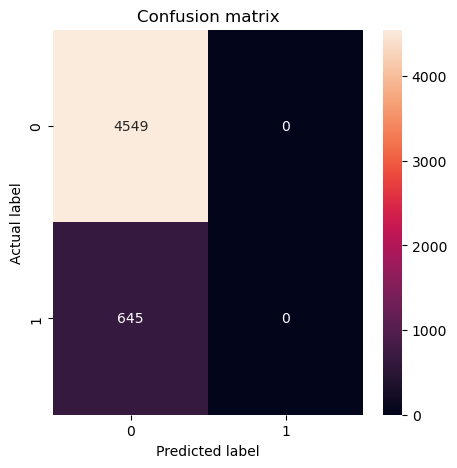

In [50]:
lfp = 1
lfn = 19
tau = lfp/(lfp+lfn)

# y_pred = decision_tree.predict(X_valid[feature_for_dt])

y_prob = predict(mlp_with_class_weights, validset[:][0]).numpy()

y_prob[y_prob < 1e-5] = 1e-5 # Log-loss returns NaN if too close to zero or one
y_prob[y_prob > 1- 1e-5] =  1- 1e-5

print('AUC score: ', roc_auc_score(y_valid, y_prob))

y_pred = (y_prob > tau).astype(int)
# y_pred = decision_tree.predict(valid[feature_for_dt])

plot_cm(y_valid, y_pred)